<a href="https://colab.research.google.com/github/danielgrgurevic/PortafolioDataScience/blob/main/SQM_forecast_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto predicciones valor de acciones de SQM con LSTM.


* Objetivo:

  - Predecer em un plazo de 6 meses los valores de las acciones para poder realizar una mejor gestión de cartera.

* Tareas:
 1- importar datos
 2- unir todo en un dataframe

  2.1 - comsiderar alineacion temporal

  2.2 - frecuencia de datos
  
  2.3 limpieza de datos


revisar colinealidad

# 1- Importación de Datos

## 1.1 Datos SQM

In [212]:
!pip install fredapi

In [213]:
import yfinance as yf
import pandas as pd

# Definición del ticker de SQM
sqm_ticker = 'SQM'

# Obtención de datos históricos de precios de SQM
sqm_data = yf.Ticker(sqm_ticker)
df_sqm = sqm_data.history(start="1994-01-01")
df_sqm = df_sqm.reset_index()

In [214]:
# Convertir la columna 'fecha' al formato de fecha 'año-mes-día'
df_sqm['Date'] = pd.to_datetime(df_sqm['Date'], format='%Y %m %d')
df_sqm['Date'] = df_sqm['Date'].dt.strftime('%Y %m %d')

In [215]:
df_sqm['Date'] = pd.to_datetime(df_sqm['Date'], format='%Y %m %d')

In [216]:
df_sqm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647 entries, 0 to 7646
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          7647 non-null   datetime64[ns]
 1   Open          7647 non-null   float64       
 2   High          7647 non-null   float64       
 3   Low           7647 non-null   float64       
 4   Close         7647 non-null   float64       
 5   Volume        7647 non-null   int64         
 6   Dividends     7647 non-null   float64       
 7   Stock Splits  7647 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 478.1 KB


In [217]:
df_sqm

Date       Open       High        Low      Close   Volume  \
0    1994-01-03   1.151877   1.175874   1.142278   1.166275   960245   
1    1994-01-04   1.161476   1.161476   1.142278   1.151877   413881   
2    1994-01-05   1.151877   1.161476   1.123080   1.147078   610038   
3    1994-01-06   1.151877   1.151877   1.118280   1.118280   115024   
4    1994-01-07   1.118280   1.118280   1.094283   1.094283   218751   
...         ...        ...        ...        ...        ...      ...   
7642 2024-05-10  48.660000  48.660000  46.380001  46.790001  1139400   
7643 2024-05-13  47.200001  48.209999  46.709999  48.099998   725900   
7644 2024-05-14  48.490002  49.680000  48.400002  49.509998  1106700   
7645 2024-05-15  50.009998  50.009998  47.919998  47.980000  1142900   
7646 2024-05-16  48.040001  48.490002  47.200001  47.970001   870010   

      Dividends  Stock Splits  
0           0.0           0.0  
1           0.0           0.0  
2           0.0           0.0  
3           0.0           0.0  
4           0.0           0.0  
...         ...           ...  
7642        0.0           0.0  
7643        0.0           0.0  
7644        0.0           0.0  
7645        0.0           0.0  
7646        0.0           0.0  

[7647 rows x 8 columns]

## 1.2 tasa del tesoro a 3 meses

In [218]:
# Definición del ticker para la tasa de fondos federales efectiva diaria
ticker = '^IRX'  # Este es el símbolo para la tasa del Tesoro a 3 meses, ajusta según la tasa que te interese

# Obtención de datos históricos de precios de este indicador
data = yf.Ticker(ticker)
df_tasa_diaria = data.history(period="max")  # Cambia 'max' por las fechas específicas si es necesario

# Filtrar datos desde una fecha específica, por ejemplo, desde 1994
df_tasa_diaria = df_tasa_diaria.loc['1994-01-01':]

In [219]:
# Sacar Date del índice y volverlo una columna
df_tasa_diaria.reset_index(inplace=True)
df_tasa_diaria['Date'] = df_tasa_diaria['Date'].dt.strftime('%Y %m %d')
df_tasa_diaria['Date'] = pd.to_datetime(df_tasa_diaria['Date'], format='%Y %m %d')

In [220]:
df_tasa_diaria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          7628 non-null   datetime64[ns]
 1   Open          7628 non-null   float64       
 2   High          7628 non-null   float64       
 3   Low           7628 non-null   float64       
 4   Close         7628 non-null   float64       
 5   Volume        7628 non-null   int64         
 6   Dividends     7628 non-null   float64       
 7   Stock Splits  7628 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 476.9 KB


In [221]:
df_tasa_diaria

Date  Open   High    Low  Close  Volume  Dividends  Stock Splits
0    1994-01-03  3.01  3.040  3.010  3.030       0        0.0           0.0
1    1994-01-04  3.09  3.090  3.070  3.080       0        0.0           0.0
2    1994-01-05  3.08  3.080  3.060  3.070       0        0.0           0.0
3    1994-01-06  3.06  3.060  3.040  3.050       0        0.0           0.0
4    1994-01-07  3.04  3.040  3.010  3.010       0        0.0           0.0
...         ...   ...    ...    ...    ...     ...        ...           ...
7623 2024-05-10  5.24  5.245  5.238  5.243       0        0.0           0.0
7624 2024-05-13  5.24  5.245  5.240  5.240       0        0.0           0.0
7625 2024-05-14  5.24  5.243  5.235  5.235       0        0.0           0.0
7626 2024-05-15  5.24  5.243  5.235  5.240       0        0.0           0.0
7627 2024-05-16  5.24  5.243  5.238  5.243       0        0.0           0.0

[7628 rows x 8 columns]

2. indicadores sectoriales, precios de commodities

In [222]:
import yfinance as yf

# Ejemplo para obtener el precio de commodities que están disponibles en forma de ETF o fondos negociables en bolsa
cobre_etf = yf.download("COPX", start="1994-01-01")  # ETF de cobre

# Ejemplo para descargar datos del ETF de oro
gold_etf = yf.download("GLD", start="2004-01-01")

# Ejemplo para descargar datos del ETF que sigue el precio del petróleo
oil_etf = yf.download("USO", start="2007-01-01")

#natural_gas_etf = yf.download("UNG", start="2007-01-01")  # UNG empezó en 2007

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [223]:
cobre_etf

Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2010-04-20  44.700001  44.700001  43.950001  44.040001  32.777870     1933
2010-04-21  43.799999  44.099998  43.230000  43.349998  32.264317     2900
2010-04-22  43.169998  43.169998  42.509998  43.110001  32.085690     3600
2010-04-23  42.959999  43.259998  42.750000  43.259998  32.197323     1100
2010-04-26  44.880001  44.880001  43.200001  43.919998  32.688564     3600
...               ...        ...        ...        ...        ...      ...
2024-05-10  48.310001  48.730000  47.939999  47.980000  47.980000  2228700
2024-05-13  48.480000  48.590000  48.060001  48.290001  48.290001   972100
2024-05-14  48.799999  50.080002  48.709999  49.709999  49.709999  2444200
2024-05-15  50.509998  50.529999  48.730000  49.680000  49.680000  3264900
2024-05-16  49.549999  49.630001  49.160000  49.360001  49.360001  1215737

[3544 rows x 6 columns]

In [224]:
gold_etf

Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-11-18   44.430000   44.490002   44.070000   44.380001   44.380001   
2004-11-19   44.490002   44.919998   44.470001   44.779999   44.779999   
2004-11-22   44.750000   44.970001   44.740002   44.950001   44.950001   
2004-11-23   44.880001   44.919998   44.720001   44.750000   44.750000   
2004-11-24   44.930000   45.049999   44.790001   45.049999   45.049999   
...                ...         ...         ...         ...         ...   
2024-05-10  219.220001  219.600006  218.080002  218.710007  218.710007   
2024-05-13  217.059998  217.309998  215.800003  216.259995  216.259995   
2024-05-14  217.309998  218.380005  216.979996  218.089996  218.089996   
2024-05-15  219.059998  221.190002  217.649994  220.889999  220.889999   
2024-05-16  220.139999  220.580002  219.410004  220.029999  220.029999   

              Volume  
Date                  
2004-11-18   5992000  
2004-11-19  11655300  
2004-11-22  11996000  
2004-11-23   3169200  
2004-11-24   6105100  
...              ...  
2024-05-10   8700900  
2024-05-13   4896300  
2024-05-14   4662700  
2024-05-15   9297700  
2024-05-16   4242788  

[4906 rows x 6 columns]

In [225]:
oil_etf

Open        High         Low       Close   Adj Close  \
Date                                                                     
2007-01-03  411.359985  411.359985  393.040009  395.200012  395.200012   
2007-01-04  388.320007  391.200012  377.760010  379.119995  379.119995   
2007-01-05  379.200012  383.440002  375.119995  382.640015  382.640015   
2007-01-08  389.760010  392.399994  376.000000  379.920013  379.920013   
2007-01-09  370.160004  380.000000  369.440002  378.399994  378.399994   
...                ...         ...         ...         ...         ...   
2024-05-10   76.680000   76.830002   75.239998   75.300003   75.300003   
2024-05-13   75.720001   76.430000   75.599998   76.129997   76.129997   
2024-05-14   75.300003   75.870003   74.839996   75.209999   75.209999   
2024-05-15   74.449997   75.879997   73.879997   75.879997   75.879997   
2024-05-16   76.639999   76.730003   75.930000   76.250000   76.250000   

             Volume  
Date                 
2007-01-03   401713  
2007-01-04   557488  
2007-01-05   454100  
2007-01-08   493650  
2007-01-09   502463  
...             ...  
2024-05-10  2746600  
2024-05-13  3055300  
2024-05-14  2186600  
2024-05-15  3660000  
2024-05-16  3134362  

[4373 rows x 6 columns]

In [226]:
import yfinance as yf

# Obtener datos del índice Shanghai Composite
shanghai_comp = yf.Ticker("000001.SS")
data_shanghai = shanghai_comp.history(period="max")
data_shanghai

Open         High          Low        Close  \
Date                                                                            
1997-07-02 00:00:00+08:00  1255.909058  1261.571045  1147.331055  1199.061035   
1997-07-03 00:00:00+08:00  1194.676025  1194.676025  1149.939941  1150.623047   
1997-07-04 00:00:00+08:00  1138.921021  1163.249023  1124.776001  1159.342041   
1997-07-07 00:00:00+08:00  1161.707031  1163.447021  1085.572021  1096.818970   
1997-07-08 00:00:00+08:00  1092.798950  1115.432983  1066.043945  1109.666016   
...                                ...          ...          ...          ...   
2024-05-10 00:00:00+08:00  3158.589111  3163.144043  3137.152100  3154.547119   
2024-05-13 00:00:00+08:00  3139.475098  3157.365967  3126.169922  3148.020996   
2024-05-14 00:00:00+08:00  3148.849121  3155.806885  3137.608887  3145.773926   
2024-05-15 00:00:00+08:00  3141.251953  3142.972900  3117.928955  3119.902100   
2024-05-16 00:00:00+08:00  3127.184082  3137.877930  3116.162598  3122.400879   

                               Volume  Dividends  Stock Splits  
Date                                                            
1997-07-02 00:00:00+08:00           0        0.0           0.0  
1997-07-03 00:00:00+08:00           0        0.0           0.0  
1997-07-04 00:00:00+08:00           0        0.0           0.0  
1997-07-07 00:00:00+08:00           0        0.0           0.0  
1997-07-08 00:00:00+08:00           0        0.0           0.0  
...                               ...        ...           ...  
2024-05-10 00:00:00+08:00      384300        0.0           0.0  
2024-05-13 00:00:00+08:00      397000        0.0           0.0  
2024-05-14 00:00:00+08:00      343500        0.0           0.0  
2024-05-15 00:00:00+08:00      321000        0.0           0.0  
2024-05-16 00:00:00+08:00  2381997732        0.0           0.0  

[6508 rows x 7 columns]

## 1.3 Datos del Mercado Financiero (S&P 500, NASDAQ, VIX)

In [227]:
# Obtener datos del S&P 500
sp500 = yf.download("^GSPC", start="1994-01-01")

# Obtener datos del NASDAQ
nasdaq = yf.download("^IXIC", start="1994-01-01")

# Obtener datos del VIX
vix = yf.download("^VIX", start="1994-01-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [228]:
# Sacar Date del índice y volverlo una columna
sp500.reset_index(inplace=True)

In [229]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647 entries, 0 to 7646
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7647 non-null   datetime64[ns]
 1   Open       7647 non-null   float64       
 2   High       7647 non-null   float64       
 3   Low        7647 non-null   float64       
 4   Close      7647 non-null   float64       
 5   Adj Close  7647 non-null   float64       
 6   Volume     7647 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.3 KB


In [230]:
sp500

Date         Open         High          Low        Close  \
0    1994-01-03   466.510010   466.940002   464.359985   465.440002   
1    1994-01-04   465.440002   466.890015   464.440002   466.890015   
2    1994-01-05   466.890015   467.820007   465.920013   467.549988   
3    1994-01-06   467.549988   469.000000   467.019989   467.119995   
4    1994-01-07   467.089996   470.260010   467.029999   469.899994   
...         ...          ...          ...          ...          ...   
7642 2024-05-10  5225.490234  5239.660156  5209.680176  5222.680176   
7643 2024-05-13  5233.080078  5237.259766  5211.160156  5221.419922   
7644 2024-05-14  5221.100098  5250.370117  5217.979980  5246.680176   
7645 2024-05-15  5263.259766  5311.759766  5263.259766  5308.149902   
7646 2024-05-16  5310.069824  5325.490234  5296.189941  5297.100098   

        Adj Close      Volume  
0      465.440002   270140000  
1      466.890015   326600000  
2      467.549988   400030000  
3      467.119995   365960000  
4      469.899994   324920000  
...           ...         ...  
7642  5222.680176  3617900000  
7643  5221.419922  4255710000  
7644  5246.680176  4763580000  
7645  5308.149902  4360810000  
7646  5297.100098  2180794000  

[7647 rows x 7 columns]

In [231]:
# Sacar Date del índice y volverlo una columna
nasdaq.reset_index(inplace=True)

In [232]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647 entries, 0 to 7646
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7647 non-null   datetime64[ns]
 1   Open       7647 non-null   float64       
 2   High       7647 non-null   float64       
 3   Low        7647 non-null   float64       
 4   Close      7647 non-null   float64       
 5   Adj Close  7647 non-null   float64       
 6   Volume     7647 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.3 KB


In [233]:
nasdaq

Date          Open          High           Low         Close  \
0    1994-01-03    774.109985    777.289978    768.409973    770.760010   
1    1994-01-04    771.429993    774.780029    771.020020    774.280029   
2    1994-01-05    775.229980    778.210022    773.690002    778.049988   
3    1994-01-06    780.359985    781.210022    778.250000    780.409973   
4    1994-01-07    779.289978    783.390015    778.200012    782.940002   
...         ...           ...           ...           ...           ...   
7642 2024-05-10  16389.019531  16437.390625  16293.519531  16340.870117   
7643 2024-05-13  16400.310547  16407.050781  16334.860352  16388.240234   
7644 2024-05-14  16391.160156  16526.269531  16386.429688  16511.179688   
7645 2024-05-15  16601.140625  16749.740234  16544.089844  16742.390625   
7646 2024-05-16  16738.099609  16797.833984  16693.445312  16698.320312   

         Adj Close       Volume  
0       770.760010    253020000  
1       774.280029    298600000  
2       778.049988    349880000  
3       780.409973    349210000  
4       782.940002    330060000  
...            ...          ...  
7642  16340.870117   4402110000  
7643  16388.240234   4452750000  
7644  16511.179688   7270240000  
7645  16742.390625   8538990000  
7646  16698.320312  11590956000  

[7647 rows x 7 columns]

In [234]:
# Sacar Date del índice y volverlo una columna
vix.reset_index(inplace=True)

In [235]:
vix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647 entries, 0 to 7646
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7647 non-null   datetime64[ns]
 1   Open       7647 non-null   float64       
 2   High       7647 non-null   float64       
 3   Low        7647 non-null   float64       
 4   Close      7647 non-null   float64       
 5   Adj Close  7647 non-null   float64       
 6   Volume     7647 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 418.3 KB


In [236]:
vix

Date   Open   High    Low  Close  Adj Close  Volume
0    1994-01-03  11.28  13.42  11.28  12.57      12.57       0
1    1994-01-04  12.87  12.87  11.81  11.91      11.91       0
2    1994-01-05  11.47  11.47  10.37  10.94      10.94       0
3    1994-01-06  11.47  11.74  10.34  11.27      11.27       0
4    1994-01-07  11.47  12.14  10.00  10.96      10.96       0
...         ...    ...    ...    ...    ...        ...     ...
7642 2024-05-10  12.77  12.96  12.50  12.55      12.55       0
7643 2024-05-13  13.26  13.66  13.25  13.60      13.60       0
7644 2024-05-14  13.71  14.03  13.27  13.42      13.42       0
7645 2024-05-15  13.73  13.94  12.38  12.45      12.45       0
7646 2024-05-16  12.52  12.67  12.33  12.42      12.42       0

[7647 rows x 7 columns]

## 1.4 Unión de Dataframes

In [237]:
df = pd.merge(df_sqm, df_tasa_diaria, on='Date', how = 'left', suffixes= ('_sqm', '_tasas'))

In [238]:
df = pd.merge(df, sp500, on='Date', how = 'left', suffixes = ('', '_sp500'))
df = pd.merge(df, nasdaq, on='Date', how = 'left', suffixes = ('_sp500', '_nasdaq'))
df = pd.merge(df, vix, on='Date', how = 'left', suffixes = ('', '_vix') )

In [239]:
df

Date   Open_sqm   High_sqm    Low_sqm  Close_sqm  Volume_sqm  \
0    1994-01-03   1.151877   1.175874   1.142278   1.166275      960245   
1    1994-01-04   1.161476   1.161476   1.142278   1.151877      413881   
2    1994-01-05   1.151877   1.161476   1.123080   1.147078      610038   
3    1994-01-06   1.151877   1.151877   1.118280   1.118280      115024   
4    1994-01-07   1.118280   1.118280   1.094283   1.094283      218751   
...         ...        ...        ...        ...        ...         ...   
7642 2024-05-10  48.660000  48.660000  46.380001  46.790001     1139400   
7643 2024-05-13  47.200001  48.209999  46.709999  48.099998      725900   
7644 2024-05-14  48.490002  49.680000  48.400002  49.509998     1106700   
7645 2024-05-15  50.009998  50.009998  47.919998  47.980000     1142900   
7646 2024-05-16  48.040001  48.490002  47.200001  47.970001      870010   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
0               0.0               0.0        3.01       3.040      3.010   
1               0.0               0.0        3.09       3.090      3.070   
2               0.0               0.0        3.08       3.080      3.060   
3               0.0               0.0        3.06       3.060      3.040   
4               0.0               0.0        3.04       3.040      3.010   
...             ...               ...         ...         ...        ...   
7642            0.0               0.0        5.24       5.245      5.238   
7643            0.0               0.0        5.24       5.245      5.240   
7644            0.0               0.0        5.24       5.243      5.235   
7645            0.0               0.0        5.24       5.243      5.235   
7646            0.0               0.0        5.24       5.243      5.238   

      Close_tasas  Volume_tasas  Dividends_tasas  Stock Splits_tasas  \
0           3.030           0.0              0.0                 0.0   
1           3.080           0.0              0.0                 0.0   
2           3.070           0.0              0.0                 0.0   
3           3.050           0.0              0.0                 0.0   
4           3.010           0.0              0.0                 0.0   
...           ...           ...              ...                 ...   
7642        5.243           0.0              0.0                 0.0   
7643        5.240           0.0              0.0                 0.0   
7644        5.235           0.0              0.0                 0.0   
7645        5.240           0.0              0.0                 0.0   
7646        5.243           0.0              0.0                 0.0   

       Open_sp500   High_sp500    Low_sp500  Close_sp500  Adj Close_sp500  \
0      466.510010   466.940002   464.359985   465.440002       465.440002   
1      465.440002   466.890015   464.440002   466.890015       466.890015   
2      466.890015   467.820007   465.920013   467.549988       467.549988   
3      467.549988   469.000000   467.019989   467.119995       467.119995   
4      467.089996   470.260010   467.029999   469.899994       469.899994   
...           ...          ...          ...          ...              ...   
7642  5225.490234  5239.660156  5209.680176  5222.680176      5222.680176   
7643  5233.080078  5237.259766  5211.160156  5221.419922      5221.419922   
7644  5221.100098  5250.370117  5217.979980  5246.680176      5246.680176   
7645  5263.259766  5311.759766  5263.259766  5308.149902      5308.149902   
7646  5310.069824  5325.490234  5296.189941  5297.100098      5297.100098   

      Volume_sp500   Open_nasdaq   High_nasdaq    Low_nasdaq  Close_nasdaq  \
0        270140000    774.109985    777.289978    768.409973    770.760010   
1        326600000    771.429993    774.780029    771.020020    774.280029   
2        400030000    775.229980    778.210022    773.690002    778.049988   
3        365960000    780.359985    781.210022    778.250000    780.409973   
4        32492000

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647 entries, 0 to 7646
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                7647 non-null   datetime64[ns]
 1   Open_sqm            7647 non-null   float64       
 2   High_sqm            7647 non-null   float64       
 3   Low_sqm             7647 non-null   float64       
 4   Close_sqm           7647 non-null   float64       
 5   Volume_sqm          7647 non-null   int64         
 6   Dividends_sqm       7647 non-null   float64       
 7   Stock Splits_sqm    7647 non-null   float64       
 8   Open_tasas          7628 non-null   float64       
 9   High_tasas          7628 non-null   float64       
 10  Low_tasas           7628 non-null   float64       
 11  Close_tasas         7628 non-null   float64       
 12  Volume_tasas        7628 non-null   float64       
 13  Dividends_tasas     7628 non-null   float64     

In [241]:
# Interpolar los valores faltantes
df.interpolate(inplace=True)

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647 entries, 0 to 7646
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                7647 non-null   datetime64[ns]
 1   Open_sqm            7647 non-null   float64       
 2   High_sqm            7647 non-null   float64       
 3   Low_sqm             7647 non-null   float64       
 4   Close_sqm           7647 non-null   float64       
 5   Volume_sqm          7647 non-null   int64         
 6   Dividends_sqm       7647 non-null   float64       
 7   Stock Splits_sqm    7647 non-null   float64       
 8   Open_tasas          7647 non-null   float64       
 9   High_tasas          7647 non-null   float64       
 10  Low_tasas           7647 non-null   float64       
 11  Close_tasas         7647 non-null   float64       
 12  Volume_tasas        7647 non-null   float64       
 13  Dividends_tasas     7647 non-null   float64     

In [243]:
df

Date   Open_sqm   High_sqm    Low_sqm  Close_sqm  Volume_sqm  \
0    1994-01-03   1.151877   1.175874   1.142278   1.166275      960245   
1    1994-01-04   1.161476   1.161476   1.142278   1.151877      413881   
2    1994-01-05   1.151877   1.161476   1.123080   1.147078      610038   
3    1994-01-06   1.151877   1.151877   1.118280   1.118280      115024   
4    1994-01-07   1.118280   1.118280   1.094283   1.094283      218751   
...         ...        ...        ...        ...        ...         ...   
7642 2024-05-10  48.660000  48.660000  46.380001  46.790001     1139400   
7643 2024-05-13  47.200001  48.209999  46.709999  48.099998      725900   
7644 2024-05-14  48.490002  49.680000  48.400002  49.509998     1106700   
7645 2024-05-15  50.009998  50.009998  47.919998  47.980000     1142900   
7646 2024-05-16  48.040001  48.490002  47.200001  47.970001      870010   

      Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
0               0.0               0.0        3.01       3.040      3.010   
1               0.0               0.0        3.09       3.090      3.070   
2               0.0               0.0        3.08       3.080      3.060   
3               0.0               0.0        3.06       3.060      3.040   
4               0.0               0.0        3.04       3.040      3.010   
...             ...               ...         ...         ...        ...   
7642            0.0               0.0        5.24       5.245      5.238   
7643            0.0               0.0        5.24       5.245      5.240   
7644            0.0               0.0        5.24       5.243      5.235   
7645            0.0               0.0        5.24       5.243      5.235   
7646            0.0               0.0        5.24       5.243      5.238   

      Close_tasas  Volume_tasas  Dividends_tasas  Stock Splits_tasas  \
0           3.030           0.0              0.0                 0.0   
1           3.080           0.0              0.0                 0.0   
2           3.070           0.0              0.0                 0.0   
3           3.050           0.0              0.0                 0.0   
4           3.010           0.0              0.0                 0.0   
...           ...           ...              ...                 ...   
7642        5.243           0.0              0.0                 0.0   
7643        5.240           0.0              0.0                 0.0   
7644        5.235           0.0              0.0                 0.0   
7645        5.240           0.0              0.0                 0.0   
7646        5.243           0.0              0.0                 0.0   

       Open_sp500   High_sp500    Low_sp500  Close_sp500  Adj Close_sp500  \
0      466.510010   466.940002   464.359985   465.440002       465.440002   
1      465.440002   466.890015   464.440002   466.890015       466.890015   
2      466.890015   467.820007   465.920013   467.549988       467.549988   
3      467.549988   469.000000   467.019989   467.119995       467.119995   
4      467.089996   470.260010   467.029999   469.899994       469.899994   
...           ...          ...          ...          ...              ...   
7642  5225.490234  5239.660156  5209.680176  5222.680176      5222.680176   
7643  5233.080078  5237.259766  5211.160156  5221.419922      5221.419922   
7644  5221.100098  5250.370117  5217.979980  5246.680176      5246.680176   
7645  5263.259766  5311.759766  5263.259766  5308.149902      5308.149902   
7646  5310.069824  5325.490234  5296.189941  5297.100098      5297.100098   

      Volume_sp500   Open_nasdaq   High_nasdaq    Low_nasdaq  Close_nasdaq  \
0        270140000    774.109985    777.289978    768.409973    770.760010   
1        326600000    771.429993    774.780029    771.020020    774.280029   
2        400030000    775.229980    778.210022    773.690002    778.049988   
3        365960000    780.359985    781.210022    778.250000    780.409973   
4        32492000

# 2. Exploración y Análisis de Datos

In [244]:
df.describe()

Date     Open_sqm     High_sqm      Low_sqm  \
count                           7647  7647.000000  7647.000000  7647.000000   
mean   2009-03-07 19:13:46.206355712    17.888770    18.169577    17.582791   
min              1994-01-03 00:00:00     0.715468     0.731216     0.713217   
25%              2001-07-30 12:00:00     1.790017     1.804970     1.777345   
50%              2009-03-10 00:00:00    12.191000    12.461832    11.951416   
75%              2016-10-10 12:00:00    28.859134    29.244221    28.463515   
max              2024-05-16 00:00:00    99.839905   101.435240    97.684875   
std                              NaN    19.636372    19.982966    19.238119   

         Close_sqm    Volume_sqm  Dividends_sqm  Stock Splits_sqm  \
count  7647.000000  7.647000e+03    7647.000000       7647.000000   
mean     17.872941  6.655729e+05       0.004075          0.001442   
min       0.719967  0.000000e+00       0.000000          0.000000   
25%       1.793414  2.095080e+05       0.000000          0.000000   
50%      12.191001  4.744740e+05       0.000000          0.000000   
75%      28.783083  8.801905e+05       0.000000          0.000000   
max      99.506821  3.025645e+07       3.224000         10.000000   
std      19.602650  9.175107e+05       0.074707          0.114955   

        Open_tasas   High_tasas    Low_tasas  Close_tasas   Volume_tasas  \
count  7647.000000  7647.000000  7647.000000  7647.000000    7647.000000   
mean      2.336497     2.350444     2.319159     2.334647     918.085524   
min      -0.108000    -0.100000    -0.235000    -0.105000       0.000000   
25%       0.135000     0.140000     0.128000     0.135000       0.000000   
50%       1.710000     1.720000     1.690000     1.700000       0.000000   
75%       4.724500     4.747500     4.698500     4.720000       0.000000   
max       6.210000     6.230000     6.210000     6.220000  159700.000000   
std       2.114383     2.119772     2.107884     2.114073   11956.919951   

       Dividends_tasas  Stock Splits_tasas   Open_sp500   High_sp500  \
count           7647.0              7647.0  7647.000000  7647.000000   
mean               0.0                 0.0  1784.072732  1794.590825   
min                0.0                 0.0   439.140015   444.720001   
25%                0.0                 0.0  1089.869995  1096.994995   
50%                0.0                 0.0  1340.300049  1350.199951   
75%                0.0                 0.0  2171.135010  2177.690063   
max                0.0                 0.0  5310.069824  5325.490234   
std                0.0                 0.0  1118.192180  1123.760834   

         Low_sp500  Close_sp500  Adj Close_sp500  Volume_sp500   Open_nasdaq  \
count  7647.000000  7647.000000      7647.000000  7.647000e+03   7647.000000   
mean   1772.874104  1784.450557      1784.450557  2.777219e+09   4407.478530   
min     435.859985   438.920013       438.920013  1.499000e+07    694.159973   
25%    1079.945007  1089.789978      1089.789978  1.164600e+09   1878.739990   
50%    1330.670044  1340.430054      1340.430054  3.073480e+09   2596.330078   
75%    2163.729980  2171.920044      2171.920044  3.961460e+09   5253.960205   
max    5296.189941  5308.149902      5308.149902  1.145623e+10  16738.099609   
std    1112.342126  1118.400464      1118.400464  1.757020e+09   3919.165090   

        High_nasdaq    Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  \
count   7647.000000   7647.000000   7647.000000       7647.000000   
mean    4438.497982   4372.469462   4407.428879       4407.428879   
min      699.780029    690.950012    693.789978        693.789978   
25%     1893.164978   1863.669983   1879.169983       1879.169983   
50%     2613.290039   2568.780029   2596.030029       2596.030029   
75%     5271.184814   5232.479980   5249.794922       5249.794922   
max    16797.833984  16693.445312  16742.390625      16742.390625   
std     3945.910720   3889.844668   3919.783453       3919.783453   

       Volume_nasdaq 

In [245]:
# Lista de columnas a eliminar
columnas_a_eliminar = ['Dividends_tasas', 'Stock Splits_tasas', 'Volume']

# Eliminar las columnas de la lista
df = df.drop(columns=columnas_a_eliminar)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647 entries, 0 to 7646
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7647 non-null   datetime64[ns]
 1   Open_sqm          7647 non-null   float64       
 2   High_sqm          7647 non-null   float64       
 3   Low_sqm           7647 non-null   float64       
 4   Close_sqm         7647 non-null   float64       
 5   Volume_sqm        7647 non-null   int64         
 6   Dividends_sqm     7647 non-null   float64       
 7   Stock Splits_sqm  7647 non-null   float64       
 8   Open_tasas        7647 non-null   float64       
 9   High_tasas        7647 non-null   float64       
 10  Low_tasas         7647 non-null   float64       
 11  Close_tasas       7647 non-null   float64       
 12  Volume_tasas      7647 non-null   float64       
 13  Open_sp500        7647 non-null   float64       
 14  High_sp500        7647 n

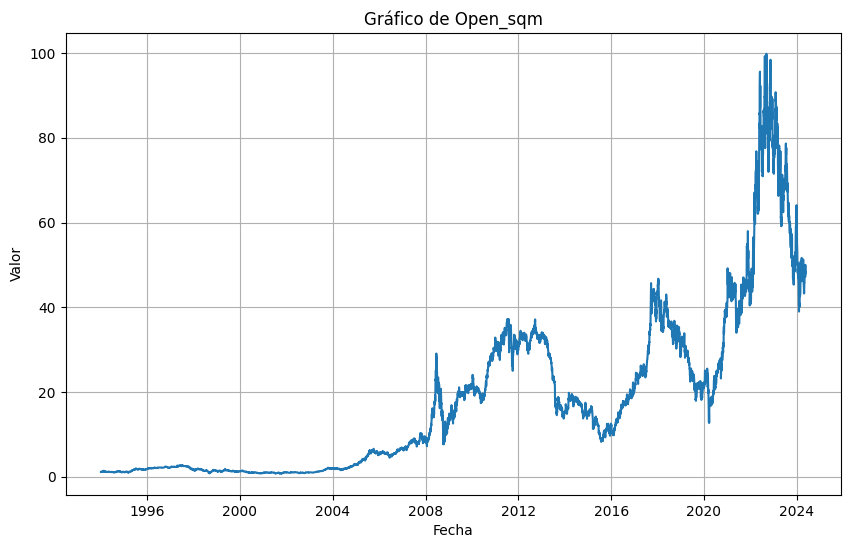

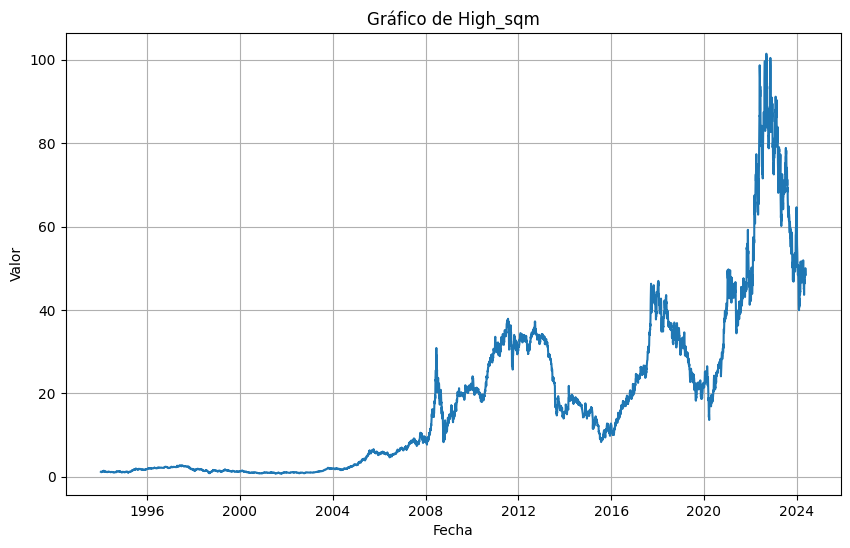

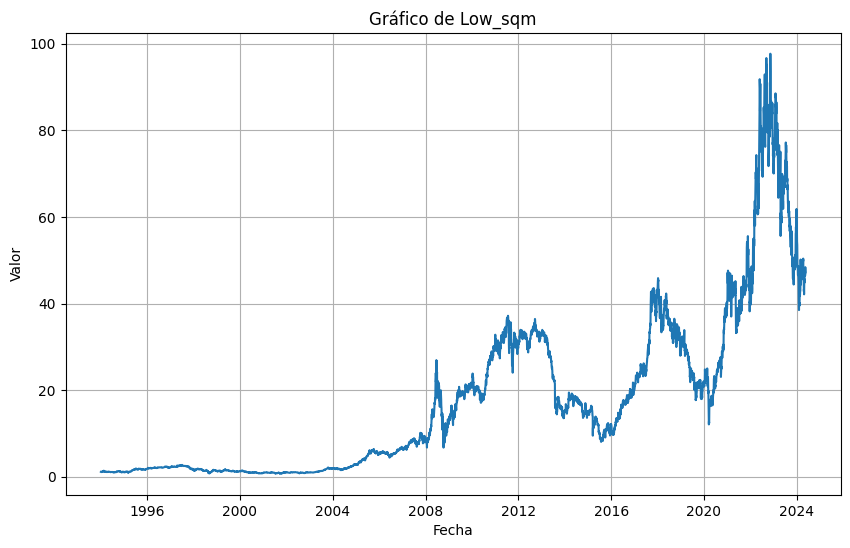

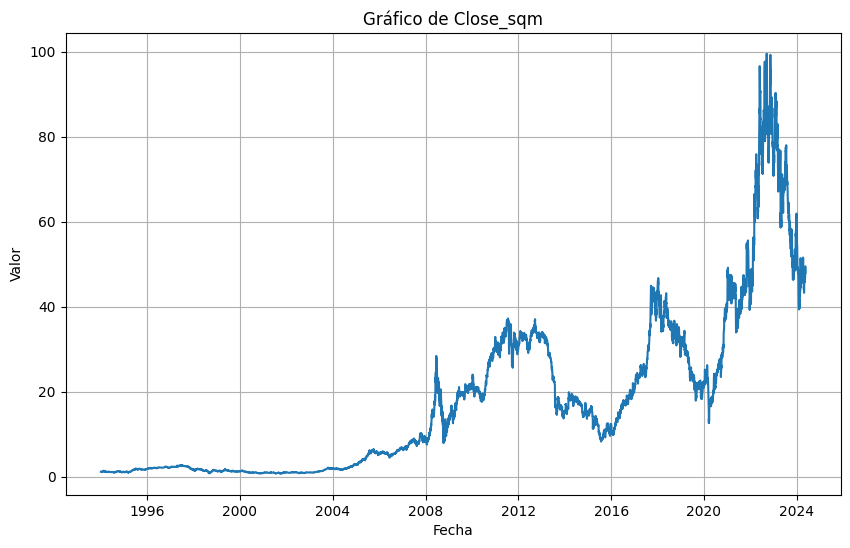

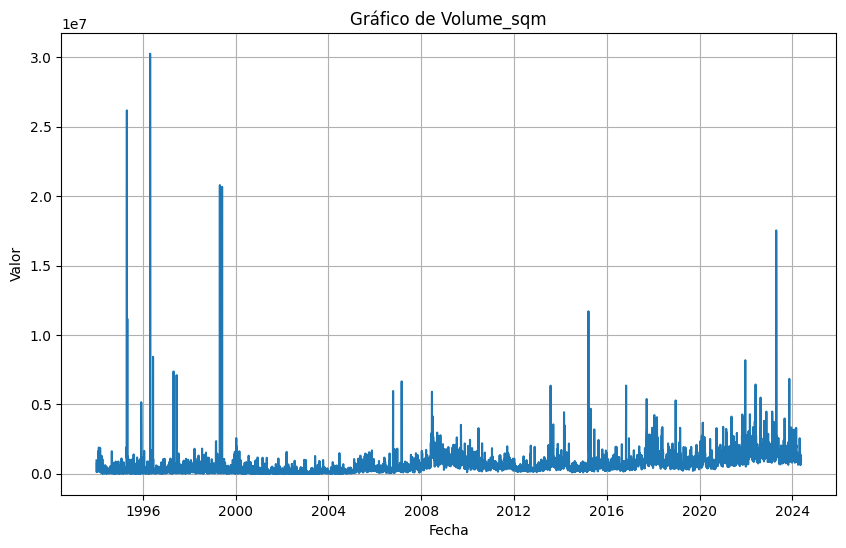

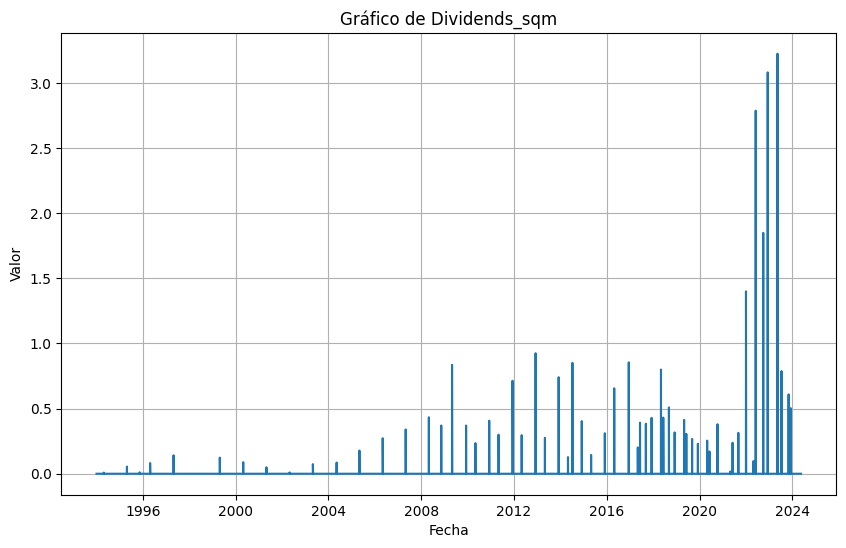

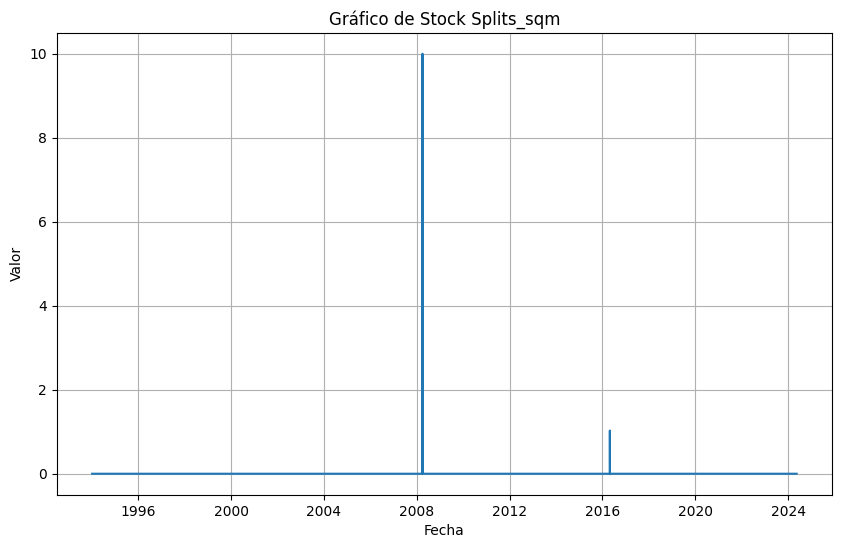

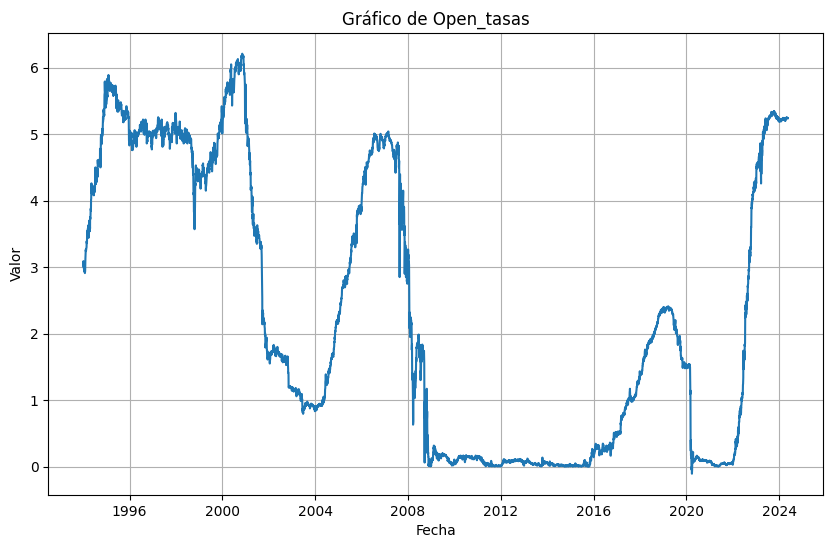

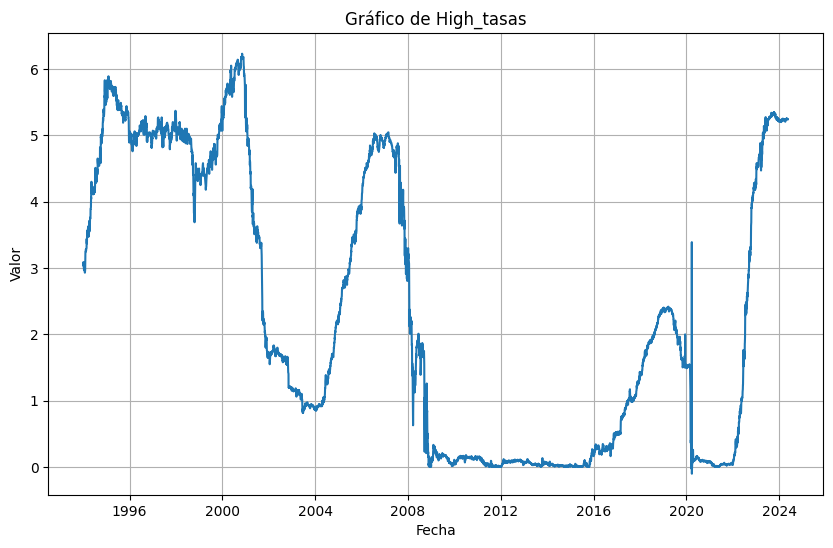

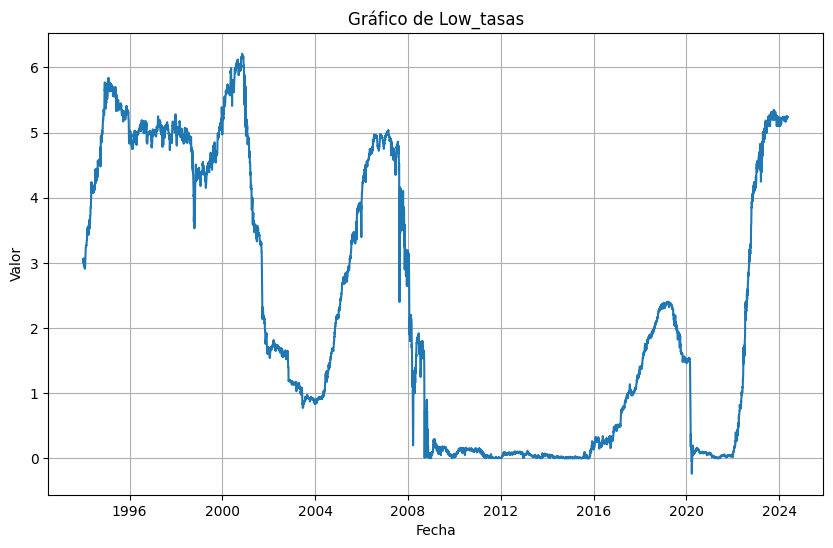

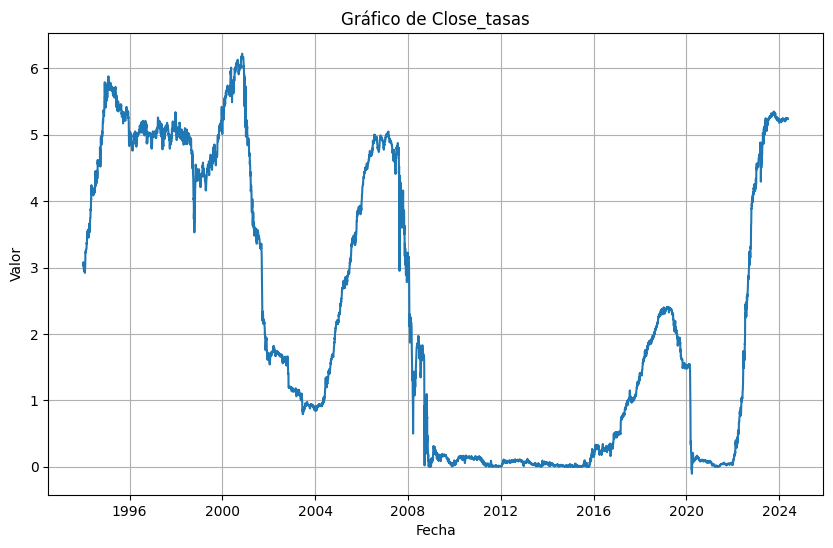

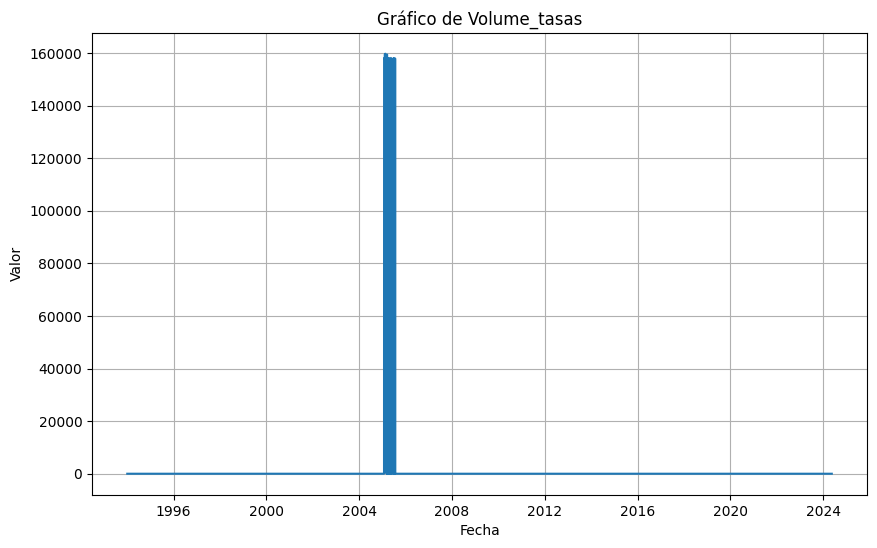

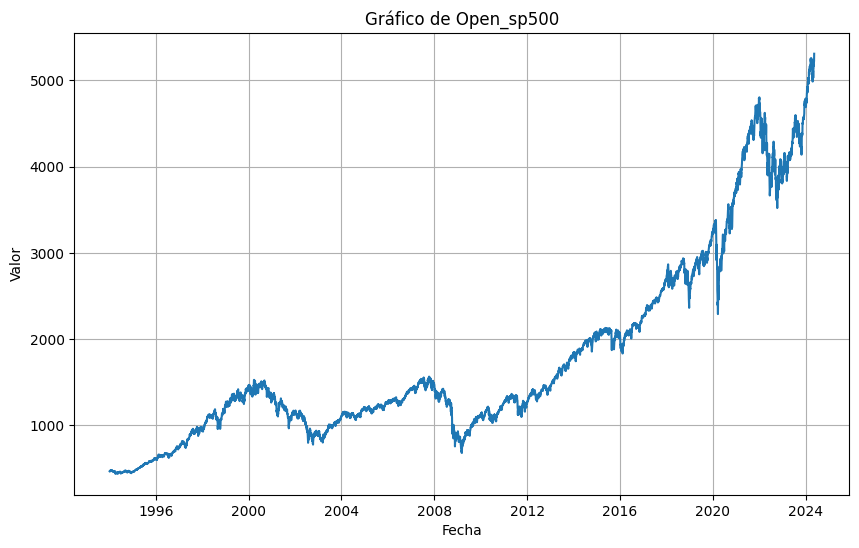

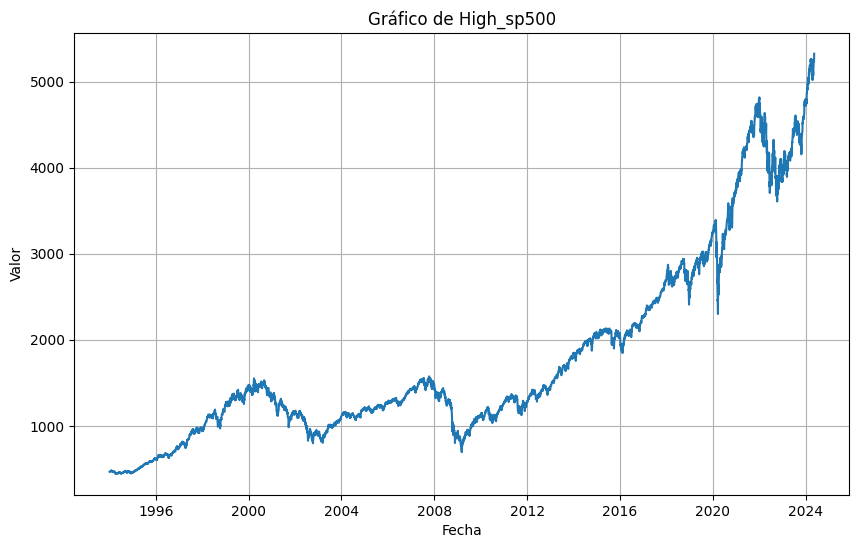

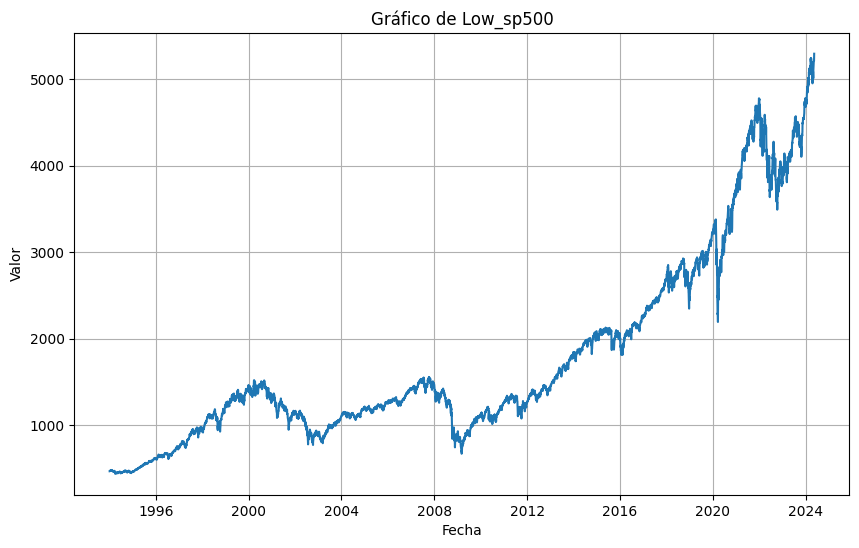

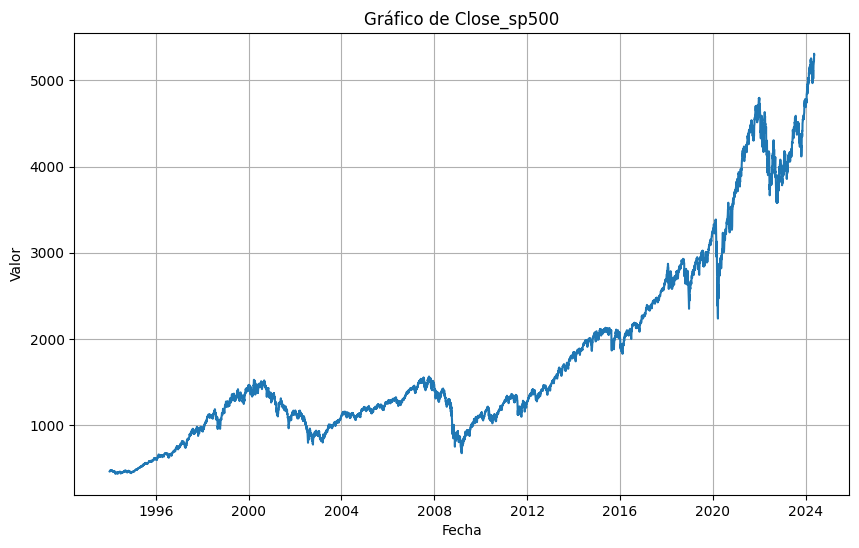

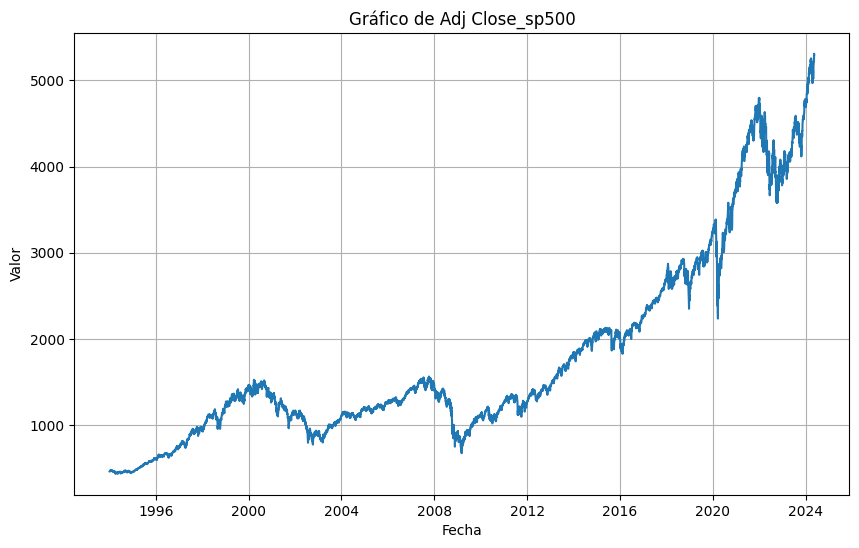

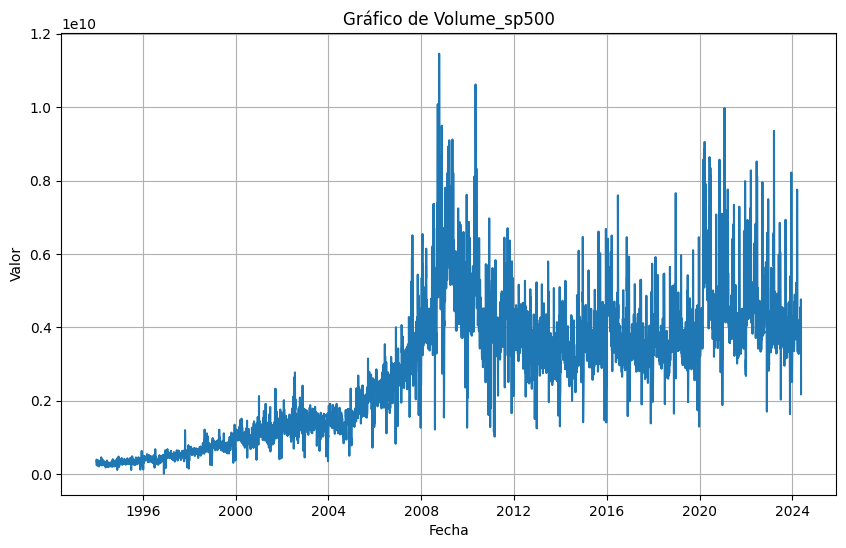

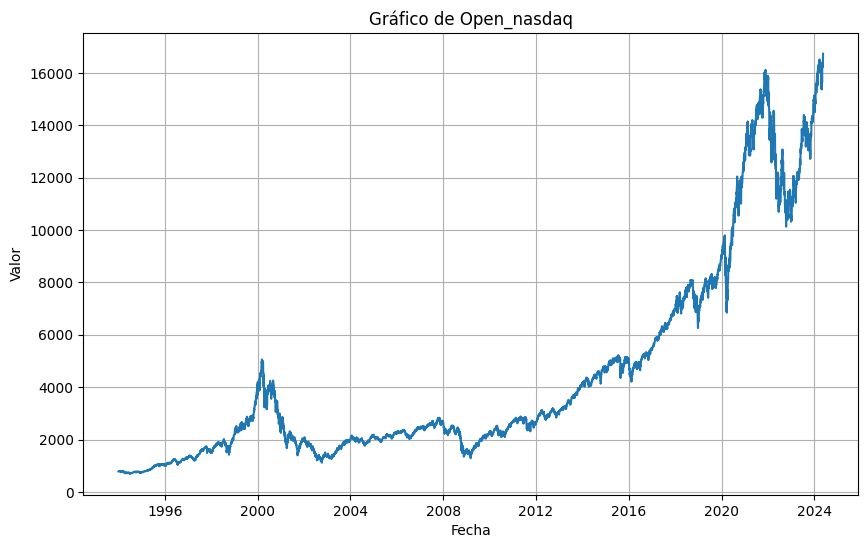

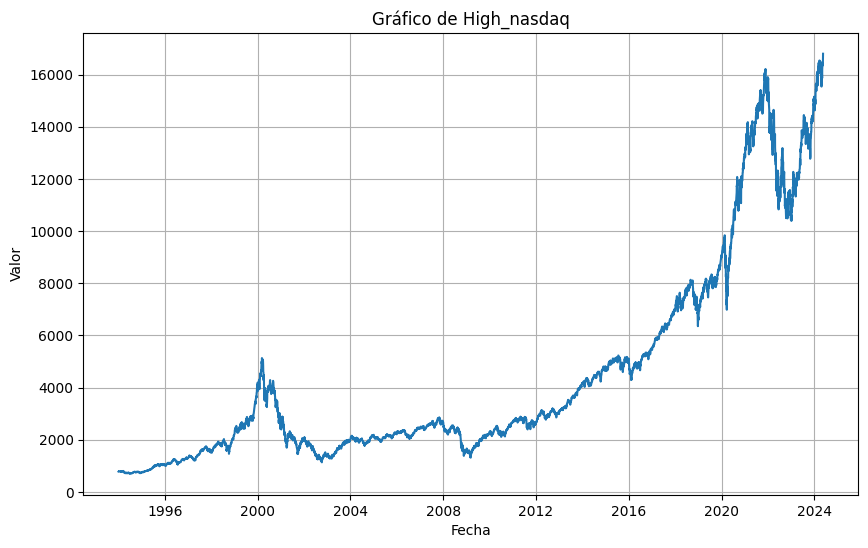

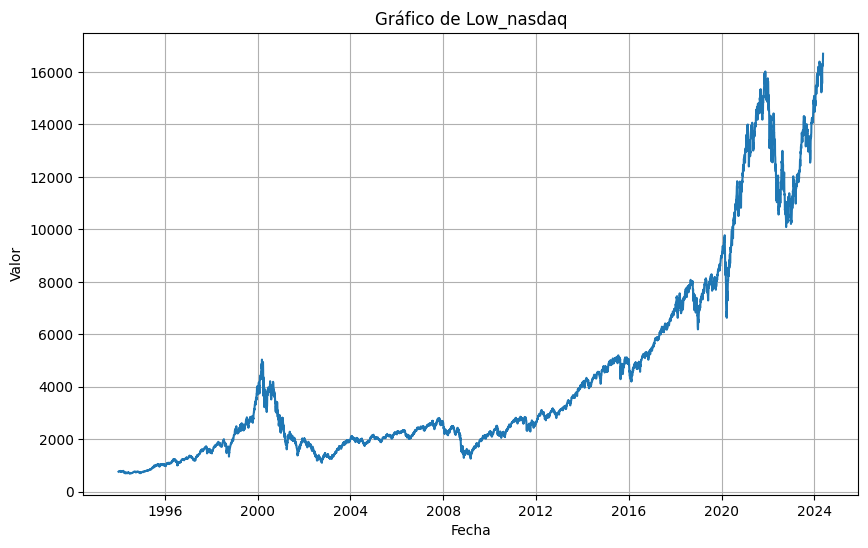

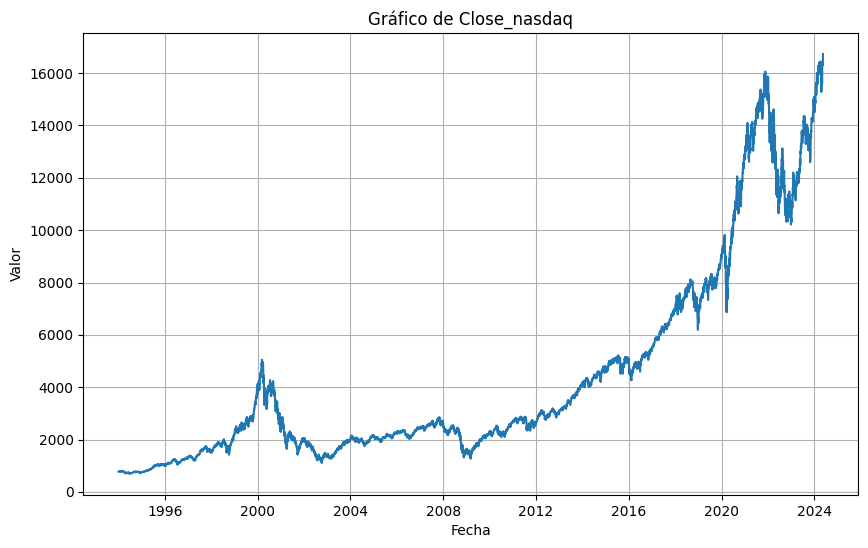

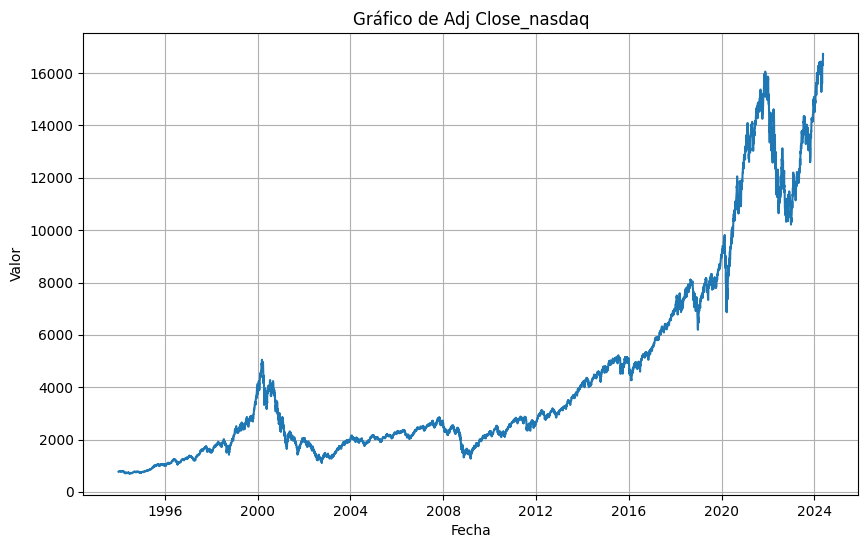

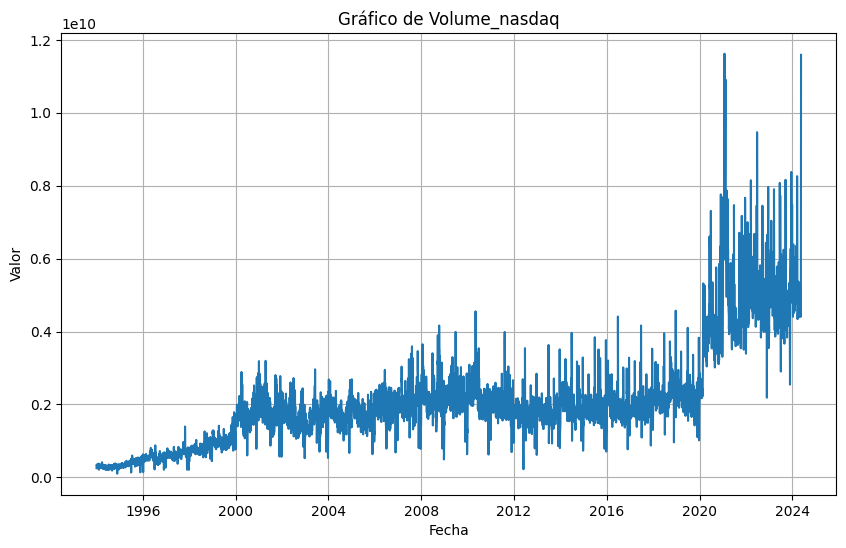

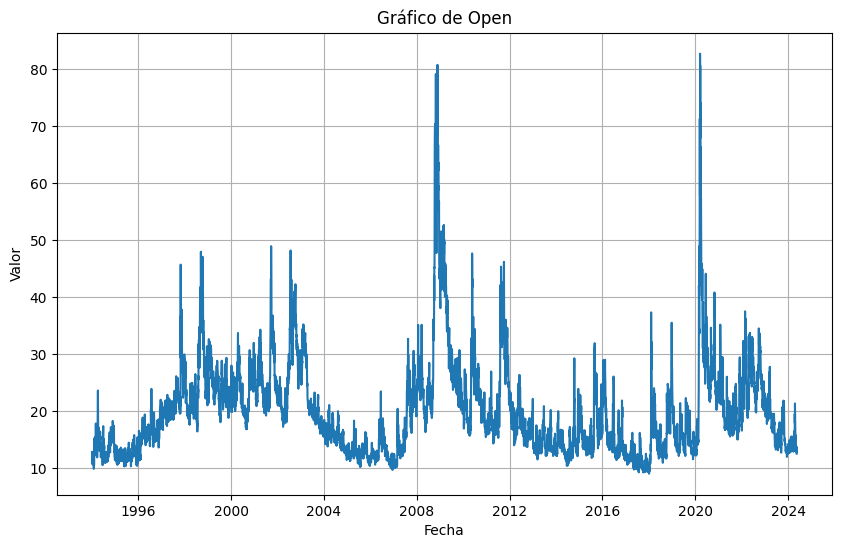

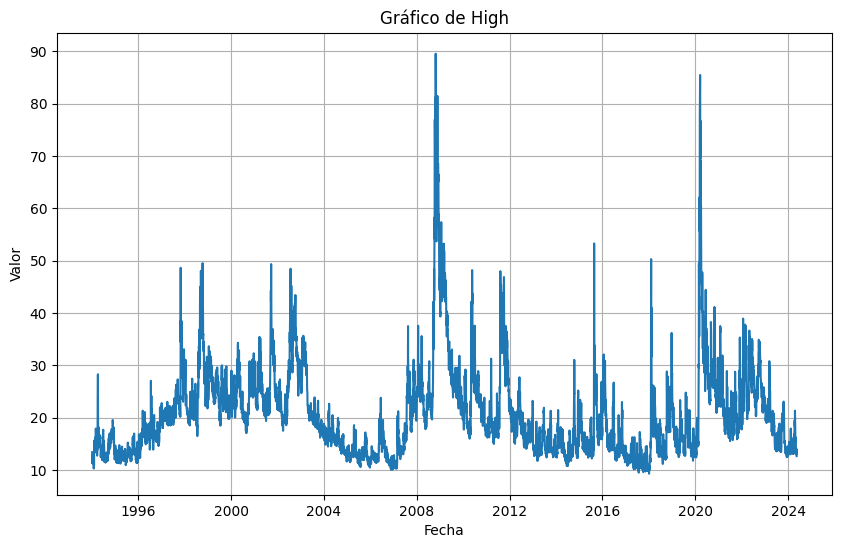

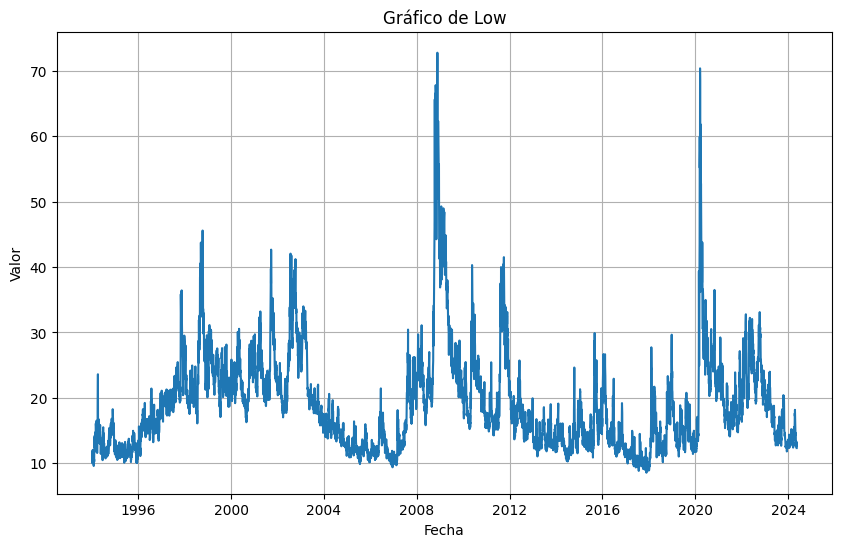

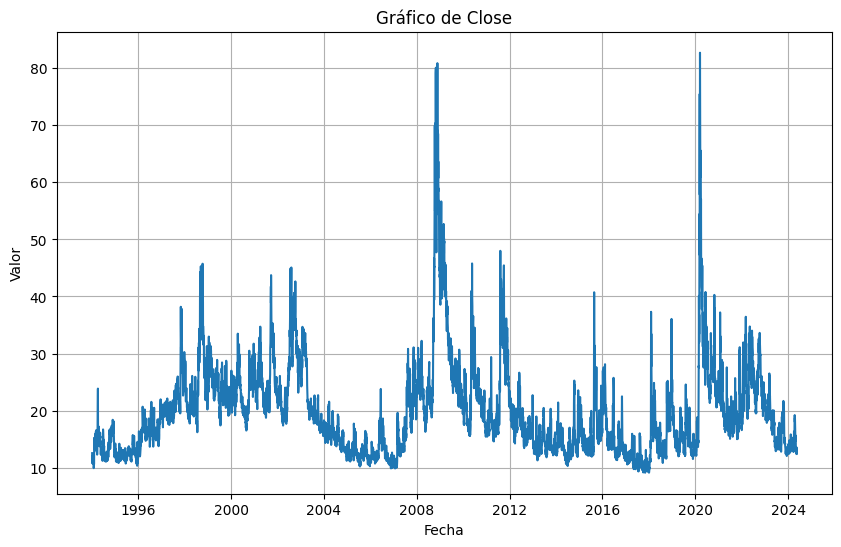

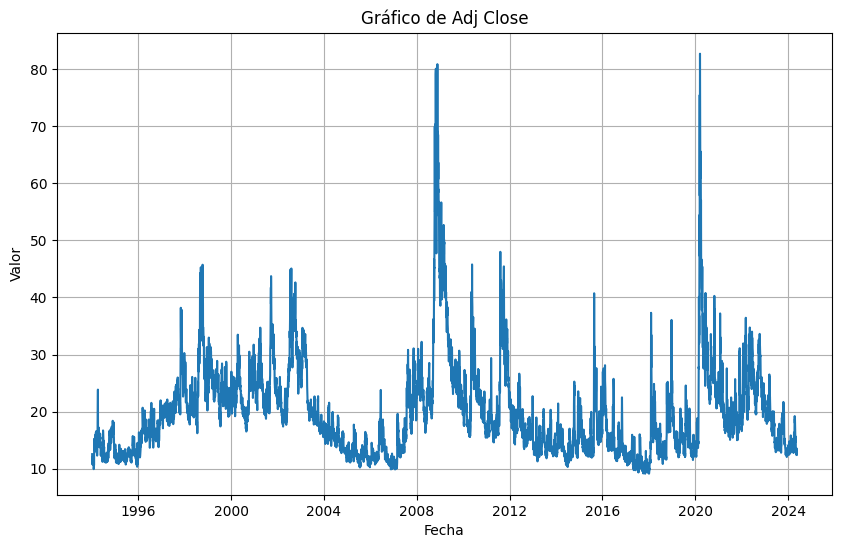

In [246]:
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame resultante
# Iterar sobre cada columna del DataFrame excepto 'Date' y graficarla en un gráfico individual
for column in df.columns:
    if column != 'Date':
        plt.figure(figsize=(10, 6))  # Configurar el tamaño del gráfico
        plt.plot(df['Date'], df[column])  # Graficar la columna contra 'Date'
        plt.title(f'Gráfico de {column}')  # Configurar el título
        plt.xlabel('Fecha')  # Configurar la etiqueta del eje x
        plt.ylabel('Valor')  # Configurar la etiqueta del eje y
        plt.grid(True)  # Mostrar rejilla
        plt.show()  # Mostrar el gráfico

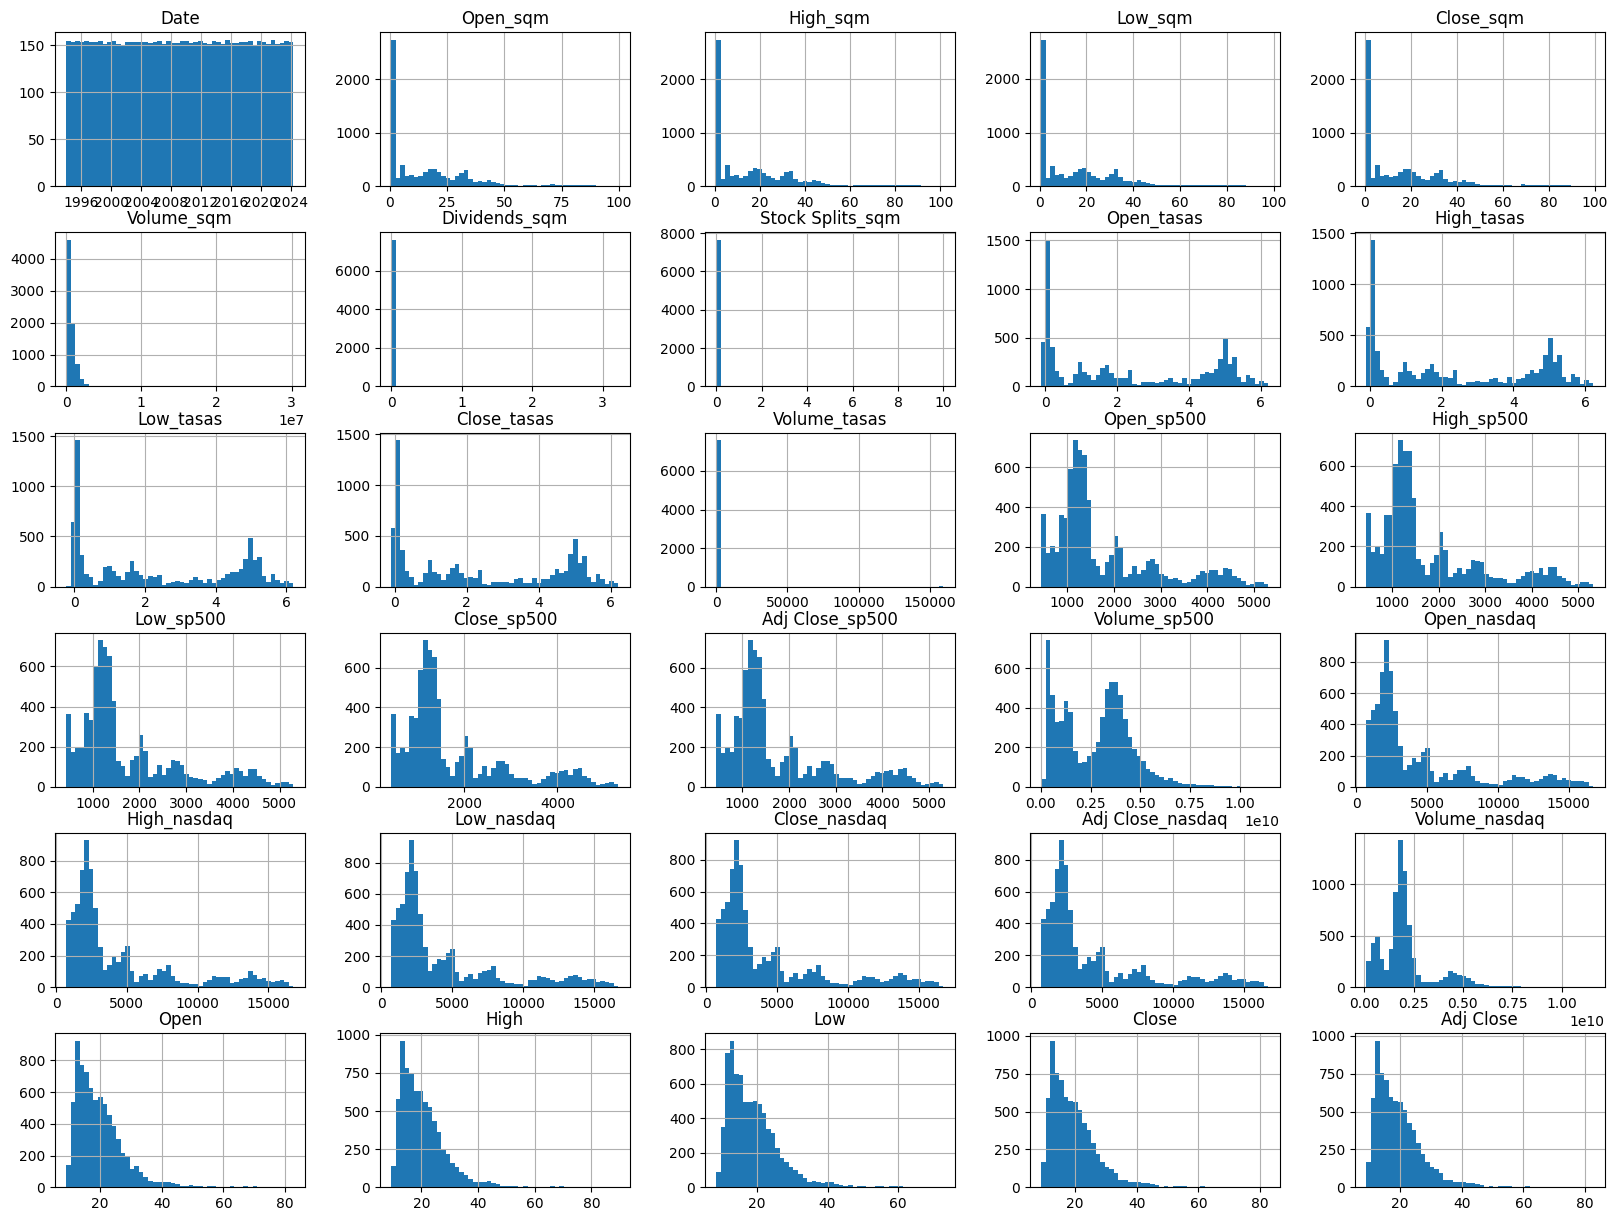

In [247]:
# Histogramas para variables numéricas
df.hist(bins=50, figsize=(20,15))
plt.show()

In [248]:
import numpy as np
# Suponiendo que df es tu DataFrame
columns_to_transform = ['Open_sqm', 'High_sqm', 'Low_sqm', 'Close_sqm', 'Volume_sqm',
                         'Dividends_sqm', 'Stock Splits_sqm', 'Open_tasas', 'High_tasas',
                         'Low_tasas', 'Close_tasas', 'Volume_tasas', 'Open_sp500',
                         'High_sp500', 'Low_sp500', 'Close_sp500', 'Adj Close_sp500',
                         'Volume_sp500', 'Open_nasdaq', 'High_nasdaq', 'Low_nasdaq',
                         'Close_nasdaq', 'Adj Close_nasdaq', 'Volume_nasdaq', 'Open',
                         'High', 'Low', 'Close', 'Adj Close']

df[columns_to_transform] = df[columns_to_transform].apply(lambda x: np.log1p(x))

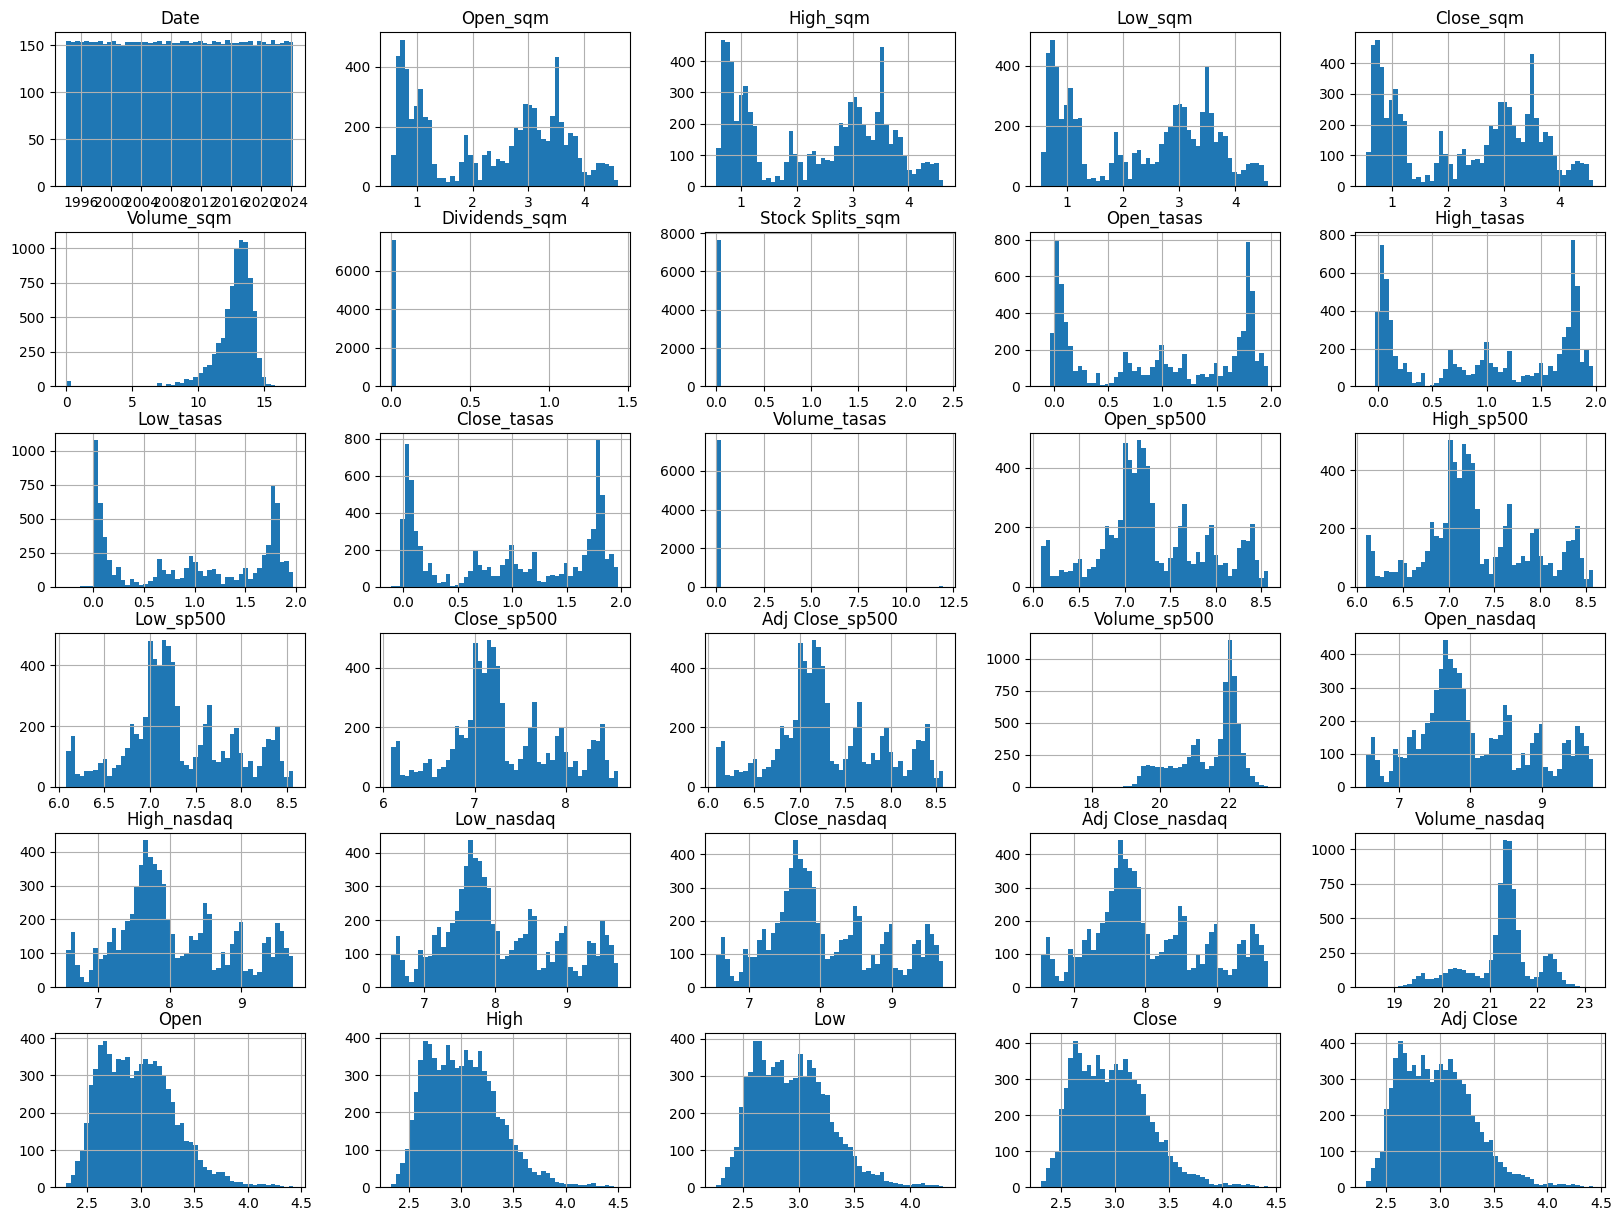

In [249]:
# Histogramas para variables numéricas
df.hist(bins=50, figsize=(20,15))
plt.show()

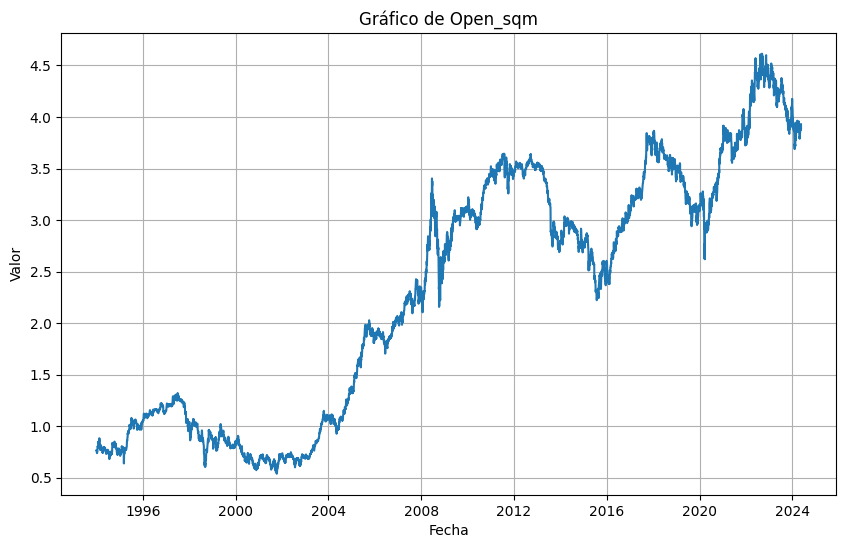

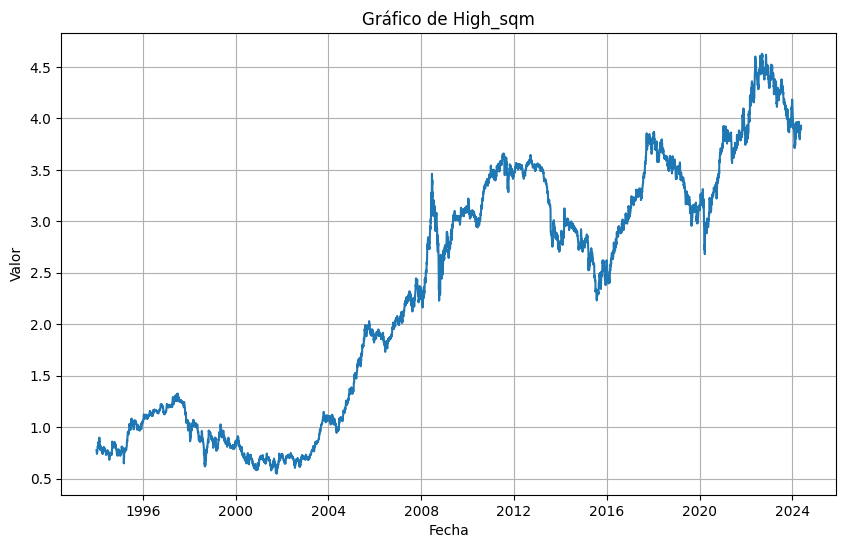

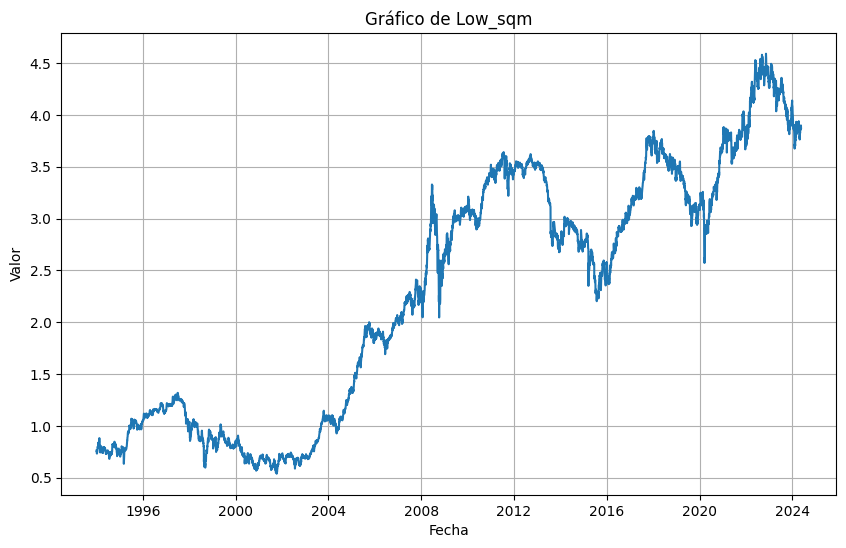

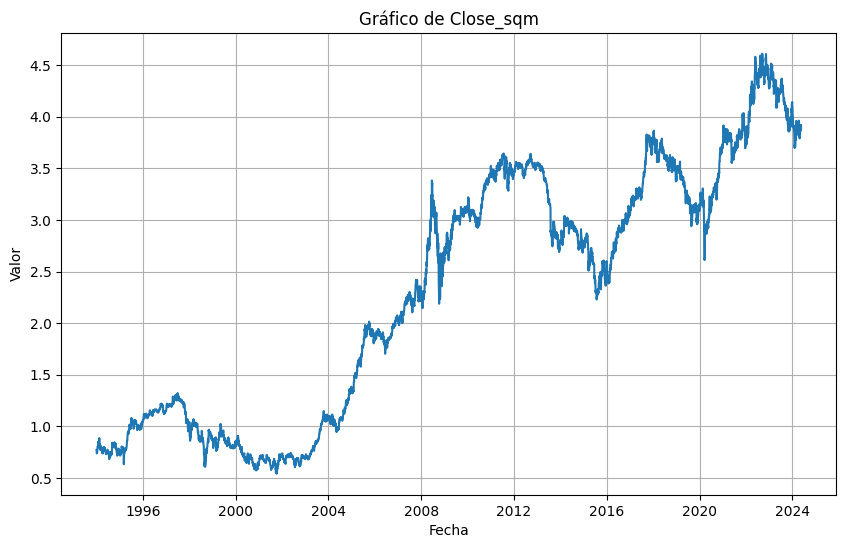

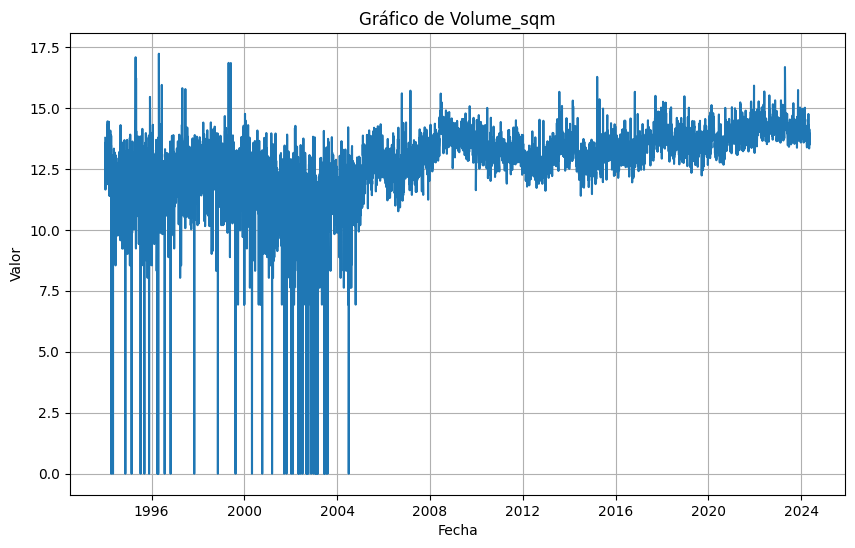

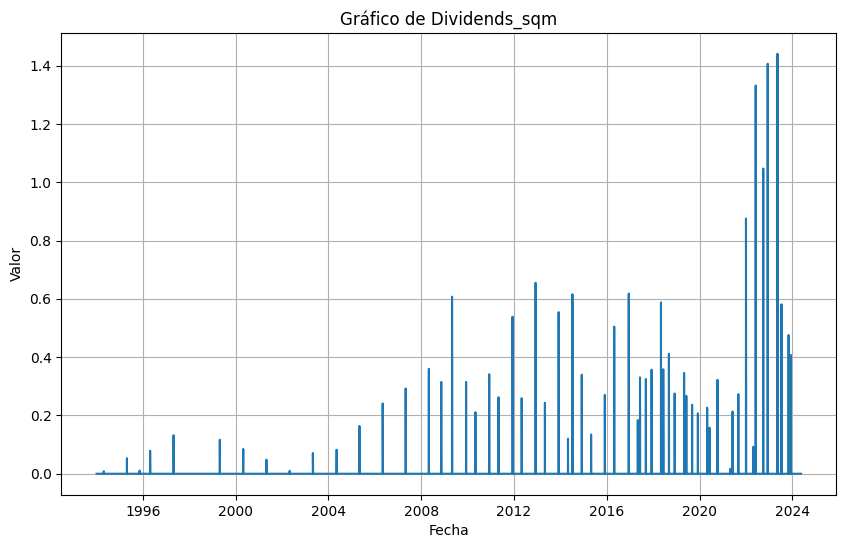

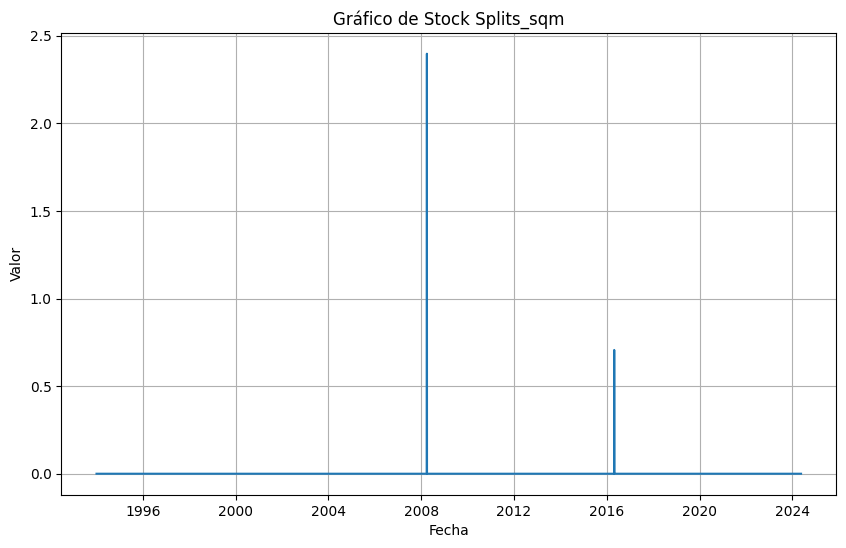

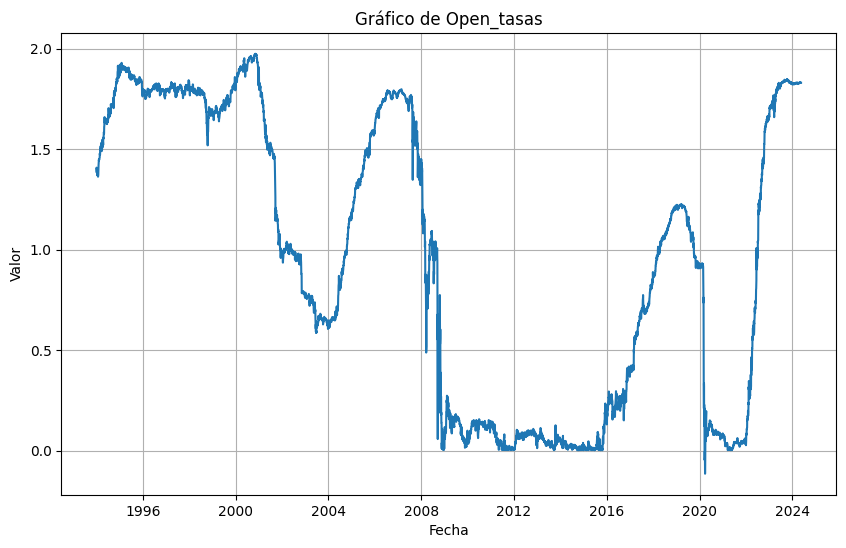

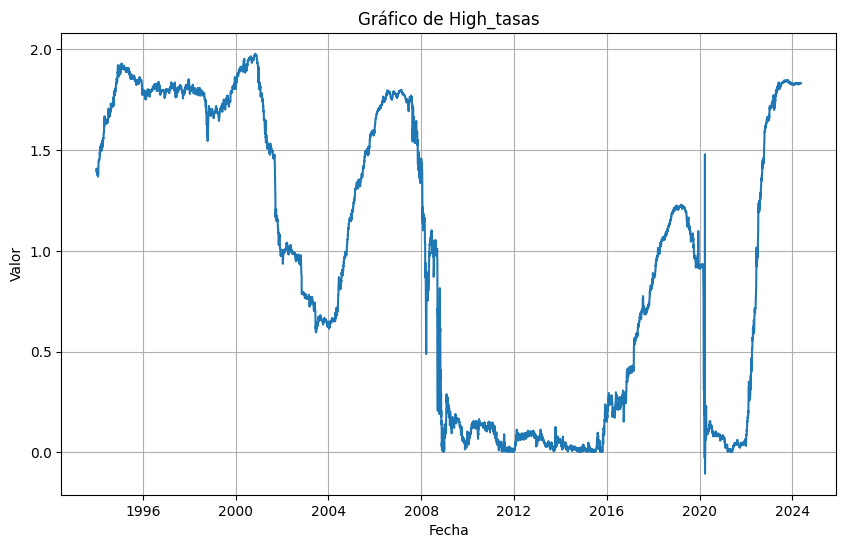

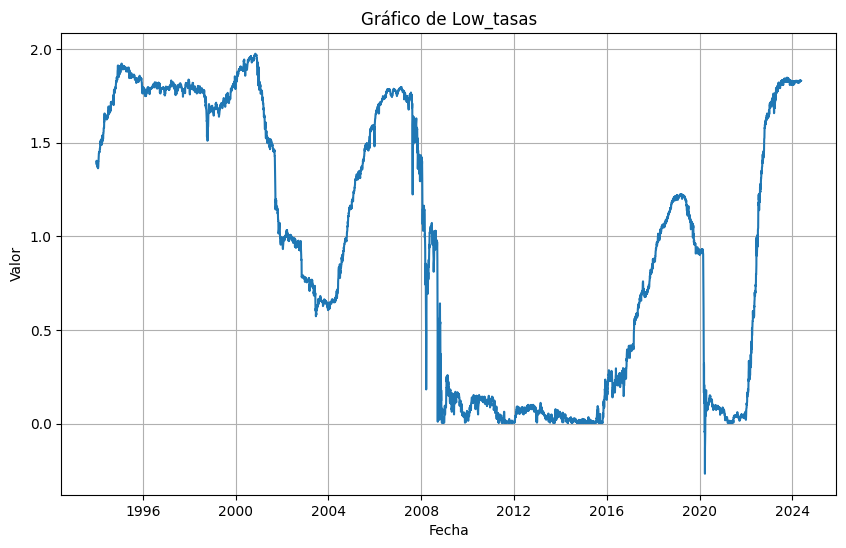

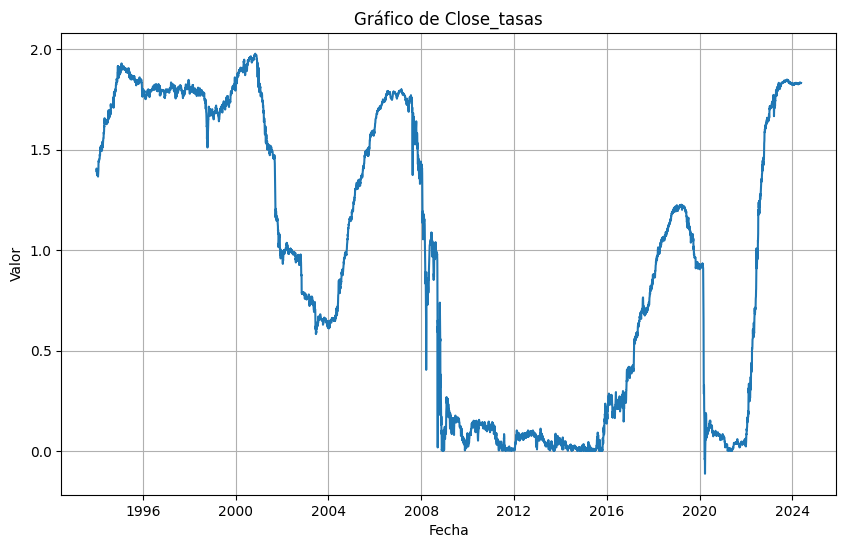

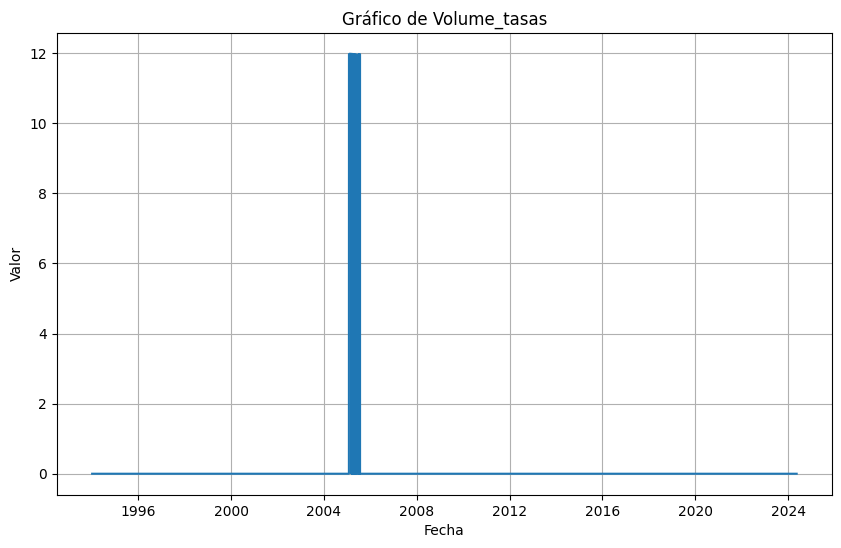

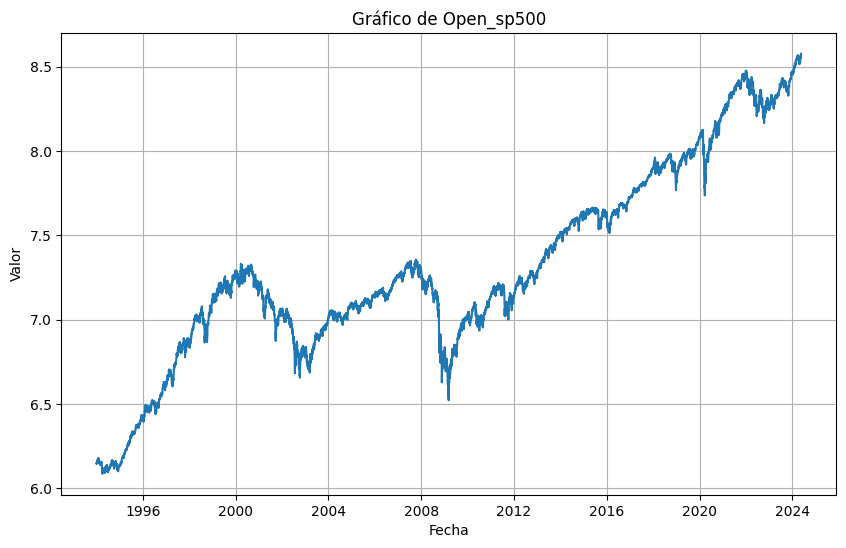

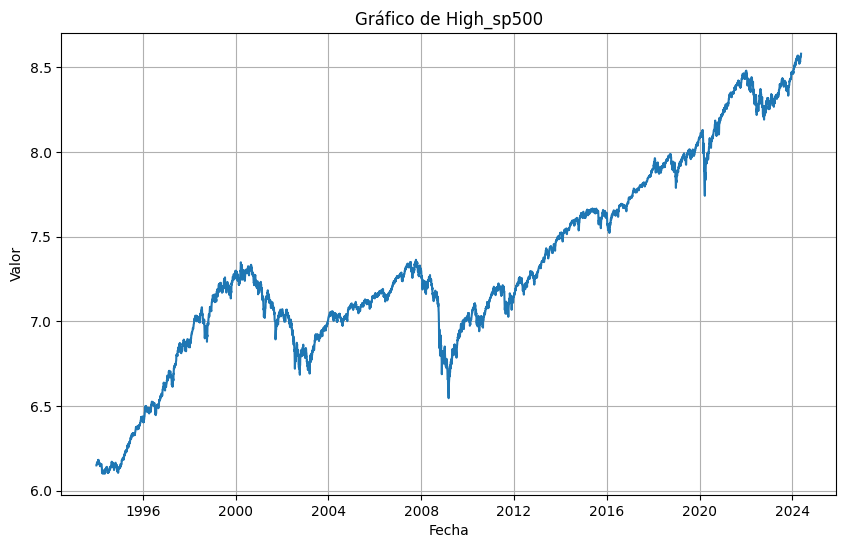

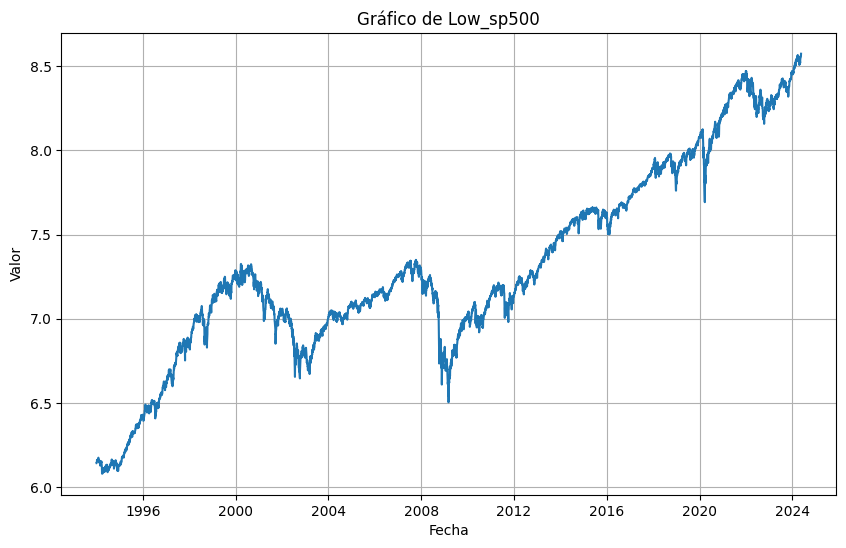

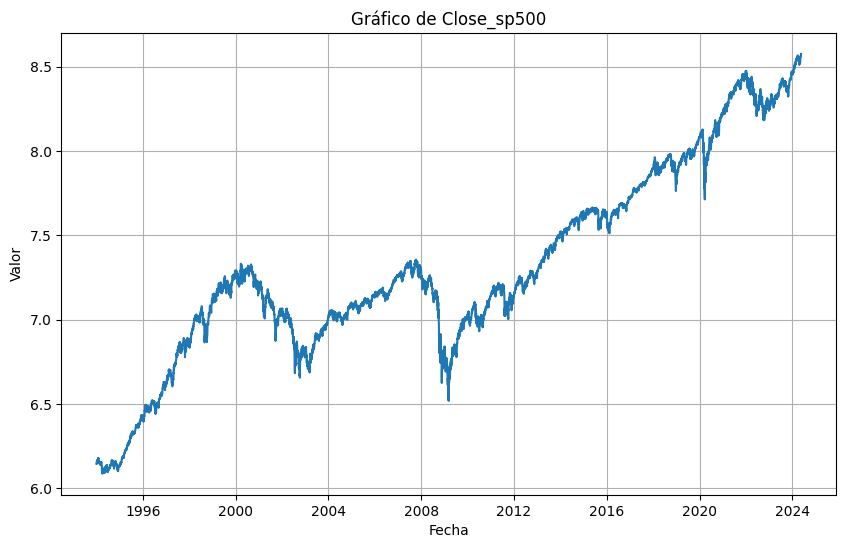

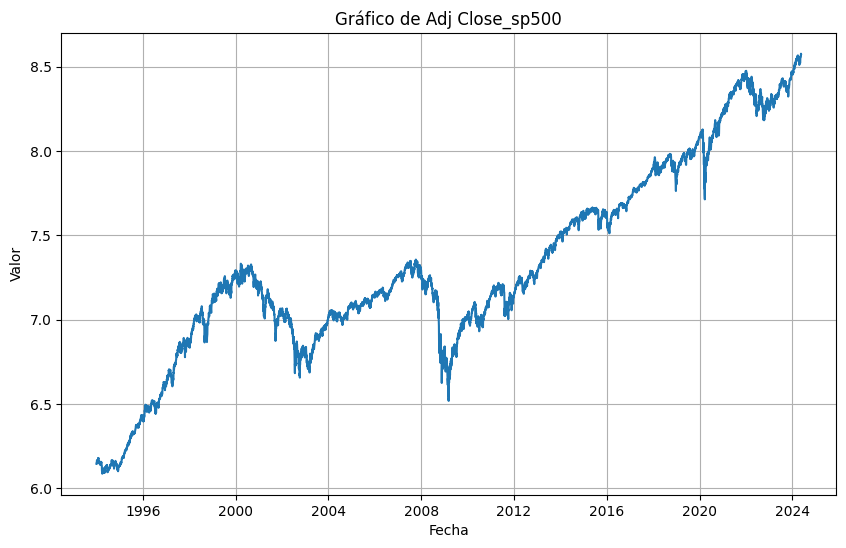

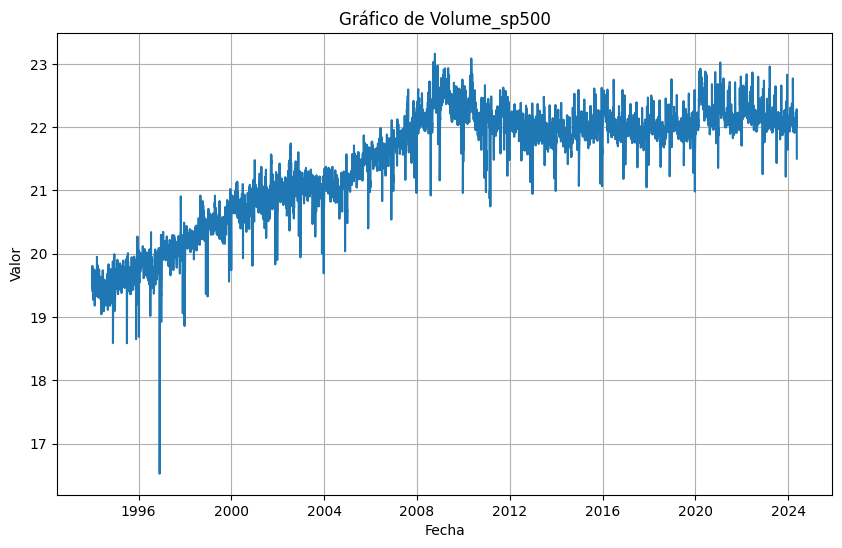

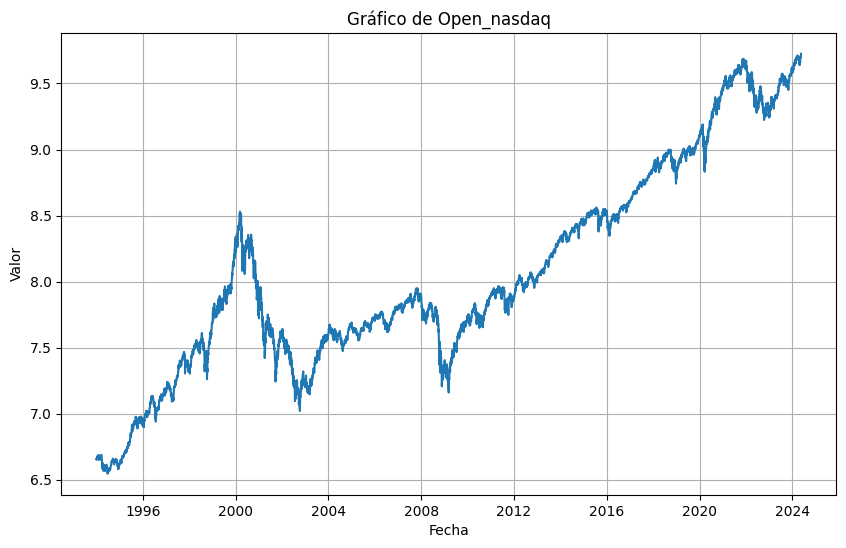

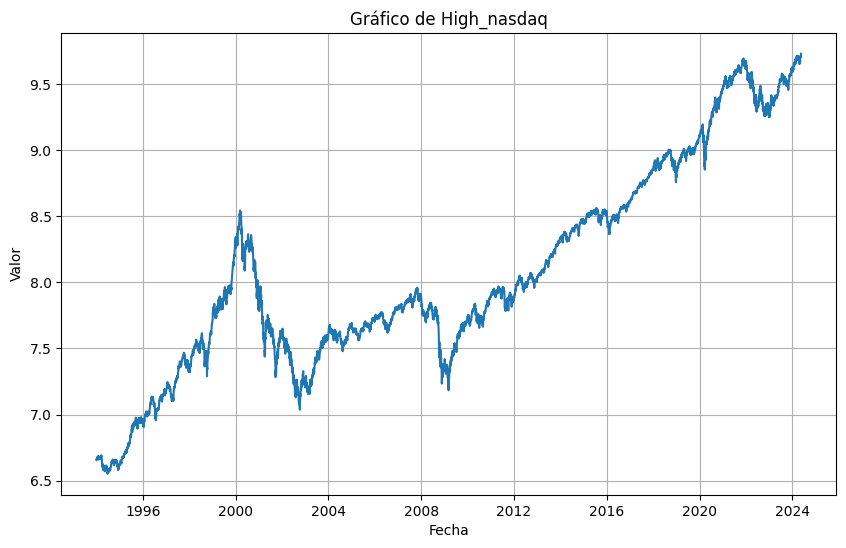

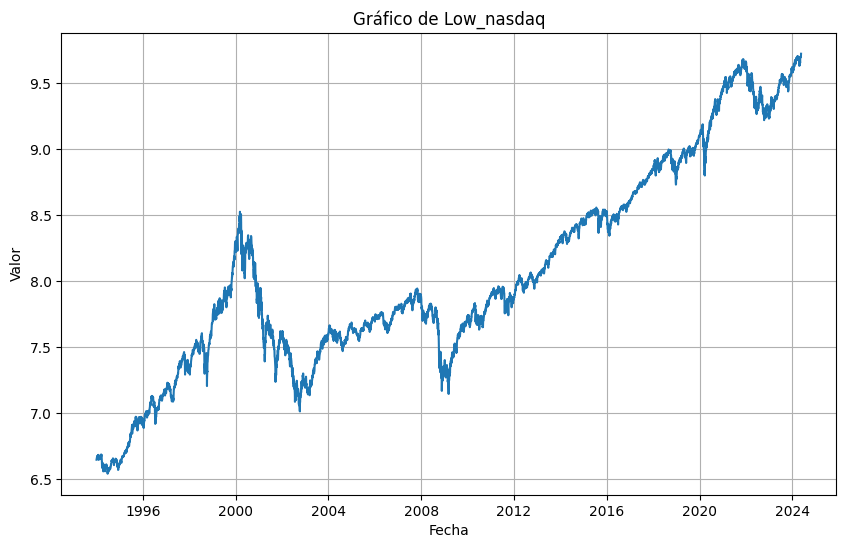

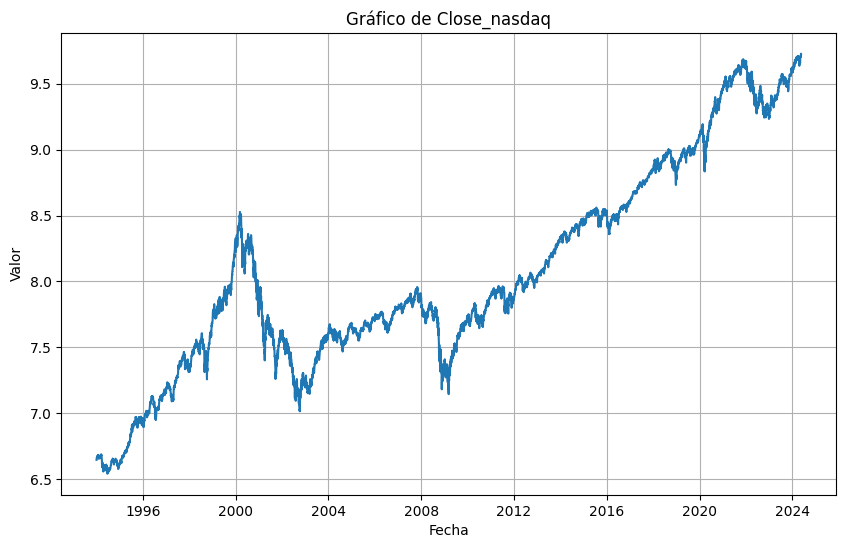

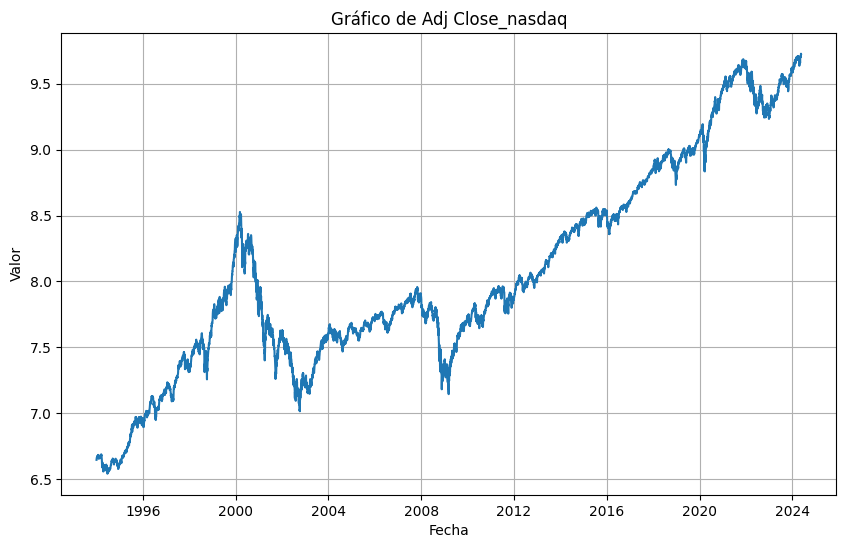

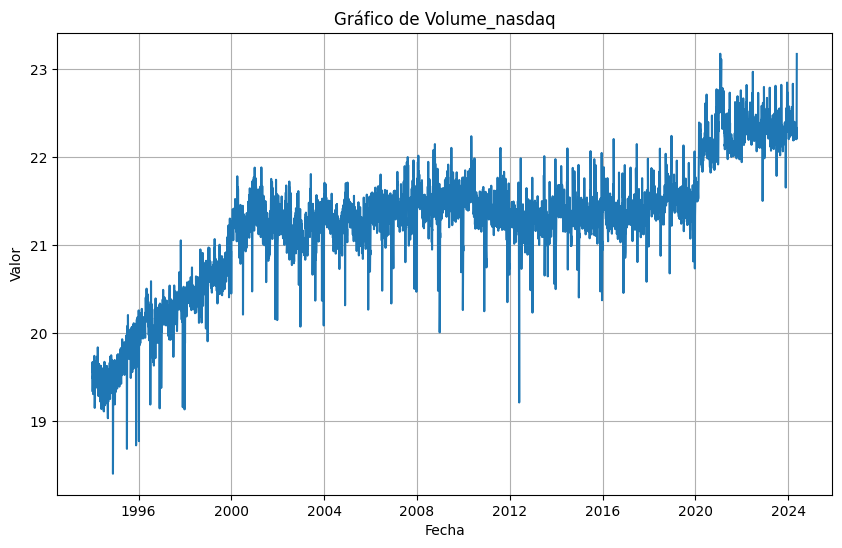

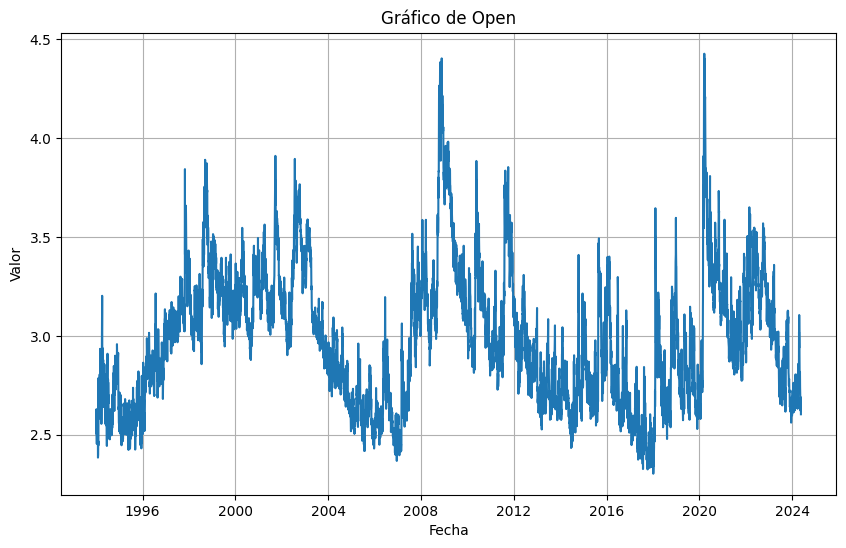

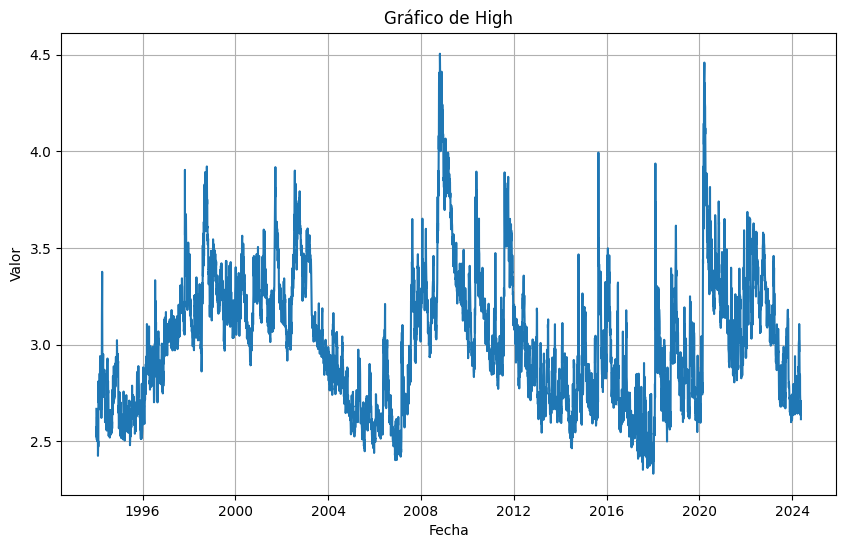

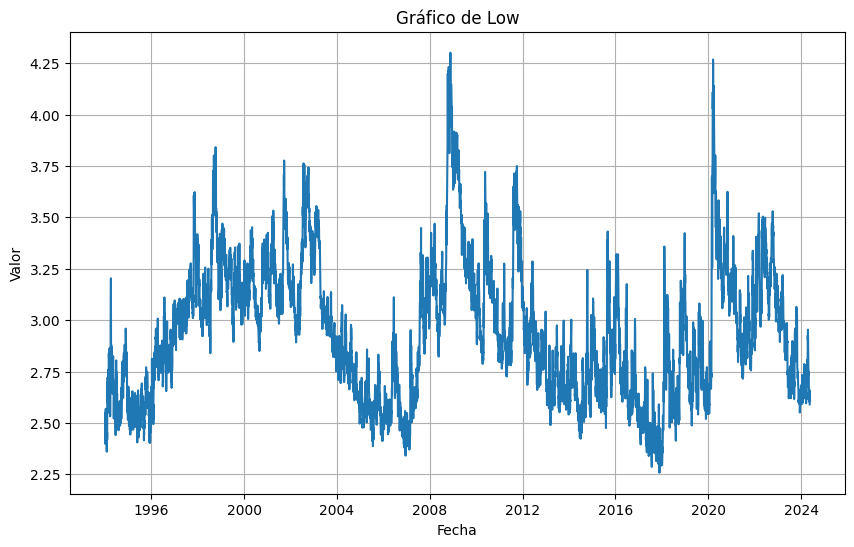

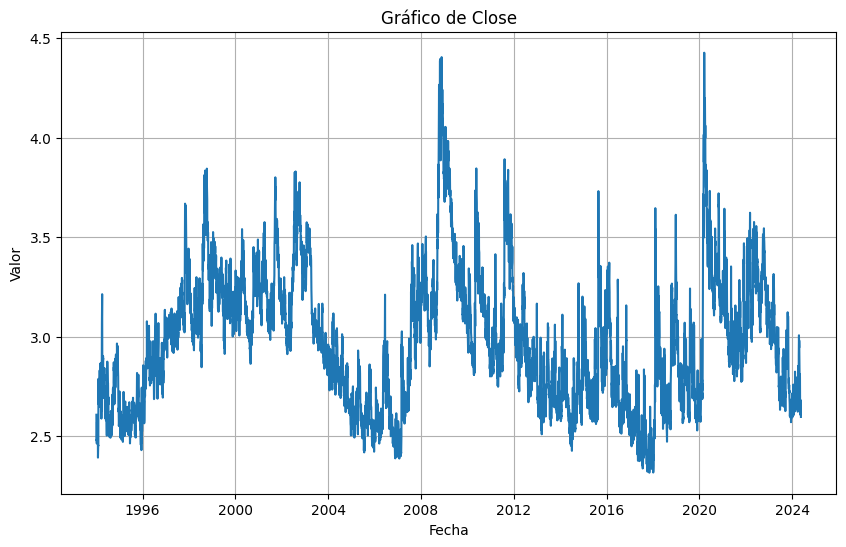

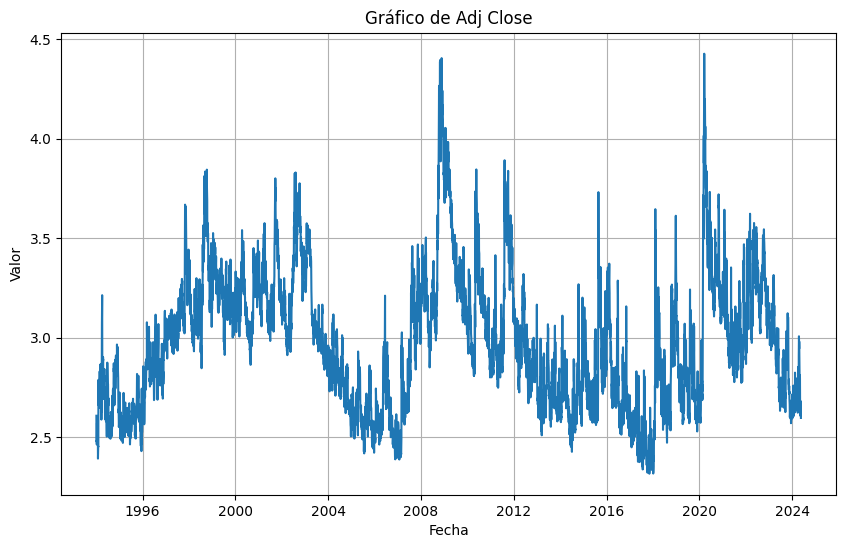

In [250]:
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame resultante
# Iterar sobre cada columna del DataFrame excepto 'Date' y graficarla en un gráfico individual
for column in df.columns:
    if column != 'Date':
        plt.figure(figsize=(10, 6))  # Configurar el tamaño del gráfico
        plt.plot(df['Date'], df[column])  # Graficar la columna contra 'Date'
        plt.title(f'Gráfico de {column}')  # Configurar el título
        plt.xlabel('Fecha')  # Configurar la etiqueta del eje x
        plt.ylabel('Valor')  # Configurar la etiqueta del eje y
        plt.grid(True)  # Mostrar rejilla
        plt.show()  # Mostrar el gráfico

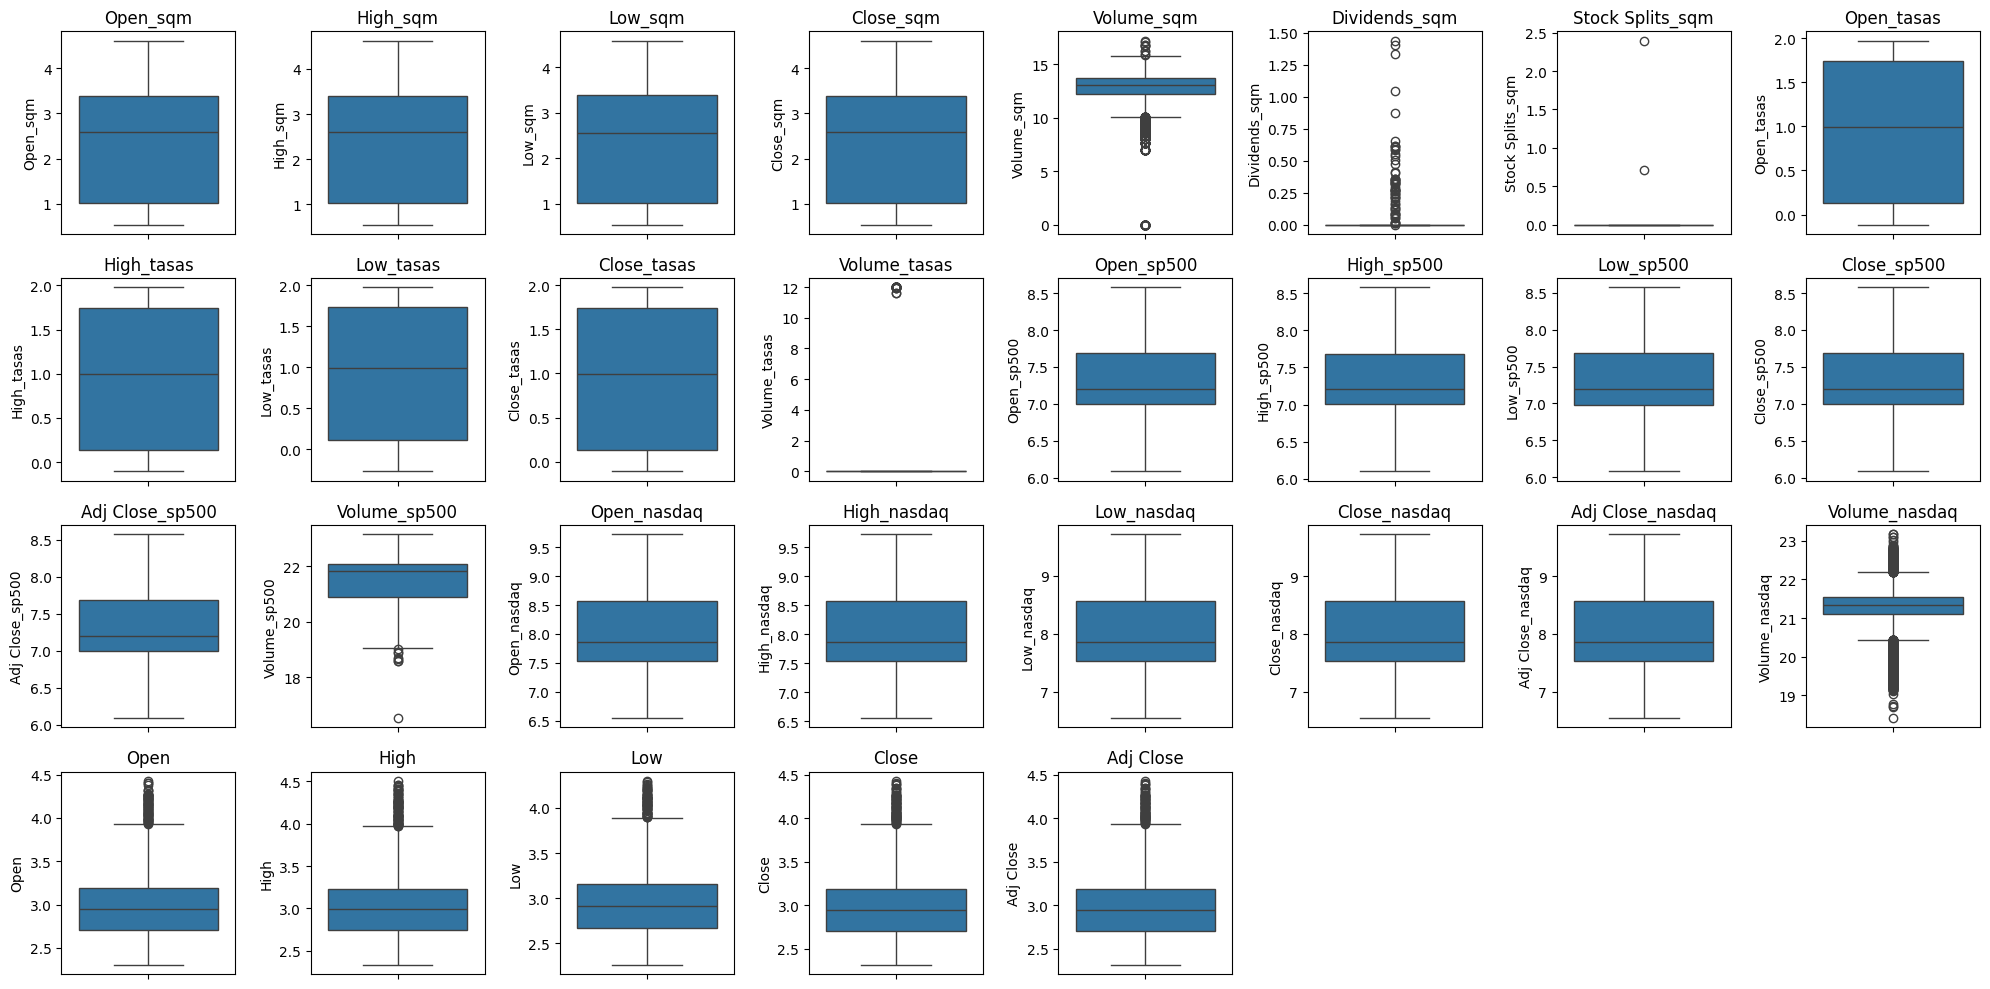

In [251]:
import seaborn as sns

# Lista de variables a graficar
variables = ['Open_sqm', 'High_sqm', 'Low_sqm', 'Close_sqm', 'Volume_sqm',
             'Dividends_sqm', 'Stock Splits_sqm', 'Open_tasas', 'High_tasas',
             'Low_tasas', 'Close_tasas', 'Volume_tasas', 'Open_sp500',
             'High_sp500', 'Low_sp500', 'Close_sp500', 'Adj Close_sp500',
             'Volume_sp500', 'Open_nasdaq', 'High_nasdaq', 'Low_nasdaq',
             'Close_nasdaq', 'Adj Close_nasdaq', 'Volume_nasdaq', 'Open',
             'High', 'Low', 'Close', 'Adj Close']

plt.figure(figsize=(20, 10))

for i, var in enumerate(variables):
    plt.subplot(4, 8, i + 1)
    sns.boxplot(y=df[var])
    plt.title(var)

plt.tight_layout()
plt.show()


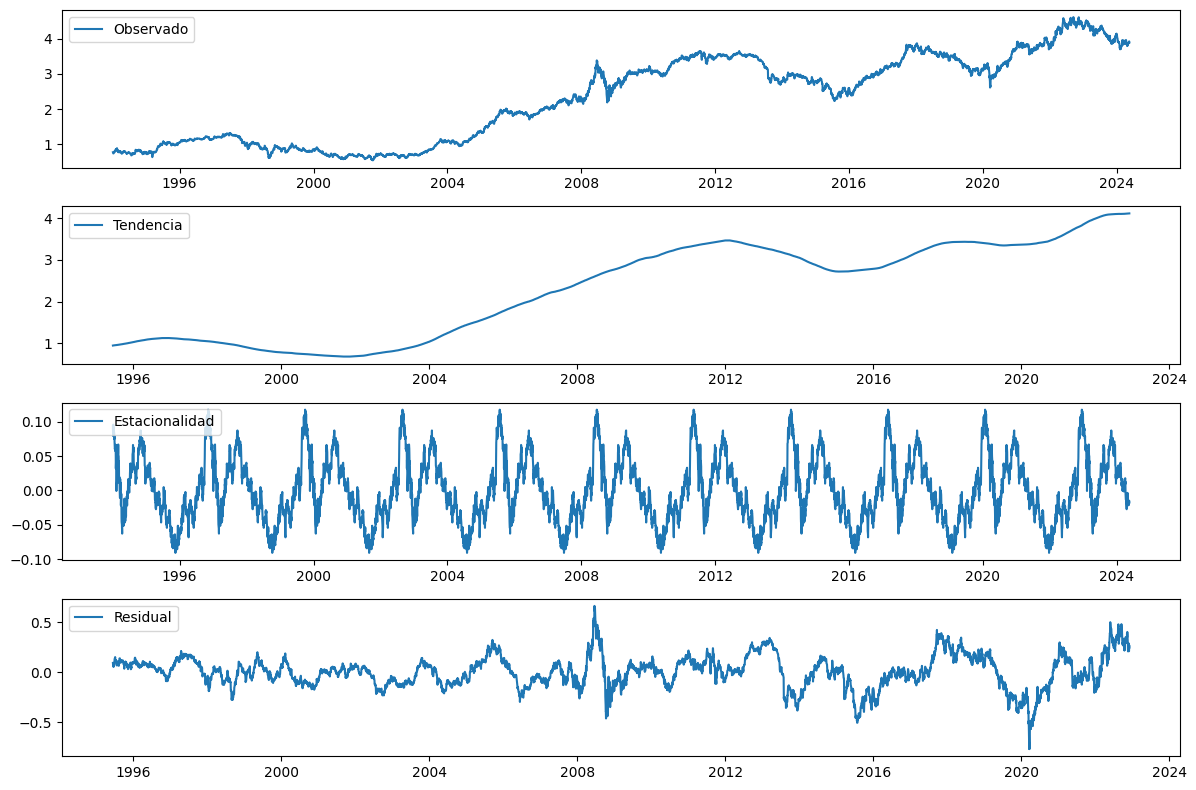

In [252]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Suponiendo que 'Close' es la columna que contiene tus datos de precios de cierre
# y que 'Date' es tu índice de fecha
df.index = df['Date']

# Descomposición de la serie temporal
result = seasonal_decompose(df['Close_sqm'], model='additive', period=730)  # Se asume un período de estacionalidad de 30 días

# Visualización de la descomposición
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [253]:
result.resid.mean()

0.005402351089412313

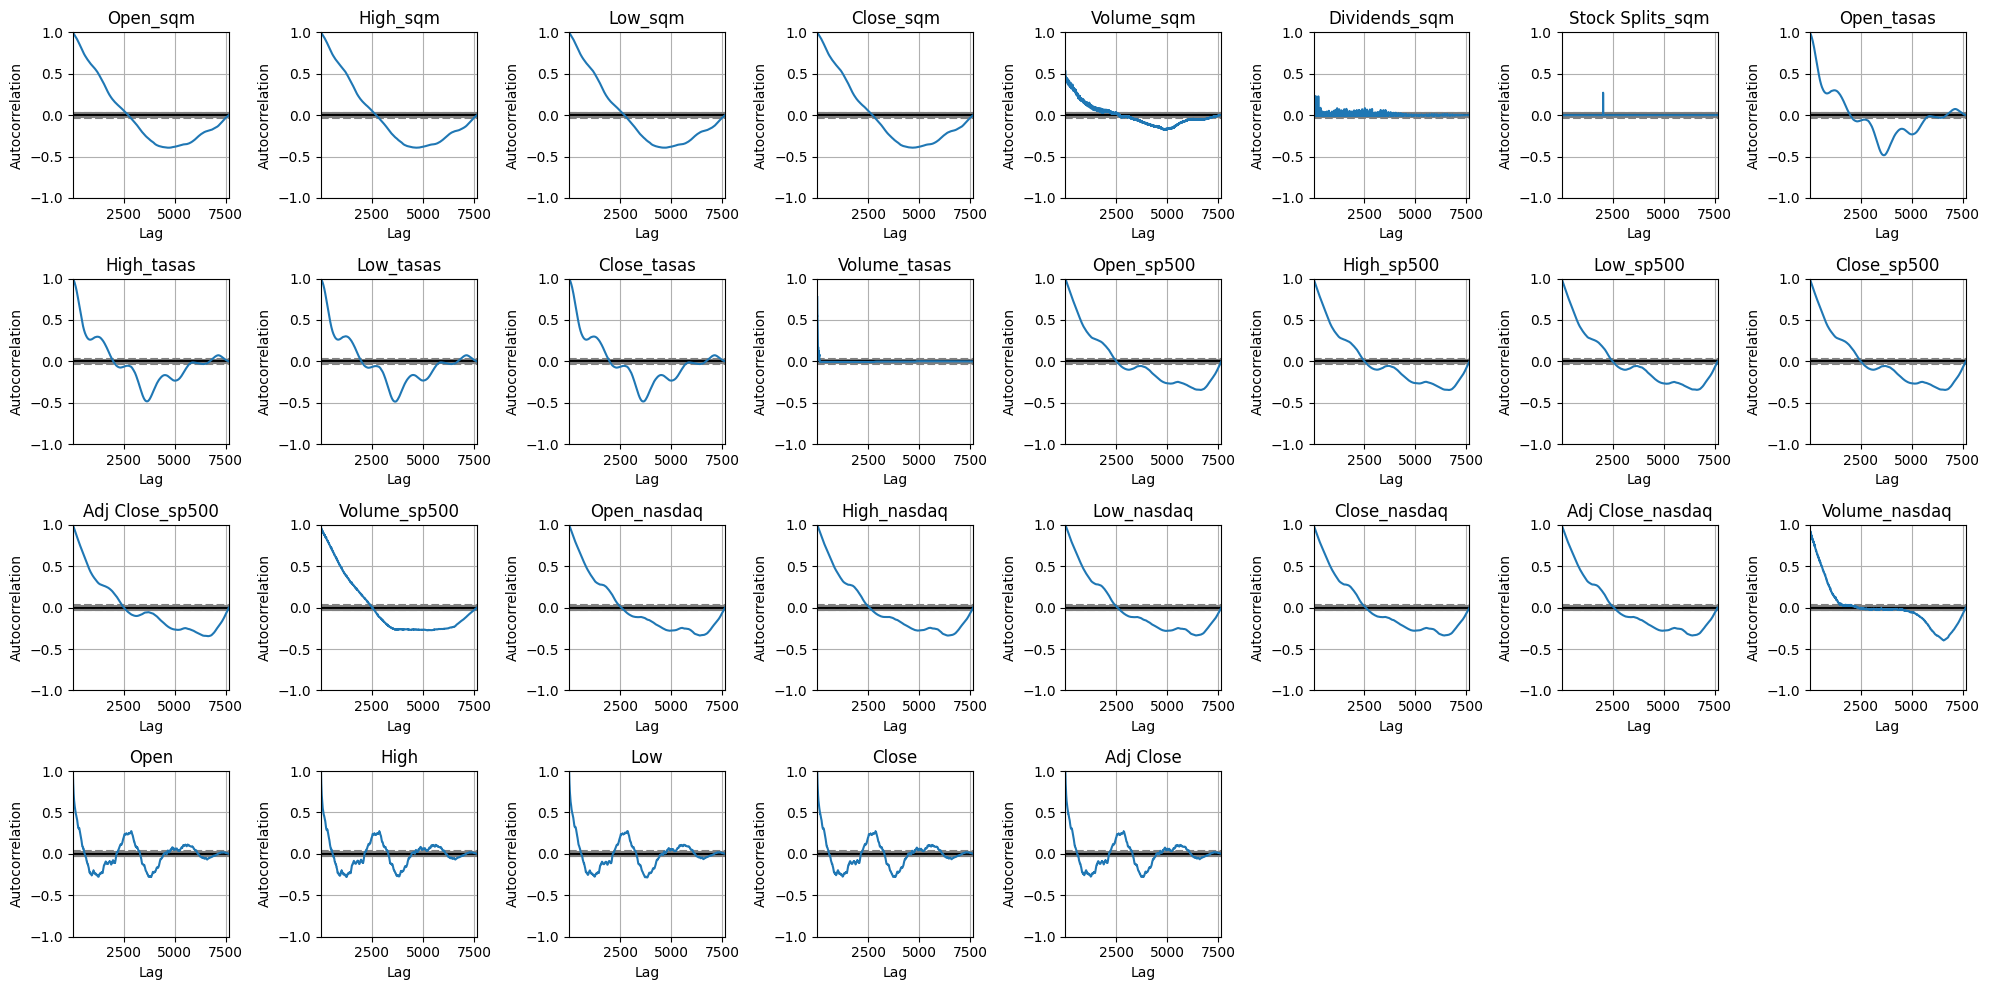

In [254]:
from pandas.plotting import autocorrelation_plot

# Lista de variables a analizar la autocorrelación
variables = ['Open_sqm', 'High_sqm', 'Low_sqm', 'Close_sqm', 'Volume_sqm',
             'Dividends_sqm', 'Stock Splits_sqm', 'Open_tasas', 'High_tasas',
             'Low_tasas', 'Close_tasas', 'Volume_tasas', 'Open_sp500',
             'High_sp500', 'Low_sp500', 'Close_sp500', 'Adj Close_sp500',
             'Volume_sp500', 'Open_nasdaq', 'High_nasdaq', 'Low_nasdaq',
             'Close_nasdaq', 'Adj Close_nasdaq', 'Volume_nasdaq', 'Open',
             'High', 'Low', 'Close', 'Adj Close']

plt.figure(figsize=(20, 10))

for i, var in enumerate(variables):
    plt.subplot(4, 8, i + 1)
    autocorrelation_plot(df[var])
    plt.title(var)

plt.tight_layout()
plt.show()


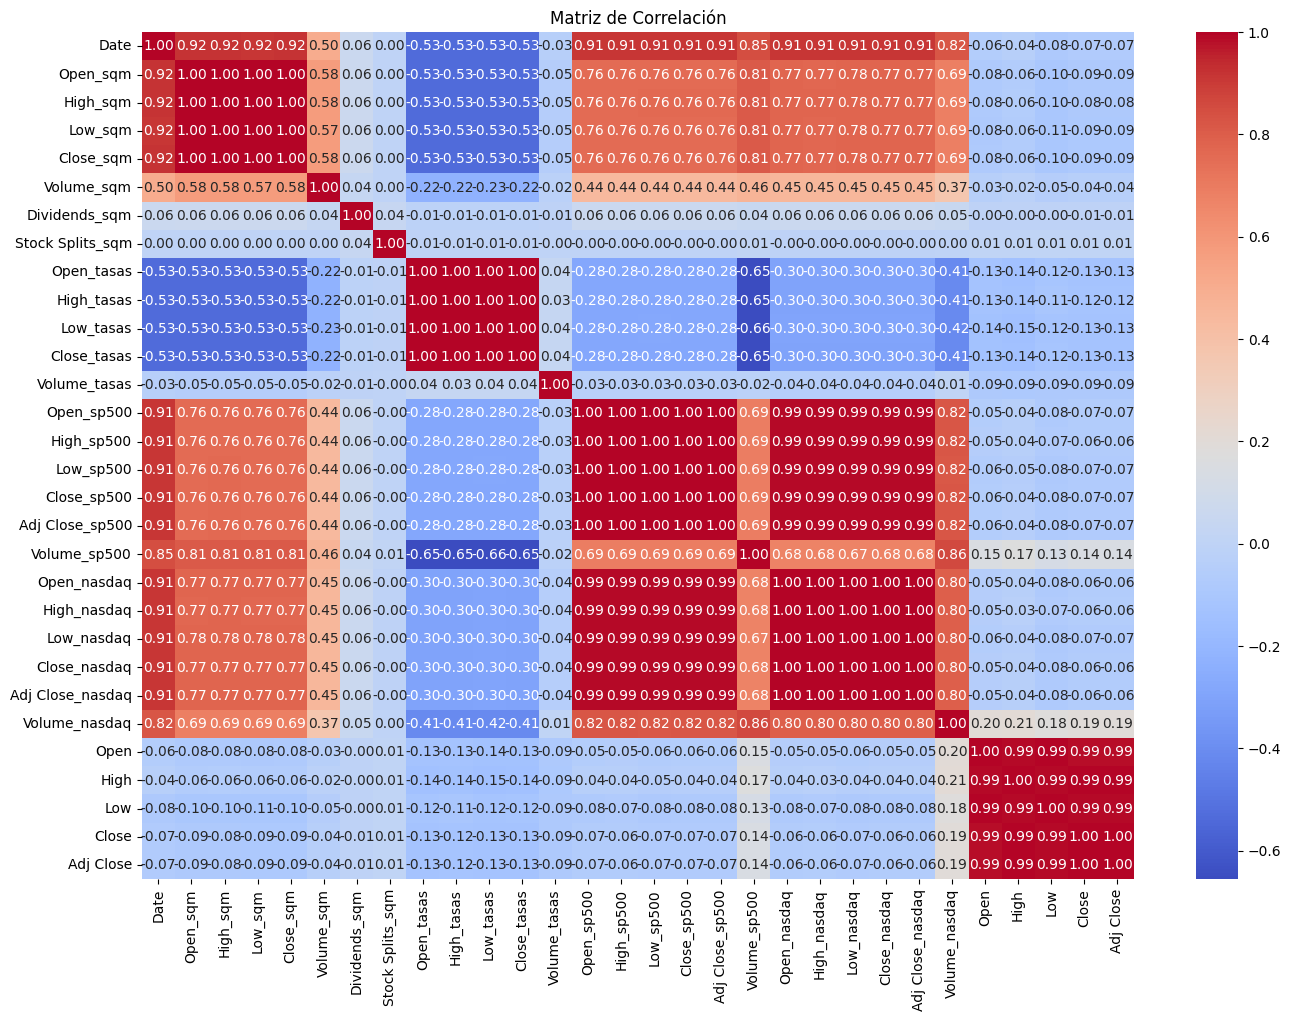

In [255]:
# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(16, 11))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

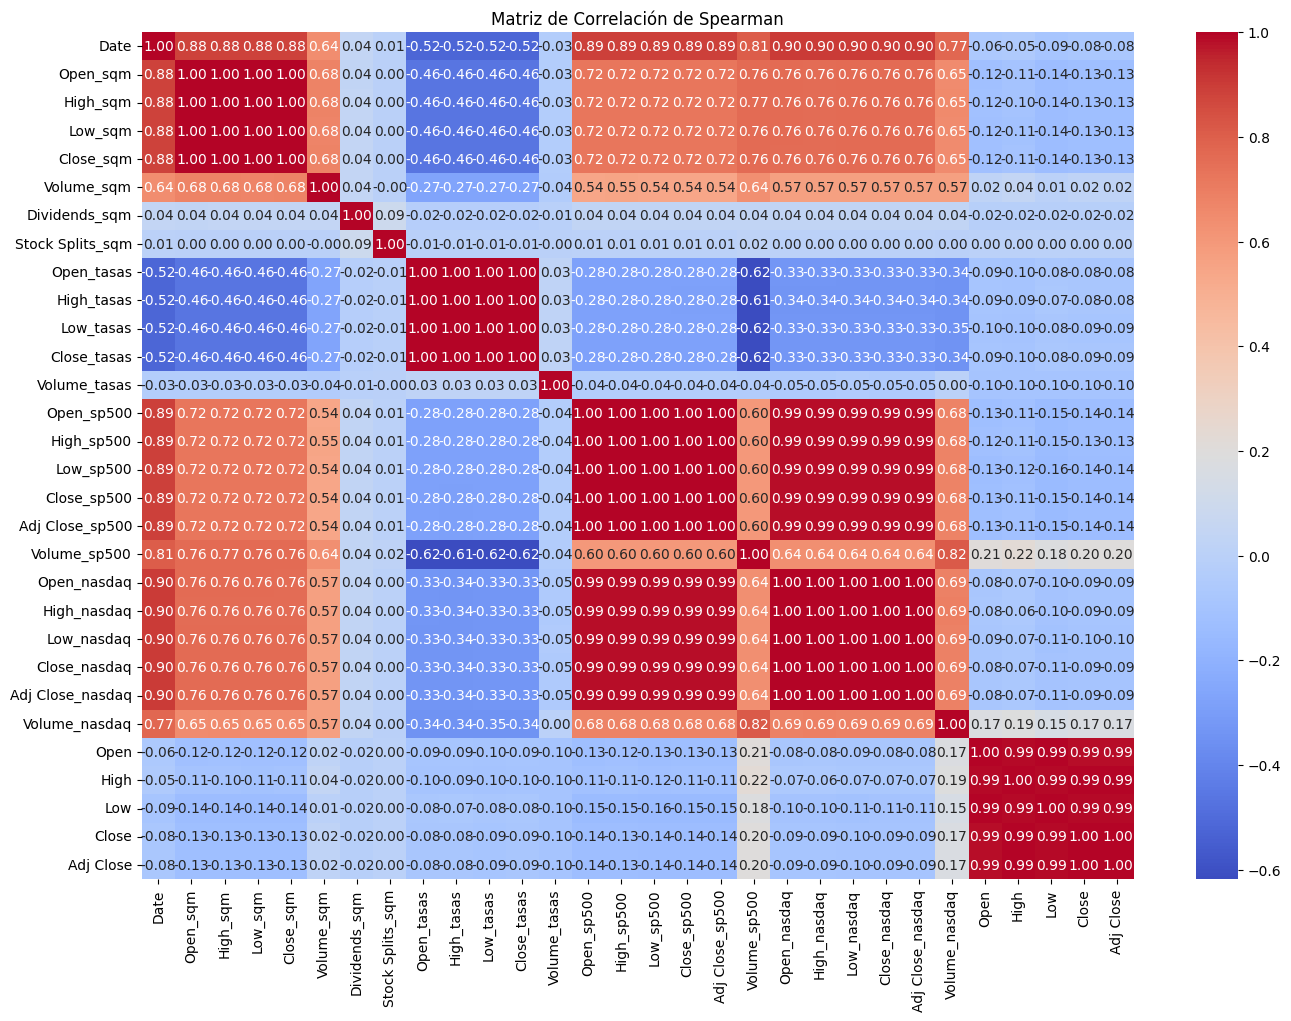

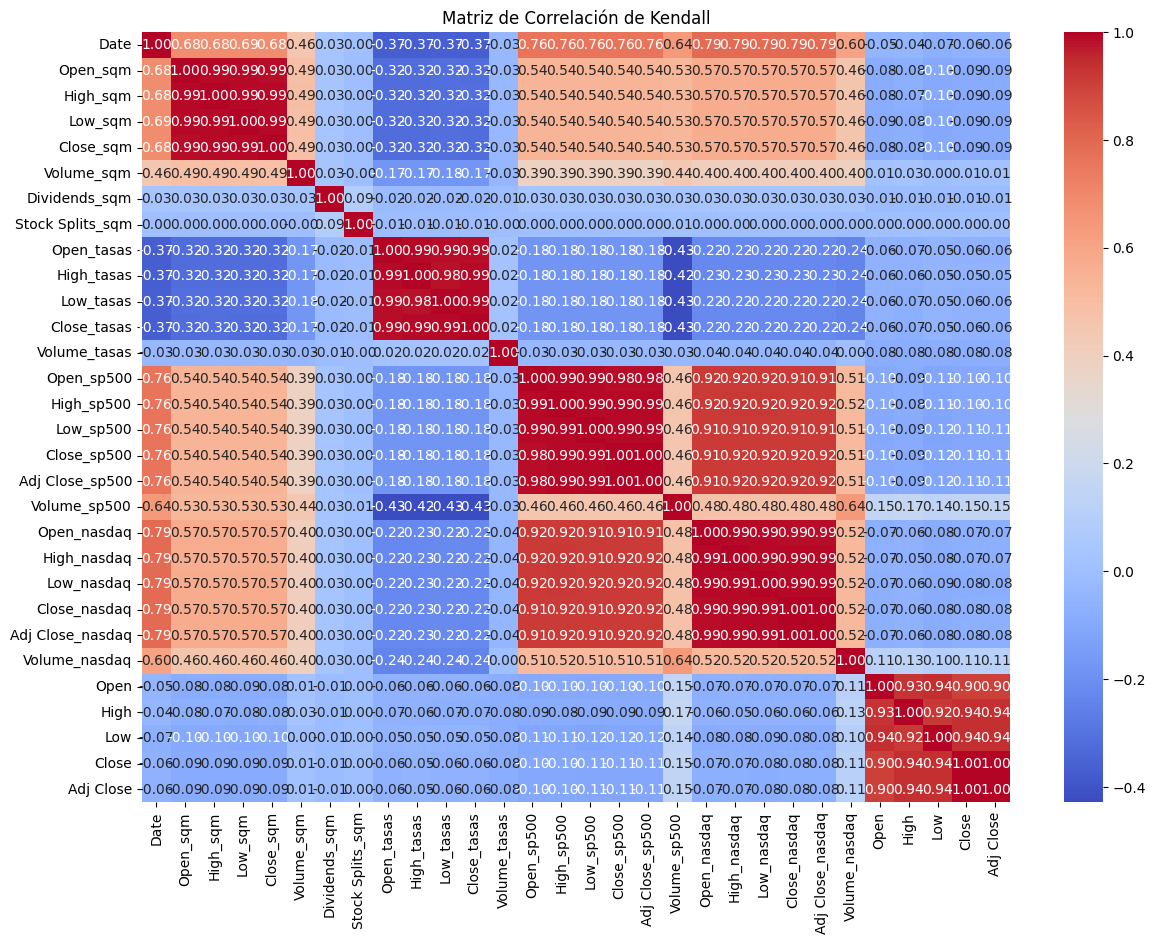

In [256]:
from scipy.stats import spearmanr, kendalltau

# Calcular el coeficiente de correlación de Spearman
spearman_corr = df.corr(method='spearman')

# Calcular el coeficiente de correlación de Kendall
kendall_corr = df.corr(method='kendall')

# Visualizar la matriz de correlación de Spearman como un mapa de calor
plt.figure(figsize=(16, 11))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Spearman')
plt.show()

# Visualizar la matriz de correlación de Kendall como un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Kendall')
plt.show()


In [257]:
df.head()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
Date                                                                         
1994-01-03 1994-01-03  0.766340  0.777430  0.761870   0.773009   13.774945   
1994-01-04 1994-01-04  0.770791  0.770791  0.761870   0.766340   12.933336   
1994-01-05 1994-01-05  0.766341  0.770791  0.752868   0.764108   13.321278   
1994-01-06 1994-01-06  0.766340  0.766340  0.750605   0.750605   11.652905   
1994-01-07 1994-01-07  0.750605  0.750605  0.739211   0.739211   12.295694   

            Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  \
Date                                                                  
1994-01-03            0.0               0.0    1.388791    1.396245   
1994-01-04            0.0               0.0    1.408545    1.408545   
1994-01-05            0.0               0.0    1.406097    1.406097   
1994-01-06            0.0               0.0    1.401183    1.401183   
1994-01-07            0.0               0.0    1.396245    1.396245   

            Low_tasas  Close_tasas  Volume_tasas  Open_sp500  High_sp500  \
Date                                                                       
1994-01-03   1.388791     1.393766           0.0    6.147421    6.148340   
1994-01-04   1.403643     1.406097           0.0    6.145129    6.148233   
1994-01-05   1.401183     1.403643           0.0    6.148233    6.150219   
1994-01-06   1.396245     1.398717           0.0    6.149643    6.152733   
1994-01-07   1.388791     1.388791           0.0    6.148661    6.155410   

            Low_sp500  Close_sp500  Adj Close_sp500  Volume_sp500  \
Date                                                                
1994-01-03   6.142811     6.145129         6.145129     19.414451   
1994-01-04   6.142983     6.148233         6.148233     19.604247   
1994-01-05   6.146158     6.149643         6.149643     19.807050   
1994-01-06   6.148511     6.148725         6.148725     19.718035   
1994-01-07   6.148532     6.154646         6.154646     19.599090   

            Open_nasdaq  High_nasdaq  Low_nasdaq  Close_nasdaq  \
Date                                                             
1994-01-03     6.653005     6.657099    6.645624      6.648674   
1994-01-04     6.649541     6.653869    6.649010      6.653224   
1994-01-05     6.654449     6.658281    6.652463      6.658075   
1994-01-06     6.661036     6.662123    6.658332      6.661100   
1994-01-07     6.659666     6.664906    6.658268      6.664332   

            Adj Close_nasdaq  Volume_nasdaq      Open      High       Low  \
Date                                                                        
1994-01-03          6.648674      19.348979  2.507972  2.668616  2.507972   
1994-01-04          6.653224      19.514615  2.629728  2.629728  2.550226   
1994-01-05          6.658075      19.673101  2.523326  2.523326  2.430978   
1994-01-06          6.661100      19.671184  2.523326  2.544747  2.428336   
1994-01-07          6.664332      19.614785  2.523326  2.575661  2.397895   

               Close  Adj Close  
Date                             
1994-01-03  2.607861   2.607861  
1994-01-04  2.558002   2.558002  
1994-01-05  2.479894   2.479894  
1994-01-06  2.507157   2.507157  
1994-01-07  2.481568   2.481568

In [258]:
# Suponiendo que tu DataFrame se llame df y que 'Date' es el nombre de la columna
df.reset_index(drop=True, inplace=True)

In [259]:
# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# 3- Desarrollo de modelo predictivo

## 3.1 agregacion de nuevas caracter+isticas,  escalado división de datos en training y testing

In [260]:
# Agregar componentes de la fecha como características
df['Day_of_week'] = df['Date'].dt.dayofweek  # Día de la semana (0 = lunes, 6 = domingo)
df['Month'] = df['Date'].dt.month  # Mes (1 = enero, 12 = diciembre)
df['Year'] = df['Date'].dt.year  # Año

In [261]:
df.head()

Date  Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
0 1994-01-03  0.766340  0.777430  0.761870   0.773009   13.774945   
1 1994-01-04  0.770791  0.770791  0.761870   0.766340   12.933336   
2 1994-01-05  0.766341  0.770791  0.752868   0.764108   13.321278   
3 1994-01-06  0.766340  0.766340  0.750605   0.750605   11.652905   
4 1994-01-07  0.750605  0.750605  0.739211   0.739211   12.295694   

   Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  \
0            0.0               0.0    1.388791    1.396245   1.388791   
1            0.0               0.0    1.408545    1.408545   1.403643   
2            0.0               0.0    1.406097    1.406097   1.401183   
3            0.0               0.0    1.401183    1.401183   1.396245   
4            0.0               0.0    1.396245    1.396245   1.388791   

   Close_tasas  Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
0     1.393766           0.0    6.147421    6.148340   6.142811     6.145129   
1     1.406097           0.0    6.145129    6.148233   6.142983     6.148233   
2     1.403643           0.0    6.148233    6.150219   6.146158     6.149643   
3     1.398717           0.0    6.149643    6.152733   6.148511     6.148725   
4     1.388791           0.0    6.148661    6.155410   6.148532     6.154646   

   Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  Low_nasdaq  \
0         6.145129     19.414451     6.653005     6.657099    6.645624   
1         6.148233     19.604247     6.649541     6.653869    6.649010   
2         6.149643     19.807050     6.654449     6.658281    6.652463   
3         6.148725     19.718035     6.661036     6.662123    6.658332   
4         6.154646     19.599090     6.659666     6.664906    6.658268   

   Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq      Open      High  \
0      6.648674          6.648674      19.348979  2.507972  2.668616   
1      6.653224          6.653224      19.514615  2.629728  2.629728   
2      6.658075          6.658075      19.673101  2.523326  2.523326   
3      6.661100          6.661100      19.671184  2.523326  2.544747   
4      6.664332          6.664332      19.614785  2.523326  2.575661   

        Low     Close  Adj Close  Day_of_week  Month  Year  
0  2.507972  2.607861   2.607861            0      1  1994  
1  2.550226  2.558002   2.558002            1      1  1994  
2  2.430978  2.479894   2.479894            2      1  1994  
3  2.428336  2.507157   2.507157            3      1  1994  
4  2.397895  2.481568   2.481568            4      1  1994

In [262]:
from sklearn.preprocessing import MinMaxScaler

# Suponiendo que "df" es tu DataFrame
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.select_dtypes(include=[np.number]))
df_scaled = pd.DataFrame(df_scaled, columns=df.select_dtypes(include=[np.number]).columns)
df = pd.concat([df['Date'], df_scaled], axis=1)

In [263]:
df.set_index('Date', inplace = True)

In [264]:
df.describe()

Open_sqm     High_sqm      Low_sqm    Close_sqm   Volume_sqm  \
count  7647.000000  7647.000000  7647.000000  7647.000000  7647.000000   
mean      0.434550     0.434320     0.434166     0.434491     0.741104   
std       0.296611     0.297219     0.296786     0.296915     0.092736   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.119386     0.118265     0.119185     0.119216     0.711313   
50%       0.500718     0.502654     0.499026     0.500804     0.758769   
75%       0.701255     0.701028     0.701798     0.701006     0.794643   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       Dividends_sqm  Stock Splits_sqm   Open_tasas   High_tasas    Low_tasas  \
count    7647.000000       7647.000000  7647.000000  7647.000000  7647.000000   
mean        0.001943          0.000169     0.516602     0.516086     0.547004   
std         0.029273          0.011921     0.345425     0.346201     0.322256   
min         0.000000          0.000000     0.000000     0.000000     0.000000   
25%         0.000000          0.000000     0.115287     0.113452     0.173101   
50%         0.000000          0.000000     0.531754     0.530809     0.560511   
75%         0.000000          0.000000     0.889598     0.889866     0.895127   
max         1.000000          1.000000     1.000000     1.000000     1.000000   

       Close_tasas  Volume_tasas   Open_sp500   High_sp500    Low_sp500  \
count  7647.000000   7647.000000  7647.000000  7647.000000  7647.000000   
mean      0.515088      0.005872     0.492865     0.492210     0.492244   
std       0.345968      0.076327     0.233223     0.233948     0.232957   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.113788      0.000000     0.364447     0.363417     0.363071   
50%       0.528878      0.000000     0.447429     0.447064     0.446667   
75%       0.888453      0.000000     0.640996     0.639639     0.641376   
max       1.000000      1.000000     1.000000     1.000000     1.000000   

       Close_sp500  Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
count  7647.000000      7647.000000   7647.000000  7647.000000  7647.000000   
mean      0.493138         0.493138      0.741190     0.476845     0.477247   
std       0.233175         0.233175      0.133969     0.249300     0.249601   
min       0.000000         0.000000      0.000000     0.000000     0.000000   
25%       0.364598         0.364598      0.655643     0.312680     0.312993   
50%       0.447644         0.447644      0.801816     0.414319     0.414418   
75%       0.641307         0.641307      0.840046     0.635824     0.635218   
max       1.000000         1.000000      1.000000     1.000000     1.000000   

        Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq  \
count  7647.000000   7647.000000       7647.000000    7647.000000   
mean      0.475406      0.476862          0.476862       0.596153   
std       0.249218      0.249256          0.249256       0.144829   
min       0.000000      0.000000          0.000000       0.000000   
25%       0.311413      0.312841          0.312841       0.564339   
50%       0.412168      0.414347          0.414347       0.616041   
75%       0.635600      0.635585          0.635585       0.656869   
max       1.000000      1.000000          1.000000       1.000000   

              Open         High          Low        Close    Adj Close  \
count  7647.000000  7647.000000  7647.000000  7647.000000  7647.000000   
mean      0.317985     0.315132     0.334408     0.311532     0.311532   
std       0.159336     0.157001     0.162900     0.159684     0.159684   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.188896     0.189152     0.200827     0.181713     0.181713   
50%       0.304751     0.302455     0.320455     0.298514     0.298514   
75%       0.420547     0.415190     0.441024     0.414673     0.414673   
max       1

In [265]:
df

Open_sqm  High_sqm   Low_sqm  Close_sqm  Volume_sqm  \
Date                                                              
1994-01-03  0.055637  0.056025  0.055136   0.056713    0.799696   
1994-01-04  0.056729  0.054398  0.055136   0.055074    0.750837   
1994-01-05  0.055637  0.054398  0.052915   0.054525    0.773359   
1994-01-06  0.055636  0.053307  0.052357   0.051205    0.676503   
1994-01-07  0.051774  0.049451  0.049546   0.048405    0.713819   
...              ...       ...       ...        ...         ...   
2024-05-10  0.826126  0.822559  0.818991   0.817251    0.809628   
2024-05-13  0.818802  0.820328  0.820703   0.823899    0.783454   
2024-05-14  0.825285  0.827542  0.829290   0.830858    0.807937   
2024-05-15  0.832710  0.829132  0.826882   0.823297    0.809806   
2024-05-16  0.823043  0.821719  0.823224   0.823247    0.793967   

            Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  \
Date                                                                  
1994-01-03            0.0               0.0    0.719260    0.720678   
1994-01-04            0.0               0.0    0.728713    0.726582   
1994-01-05            0.0               0.0    0.727542    0.725407   
1994-01-06            0.0               0.0    0.725190    0.723048   
1994-01-07            0.0               0.0    0.722827    0.720678   
...                   ...               ...         ...         ...   
2024-05-10            0.0               0.0    0.930859    0.929709   
2024-05-13            0.0               0.0    0.930859    0.929709   
2024-05-14            0.0               0.0    0.930859    0.929555   
2024-05-15            0.0               0.0    0.930859    0.929555   
2024-05-16            0.0               0.0    0.930859    0.929555   

            Low_tasas  Close_tasas  Volume_tasas  Open_sp500  High_sp500  \
Date                                                                       
1994-01-03   0.738481     0.720714           0.0    0.024224    0.019611   
1994-01-04   0.745102     0.726621           0.0    0.023304    0.019568   
1994-01-05   0.744005     0.725445           0.0    0.024550    0.020368   
1994-01-06   0.741804     0.723086           0.0    0.025116    0.021381   
1994-01-07   0.738481     0.718332           0.0    0.024721    0.022460   
...               ...          ...           ...         ...         ...   
2024-05-10   0.935449     0.930360           0.0    0.993554    0.993452   
2024-05-13   0.935592     0.930129           0.0    0.994137    0.993267   
2024-05-14   0.935235     0.929746           0.0    0.993217    0.994275   
2024-05-15   0.935235     0.930129           0.0    0.996445    0.998960   
2024-05-16   0.935449     0.930360           0.0    1.000000    1.000000   

            Low_sp500  Close_sp500  Adj Close_sp500  Volume_sp500  \
Date                                                                
1994-01-03   0.025327     0.023503         0.023503      0.435547   
1994-01-04   0.025396     0.024749         0.024749      0.464136   
1994-01-05   0.026668     0.025315         0.025315      0.494683   
1994-01-06   0.027611     0.024947         0.024947      0.481275   
1994-01-07   0.027620     0.027324         0.027324      0.463359   
...               ...          ...              ...           ...   
2024-05-10   0.993401     0.993484         0.993484      0.826381   
2024-05-13   0.993515     0.993387         0.993387      0.850838   
2024-05-14   0.994039     0.995324         0.995324      0.867819   
2024-05-15   0.997501     1.000000         1.000000      0.854513   
2024-05-16   1.000000     0.999163         0.999163      0.750133   

            Open_nasdaq  High_nasdaq  Low_nasdaq  Close_nasdaq  \
Date                                                             
1994-01-03     0.034219     0.033022    0.033333      0.033017   
1994-01-04     0.033130     0.032005    0.034397      0.034447   
1994-01-05     0.034673     0.033393    0.035482      0.035971   

In [266]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Suponiendo que df es tu DataFrame con todas las características y la columna 'Close_sqm' a predecir
X = df.drop(columns=['Close_sqm'])  # Características, excluyendo 'Date' y 'Close_sqm'
y = df['Close_sqm']  # Variable a predecir

In [267]:
X.shape, y.shape

((7647, 31), (7647,))

In [268]:
X.head()

Open_sqm  High_sqm   Low_sqm  Volume_sqm  Dividends_sqm  \
Date                                                                  
1994-01-03  0.055637  0.056025  0.055136    0.799696            0.0   
1994-01-04  0.056729  0.054398  0.055136    0.750837            0.0   
1994-01-05  0.055637  0.054398  0.052915    0.773359            0.0   
1994-01-06  0.055636  0.053307  0.052357    0.676503            0.0   
1994-01-07  0.051774  0.049451  0.049546    0.713819            0.0   

            Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  Close_tasas  \
Date                                                                           
1994-01-03               0.0    0.719260    0.720678   0.738481     0.720714   
1994-01-04               0.0    0.728713    0.726582   0.745102     0.726621   
1994-01-05               0.0    0.727542    0.725407   0.744005     0.725445   
1994-01-06               0.0    0.725190    0.723048   0.741804     0.723086   
1994-01-07               0.0    0.722827    0.720678   0.738481     0.718332   

            Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
Date                                                                       
1994-01-03           0.0    0.024224    0.019611   0.025327     0.023503   
1994-01-04           0.0    0.023304    0.019568   0.025396     0.024749   
1994-01-05           0.0    0.024550    0.020368   0.026668     0.025315   
1994-01-06           0.0    0.025116    0.021381   0.027611     0.024947   
1994-01-07           0.0    0.024721    0.022460   0.027620     0.027324   

            Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
Date                                                                  
1994-01-03         0.023503      0.435547     0.034219     0.033022   
1994-01-04         0.024749      0.464136     0.033130     0.032005   
1994-01-05         0.025315      0.494683     0.034673     0.033393   
1994-01-06         0.024947      0.481275     0.036743     0.034603   
1994-01-07         0.027324      0.463359     0.036313     0.035479   

            Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq  \
Date                                                                    
1994-01-03    0.033333      0.033017          0.033017       0.197605   
1994-01-04    0.034397      0.034447          0.034447       0.232332   
1994-01-05    0.035482      0.035971          0.035971       0.265560   
1994-01-06    0.037325      0.036922          0.036922       0.265158   
1994-01-07    0.037305      0.037938          0.037938       0.253334   

                Open      High       Low     Close  Adj Close  Day_of_week  \
Date                                                                         
1994-01-03  0.096249  0.154426  0.122543  0.138050   0.138050         0.00   
1994-01-04  0.153585  0.136527  0.143223  0.114427   0.114427         0.25   
1994-01-05  0.103479  0.087551  0.084861  0.077420   0.077420         0.50   
1994-01-06  0.103479  0.097411  0.083568  0.090338   0.090338         0.75   
1994-01-07  0.103479  0.111641  0.068669  0.078213   0.078213         1.00   

            Month  Year  
Date                     
1994-01-03    0.0   0.0  
1994-01-04    0.0   0.0  
1994-01-05    0.0   0.0  
1994-01-06    0.0   0.0  
1994-01-07    0.0   0.0

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = False)

In [270]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6117, 31), (1530, 31), (6117,), (1530,))

In [271]:
X_test.head()

Open_sqm  High_sqm   Low_sqm  Volume_sqm  Dividends_sqm  \
Date                                                                  
2018-04-19  0.780562  0.783587  0.784574    0.831155            0.0   
2018-04-20  0.786157  0.788862  0.787837    0.813185            0.0   
2018-04-23  0.786922  0.783460  0.788010    0.786833            0.0   
2018-04-24  0.784792  0.782569  0.783829    0.819534            0.0   
2018-04-25  0.783677  0.781291  0.780913    0.824666            0.0   

            Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  Close_tasas  \
Date                                                                           
2018-04-19               0.0    0.541888    0.543004   0.573252     0.543380   
2018-04-20               0.0    0.542233    0.541798   0.572769     0.540272   
2018-04-23               0.0    0.542233    0.541798   0.573574     0.543380   
2018-04-24               0.0    0.552995    0.550683   0.582023     0.550215   
2018-04-25               0.0    0.549945    0.547796   0.580441     0.548856   

            Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
Date                                                                       
2018-04-19           0.0    0.728667    0.726688   0.727378     0.727633   
2018-04-20           0.0    0.727387    0.725359   0.724185     0.724192   
2018-04-23           0.0    0.724821    0.723699   0.723791     0.724214   
2018-04-24           0.0    0.725631    0.723802   0.717614     0.718808   
2018-04-25           0.0    0.718702    0.718017   0.716901     0.719544   

            Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
Date                                                                  
2018-04-19         0.727633      0.815918     0.737401     0.736725   
2018-04-20         0.724192      0.818271     0.735753     0.734361   
2018-04-23         0.724214      0.799690     0.733716     0.733170   
2018-04-24         0.718808      0.830412     0.733136     0.732116   
2018-04-25         0.719544      0.824107     0.726448     0.725870   

            Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq  \
Date                                                                    
2018-04-19    0.736516      0.736495          0.736495       0.629178   
2018-04-20    0.732500      0.732479          0.732479       0.624154   
2018-04-23    0.731216      0.731707          0.731707       0.602405   
2018-04-24    0.725276      0.726317          0.726317       0.646643   
2018-04-25    0.723713      0.726155          0.726155       0.636837   

                Open      High       Low     Close  Adj Close  Day_of_week  \
Date                                                                         
2018-04-19  0.236776  0.254447  0.256922  0.243704   0.243704         0.75   
2018-04-20  0.253820  0.269109  0.257830  0.268732   0.268732         1.00   
2018-04-23  0.283852  0.270599  0.275640  0.254203   0.254203         0.00   
2018-04-24  0.253820  0.319937  0.263241  0.298017   0.298017         0.25   
2018-04-25  0.305244  0.323930  0.329677  0.293511   0.293511         0.50   

               Month  Year  
Date                        
2018-04-19  0.272727   0.8  
2018-04-20  0.272727   0.8  
2018-04-23  0.272727   0.8  
2018-04-24  0.272727   0.8  
2018-04-25  0.272727   0.8

## 3.2  Modelos de Regresión

In [272]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


# 2. Definir un diccionario para almacenar los modelos y resultados
modelos = {
    "Regresión lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVM": SVR(kernel='rbf'),
    "XGBoost": XGBRegressor()
}

# 3. Entrenar los modelos, hacer predicciones y evaluar rendimiento
resultados = {}
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    resultados[nombre] = {
        "MSE_entrenamiento": mse_train,
        "MAE_entrenamiento": mae_train,
        "R2_entrenamiento": r2_train,
        "MSE_prueba": mse_test,
        "MAE_prueba": mae_test,
        "R2_prueba": r2_test
    }

# 4. Imprimir los resultados de forma organizada
print("-------------------------")
print("Comparación de modelos de regresión")
print("-------------------------")
for nombre, resultados_modelo in resultados.items():
    print(f"\n{nombre}:")
    print(f"  MSE entrenamiento: {resultados_modelo['MSE_entrenamiento']}")
    print(f"  MAE entrenamiento: {resultados_modelo['MAE_entrenamiento']}")
    print(f"  R2 entrenamiento: {resultados_modelo['R2_entrenamiento']}")
    print(f"  MSE prueba: {resultados_modelo['MSE_prueba']}")
    print(f"  MAE prueba: {resultados_modelo['MAE_prueba']}")
    print(f"  R2 prueba: {resultados_modelo['R2_prueba']}")


-------------------------
Comparación de modelos de regresión
-------------------------

Regresión lineal:
  MSE entrenamiento: 2.799363559816472e-06
  MAE entrenamiento: 0.0011049277457424098
  R2 entrenamiento: 0.999959098626346
  MSE prueba: 5.768272794382823e-06
  MAE prueba: 0.0018702953005103823
  R2 prueba: 0.9995311210189304

Random Forest:
  MSE entrenamiento: 7.906874550035756e-07
  MAE entrenamiento: 0.0005390486653008242
  R2 entrenamiento: 0.9999884473015563
  MSE prueba: 0.004068838135113564
  MAE prueba: 0.03540543832957849
  R2 prueba: 0.6692610167835451

KNN:
  MSE entrenamiento: 7.533068917802666e-05
  MAE entrenamiento: 0.006126729795064019
  R2 entrenamiento: 0.9988993467265523
  MSE prueba: 0.015025218107069272
  MAE prueba: 0.10776579616853357
  R2 prueba: -0.22133768764405737

SVM:
  MSE entrenamiento: 0.0030421859509162275
  MAE entrenamiento: 0.04920032195304078
  R2 entrenamiento: 0.9555507594335273
  MSE prueba: 0.04844468462758689
  MAE prueba: 0.17970564893

## 3.3 Validación Cruzada Modelo de Regresión Lineal

In [279]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)

X_valores = X.values
y_valores = y.values

tscv = TimeSeriesSplit(n_splits=10)
losses, maes, mses, r2s = [], [], [], []
for train_index, test_index in tscv.split(X_valores):
    # Dividir conjuntos de entrenamiento y prueba
    X_train, X_test = X_valores[train_index], X_valores[test_index]
    y_train, y_test = y_valores[train_index], y_valores[test_index]

    # Crear e entrenar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Hacer predicciones y evaluar métricas
    y_pred = model.predict(X_test)
    loss = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Almacenar métricas
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

    # Cáclulo de métricas promedio
    loss_avg = np.mean(losses)
    mae_avg = np.mean(maes)
    mse_avg = np.mean(mses)
    r2_avg = np.mean(r2s)

print(f'Loss promedio: {loss_avg}')
print(f'MAE promedio: {mae_avg}')
print(f'MSE promedio: {mse_avg}')
print(f'R2 promedio: {r2_avg}')

Loss promedio: 4.0147894996782364e-06
MAE promedio: 0.0013421824440562578
MSE promedio: 4.0147894996782364e-06
R2 promedio: 0.9986279326644784


## 3.3 Redes Neuronales Multi layer Perceptrón

In [155]:
# 6. Red Neuronal Multi Layer Perceptrón
# Importar las librerías necesarias
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print('--------------------------')
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
model_nn.compile(optimizer='adam', loss='mse')
model_nn.fit(X_train, y_train, epochs=10, verbose=1)  # Puedes ajustar el número de épocas según sea necesario

# Predicciones en el conjunto de entrenamiento
y_pred_train_nn = model_nn.predict(X_train).reshape(-1)

# Métricas en el conjunto de entrenamiento
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
mae_train_nn = mean_absolute_error(y_train, y_pred_train_nn)
r2_train_nn = r2_score(y_train, y_pred_train_nn)

# Imprimir métricas de la Red Neuronal en entrenamiento
print("Red Neuronal (Entrenamiento):")
print("MSE:", mse_train_nn)
print("MAE:", mae_train_nn)
print("R2:", r2_train_nn)

# Predicciones en el conjunto de prueba
y_pred_test_nn = model_nn.predict(X_test).reshape(-1)

# Métricas en el conjunto de prueba
mse_test_nn = mean_squared_error(y_test, y_pred_test_nn)
mae_test_nn = mean_absolute_error(y_test, y_pred_test_nn)
r2_test_nn = r2_score(y_test, y_pred_test_nn)

# Imprimir métricas de la Red Neuronal en prueba
print("Red Neuronal (Prueba):")
print("MSE:", mse_test_nn)
print("MAE:", mae_test_nn)
print("R2:", r2_test_nn)

--------------------------
Epoch 1/10
192/192 [==============================] - 2s 3ms/step - loss: 0.0037
Epoch 2/10
192/192 [==============================] - 1s 3ms/step - loss: 1.6959e-04
Epoch 3/10
192/192 [==============================] - 1s 5ms/step - loss: 1.1708e-04
Epoch 4/10
192/192 [==============================] - 1s 6ms/step - loss: 8.1217e-05
Epoch 5/10
192/192 [==============================] - 1s 7ms/step - loss: 5.8739e-05
Epoch 6/10
192/192 [==============================] - 1s 4ms/step - loss: 5.9838e-05
Epoch 7/10
192/192 [==============================] - 1s 4ms/step - loss: 4.8587e-05
Epoch 8/10
192/192 [==============================] - 1s 4ms/step - loss: 4.5869e-05
Epoch 9/10
192/192 [==============================] - 1s 3ms/step - loss: 3.7363e-05
Epoch 10/10
192/192 [==============================] - 1s 3ms/step
Red Neuronal (Entrenamiento):
MSE: 4.5908583127361334e-05
MAE: 0.005551390315039894
R2: 0.9993292318755711
48/48 [==============================]

In [156]:
model_nn.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                2048      
                                                                 
 dense_61 (Dense)            (None, 64)                4160      
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6273 (24.50 KB)
Trainable params: 6273 (24.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


48/48 [==============================] - 0s 2ms/step


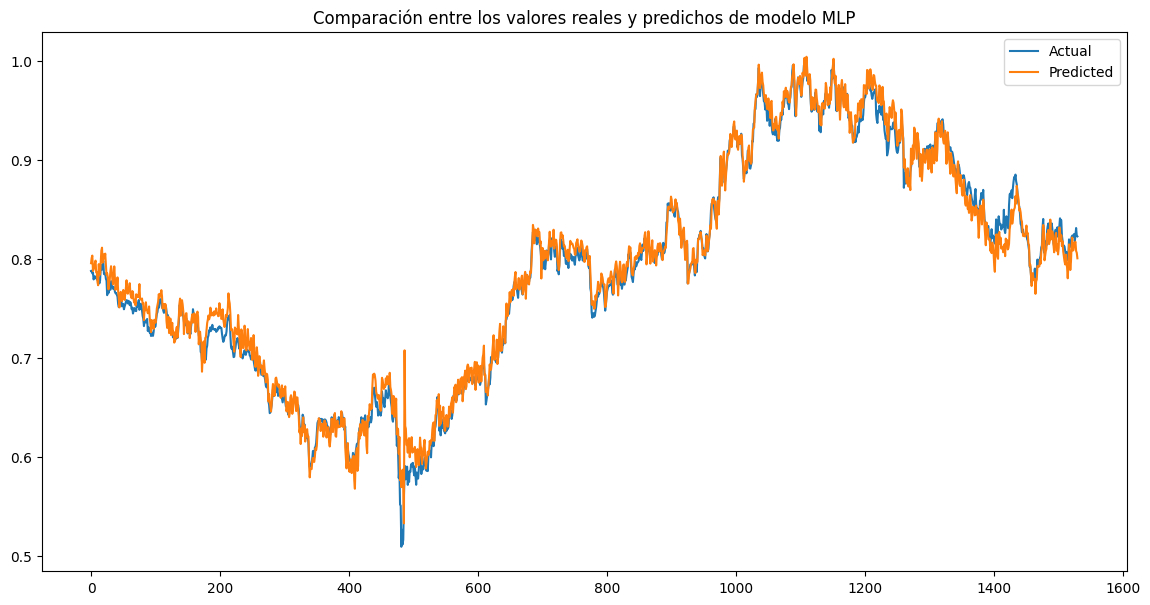

In [157]:
import matplotlib.pyplot as plt

y_pred_test_nn= model_nn.predict(X_test).reshape(-1)

# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_test_nn, label='Predicted')
plt.title('Comparación entre los valores reales y predichos de modelo MLP')
plt.legend()
plt.show()

## 3.4 Cross Validation Redes Neuronales Multi Layer Perceptrón

In [158]:
X.head()

Open_sqm  High_sqm   Low_sqm  Volume_sqm  Dividends_sqm  \
Date                                                                  
1994-01-03  0.055636  0.056025  0.055136    0.799696            0.0   
1994-01-04  0.056729  0.054398  0.055136    0.750837            0.0   
1994-01-05  0.055637  0.054398  0.052915    0.773359            0.0   
1994-01-06  0.055637  0.053307  0.052357    0.676503            0.0   
1994-01-07  0.051774  0.049451  0.049546    0.713819            0.0   

            Stock Splits_sqm  Open_tasas  High_tasas  Low_tasas  Close_tasas  \
Date                                                                           
1994-01-03               0.0    0.719260    0.720678   0.738481     0.720714   
1994-01-04               0.0    0.728713    0.726582   0.745102     0.726621   
1994-01-05               0.0    0.727542    0.725407   0.744005     0.725445   
1994-01-06               0.0    0.725190    0.723048   0.741804     0.723086   
1994-01-07               0.0    0.722827    0.720678   0.738481     0.718332   

            Volume_tasas  Open_sp500  High_sp500  Low_sp500  Close_sp500  \
Date                                                                       
1994-01-03           0.0    0.024224    0.019611   0.025317     0.023501   
1994-01-04           0.0    0.023304    0.019568   0.025386     0.024747   
1994-01-05           0.0    0.024550    0.020368   0.026658     0.025313   
1994-01-06           0.0    0.025116    0.021381   0.027601     0.024944   
1994-01-07           0.0    0.024721    0.022460   0.027609     0.027322   

            Adj Close_sp500  Volume_sp500  Open_nasdaq  High_nasdaq  \
Date                                                                  
1994-01-03         0.023501      0.435547     0.034219     0.033022   
1994-01-04         0.024747      0.464136     0.033130     0.032005   
1994-01-05         0.025313      0.494683     0.034673     0.033393   
1994-01-06         0.024944      0.481275     0.036743     0.034603   
1994-01-07         0.027322      0.463359     0.036313     0.035479   

            Low_nasdaq  Close_nasdaq  Adj Close_nasdaq  Volume_nasdaq  \
Date                                                                    
1994-01-03    0.033325      0.033017          0.033017       0.197605   
1994-01-04    0.034388      0.034447          0.034447       0.232332   
1994-01-05    0.035472      0.035971          0.035971       0.265560   
1994-01-06    0.037316      0.036922          0.036922       0.265158   
1994-01-07    0.037295      0.037938          0.037938       0.253334   

                Open      High       Low     Close  Adj Close  Day_of_week  \
Date                                                                         
1994-01-03  0.096249  0.154426  0.122543  0.138050   0.138050         0.00   
1994-01-04  0.153585  0.136527  0.143223  0.114427   0.114427         0.25   
1994-01-05  0.103479  0.087551  0.084861  0.077420   0.077420         0.50   
1994-01-06  0.103479  0.097411  0.083568  0.090338   0.090338         0.75   
1994-01-07  0.103479  0.111641  0.068669  0.078213   0.078213         1.00   

            Month  Year  
Date                     
1994-01-03    0.0   0.0  
1994-01-04    0.0   0.0  
1994-01-05    0.0   0.0  
1994-01-06    0.0   0.0  
1994-01-07    0.0   0.0

In [159]:
y.head()

Date
1994-01-03    0.056713
1994-01-04    0.055074
1994-01-05    0.054525
1994-01-06    0.051205
1994-01-07    0.048405
Name: Close_sqm, dtype: float64

In [160]:
X = X.values
y = y.values

In [188]:
print(X, y)

[[0.05563644 0.05602521 0.05513577 ... 0.         0.         0.        ]
 [0.056729   0.05439815 0.05513582 ... 0.25       0.         0.        ]
 [0.05563658 0.05439823 0.05291514 ... 0.5        0.         0.        ]
 ...
 [0.82528471 0.82754179 0.82929043 ... 0.25       0.36363636 1.        ]
 [0.83271037 0.8291324  0.82688163 ... 0.5        0.36363636 1.        ]
 [0.82304252 0.82171867 0.8232238  ... 0.75       0.36363636 1.        ]] [0.05671289 0.05507357 0.05452473 ... 0.83085848 0.82329705 0.82244236]


In [162]:
X_train_cv.shape

(6373, 31)

In [163]:
X_train_cv.shape[1]

31

In [191]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fijar semillas para reproducibilidad
np.random.seed(0)
tf.random.set_seed(0)

# Asegúrate de que X e y estén definidos antes de este punto y no cambien.
# Por ejemplo:
# X, y = some_preprocessed_data_function()

# Guarda una copia de X e y para verificar si cambian
X_initial = X.copy()
y_initial = y.copy()

# Creando el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Inicializando listas para almacenar las métricas
losses, maes, mses, r2s = [], [], [], []
histories = []

# Entrenamiento y evaluación del modelo utilizando validación cruzada
for train_index, test_index in tscv.split(X):
    # Verifica que X e y no cambien
    assert np.array_equal(X, X_initial), "X ha cambiado durante la ejecución"
    assert np.array_equal(y, y_initial), "y ha cambiado durante la ejecución"

    # Dividiendo X en conjuntos de entrenamiento y prueba usando los índices generados
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    # Dividiendo y en conjuntos de entrenamiento y prueba usando los mismos índices
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Define el modelo MLP
    model_nn = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_cv.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    # Compila el modelo
    model_nn.compile(optimizer='adam', loss='mse')

    # Entrena el modelo y guarda el historial
    history = model_nn.fit(X_train_cv, y_train_cv, epochs=10, verbose=1, validation_data=(X_test_cv, y_test_cv))  # Puedes ajustar el número de épocas según sea necesario
    histories.append(history)

    # Evalúa el modelo en el conjunto de prueba
    loss = model_nn.evaluate(X_test_cv, y_test_cv, verbose=0)
    y_pred_cv = model_nn.predict(X_test_cv).reshape(-1)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    # Guardar las métricas del fold actual
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

# Calcular las métricas promedio
loss_avg = np.mean(losses)
mae_avg = np.mean(maes)
mse_avg = np.mean(mses)
r2_avg = np.mean(r2s)

print(f'Average Loss: {loss_avg}')
print(f'Average MAE: {mae_avg}')
print(f'Average MSE: {mse_avg}')
print(f'Average R2: {r2_avg}')



Epoch 1/10
60/60 [==============================] - 1s 8ms/step - loss: 0.0116 - val_loss: 0.0463
Epoch 2/10
60/60 [==============================] - 0s 4ms/step - loss: 6.2641e-04 - val_loss: 0.0364
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 3.7079e-04 - val_loss: 0.0320
Epoch 4/10
60/60 [==============================] - 0s 6ms/step - loss: 2.3959e-04 - val_loss: 0.0289
Epoch 5/10
60/60 [==============================] - 0s 6ms/step - loss: 1.7210e-04 - val_loss: 0.0281
Epoch 6/10
60/60 [==============================] - 0s 6ms/step - loss: 1.1408e-04 - val_loss: 0.0257
Epoch 7/10
60/60 [==============================] - 0s 6ms/step - loss: 8.0097e-05 - val_loss: 0.0227
Epoch 8/10
60/60 [==============================] - 0s 4ms/step - loss: 6.5015e-05 - val_loss: 0.0212
Epoch 9/10
60/60 [==============================] - 0s 5ms/step - loss: 5.7557e-05 - val_loss: 0.0212
Epoch 10/10
60/60 [==============================] - 0s 3ms/step
Epoch 1/10
120/120 [=

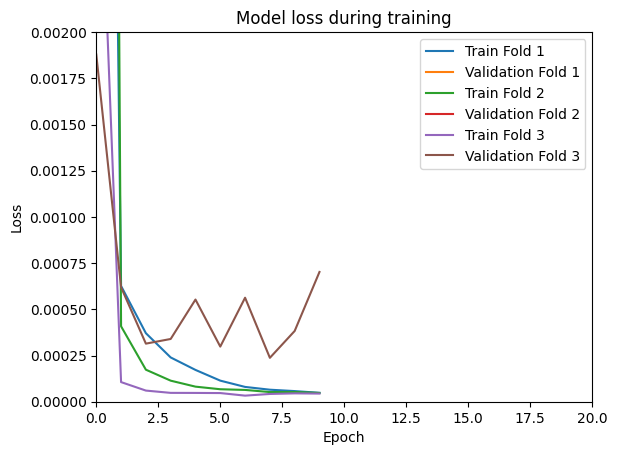

In [192]:
# Graficar el historial de entrenamiento
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Fold {i+1}')

plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 0.002)  # Ajustar los límites del eje Y
plt.xlim(0, 20)  # Ajustar los límites del eje X
plt.legend(loc='upper right')
plt.show()

## 3.5 Redes Neuronales Recurrentes LSTM

In [194]:
close_sqm_column = df.pop('Close_sqm')  # Extrae la columna Close_sqm
df.insert(0, 'Close_sqm', close_sqm_column)  # Inserta la columna Close_sqm en la primera posición

In [195]:
df

Close_sqm  Open_sqm  High_sqm   Low_sqm  Volume_sqm  \
Date                                                              
1994-01-03   0.056713  0.055636  0.056025  0.055136    0.799696   
1994-01-04   0.055074  0.056729  0.054398  0.055136    0.750837   
1994-01-05   0.054525  0.055637  0.054398  0.052915    0.773359   
1994-01-06   0.051205  0.055637  0.053307  0.052357    0.676503   
1994-01-07   0.048405  0.051774  0.049451  0.049546    0.713819   
...               ...       ...       ...       ...         ...   
2024-05-10   0.817251  0.826126  0.822559  0.818991    0.809628   
2024-05-13   0.823899  0.818801  0.820328  0.820703    0.783454   
2024-05-14   0.830858  0.825285  0.827542  0.829290    0.807937   
2024-05-15   0.823297  0.832710  0.829132  0.826882    0.809806   
2024-05-16   0.822442  0.823043  0.821719  0.823224    0.772085   

            Dividends_sqm  Stock Splits_sqm  Open_tasas  High_tasas  \
Date                                                                  
1994-01-03            0.0               0.0    0.719260    0.720678   
1994-01-04            0.0               0.0    0.728713    0.726582   
1994-01-05            0.0               0.0    0.727542    0.725407   
1994-01-06            0.0               0.0    0.725190    0.723048   
1994-01-07            0.0               0.0    0.722827    0.720678   
...                   ...               ...         ...         ...   
2024-05-10            0.0               0.0    0.930859    0.929709   
2024-05-13            0.0               0.0    0.930859    0.929709   
2024-05-14            0.0               0.0    0.930859    0.929555   
2024-05-15            0.0               0.0    0.930859    0.929555   
2024-05-16            0.0               0.0    0.930859    0.929325   

            Low_tasas  Close_tasas  Volume_tasas  Open_sp500  High_sp500  \
Date                                                                       
1994-01-03   0.738481     0.720714           0.0    0.024224    0.019611   
1994-01-04   0.745102     0.726621           0.0    0.023304    0.019568   
1994-01-05   0.744005     0.725445           0.0    0.024550    0.020368   
1994-01-06   0.741804     0.723086           0.0    0.025116    0.021381   
1994-01-07   0.738481     0.718332           0.0    0.024721    0.022460   
...               ...          ...           ...         ...         ...   
2024-05-10   0.935449     0.930360           0.0    0.993554    0.993452   
2024-05-13   0.935592     0.930129           0.0    0.994137    0.993267   
2024-05-14   0.935235     0.929746           0.0    0.993217    0.994275   
2024-05-15   0.935235     0.930129           0.0    0.996445    0.998960   
2024-05-16   0.935449     0.930129           0.0    1.000000    1.000000   

            Low_sp500  Close_sp500  Adj Close_sp500  Volume_sp500  \
Date                                                                
1994-01-03   0.025317     0.023501         0.023501      0.435547   
1994-01-04   0.025386     0.024747         0.024747      0.464136   
1994-01-05   0.026658     0.025313         0.025313      0.494683   
1994-01-06   0.027601     0.024944         0.024944      0.481275   
1994-01-07   0.027609     0.027322         0.027322      0.463359   
...               ...          ...              ...           ...   
2024-05-10   0.993033     0.993397         0.993397      0.826381   
2024-05-13   0.993147     0.993300         0.993300      0.850838   
2024-05-14   0.993671     0.995238         0.995238      0.867819   
2024-05-15   0.997131     0.999913         0.999913      0.854513   
2024-05-16   1.000000     1.000000         1.000000      0.671047   

            Open_nasdaq  High_nasdaq  Low_nasdaq  Close_nasdaq  \
Date                                                             
1994-01-03     0.034219     0.033022    0.033325      0.033017   
1994-01-04     0.033130     0.032005    0.034388      0.034447   
1994-01-05     0.034673     0.033393    0.035472      0.035971   

In [196]:
df.shape

(7647, 32)

In [197]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Convierte el DataFrame a un array numpy
data = df.values

data_normalized = data

# Número de pasos de tiempo para usar en la LSTM
n_steps = 30  # Por ejemplo, usa los últimos 30 pasos de tiempo como variables de entrada

# Divide los datos en muestras de entrada y salida
X, y = [], []
for i in range(len(data_normalized) - n_steps):
    X.append(data_normalized[i:i + n_steps, 1:])  # Usa los últimos n_steps como variables de entrada
    y.append(data_normalized[i + n_steps, 0])   # La variable a predecir es el precio de cierre (columna 3)

X, y = np.array(X), np.array(y)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [198]:
X.shape

(7617, 30, 31)

In [199]:
y.shape

(7617,)

In [200]:
# Define el modelo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compila el modelo
model_lstm.compile(optimizer='adam', loss='mse')

# Entrena el modelo
model_lstm.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
191/191 [==============================] - 6s 16ms/step - loss: 0.0053
Epoch 2/10
191/191 [==============================] - 3s 16ms/step - loss: 2.2056e-04
Epoch 3/10
191/191 [==============================] - 3s 16ms/step - loss: 1.6008e-04
Epoch 4/10
191/191 [==============================] - 5s 25ms/step - loss: 1.3084e-04
Epoch 5/10
191/191 [==============================] - 3s 15ms/step - loss: 1.3433e-04
Epoch 6/10
191/191 [==============================] - 3s 16ms/step - loss: 1.1536e-04
Epoch 7/10
191/191 [==============================] - 3s 16ms/step - loss: 1.1373e-04
Epoch 8/10
191/191 [==============================] - 5s 26ms/step - loss: 1.0374e-04
Epoch 9/10
191/191 [==============================] - 3s 16ms/step - loss: 1.0901e-04
Epoch 10/10
191/191 [==============================] - 3s 17ms/step - loss: 9.3314e-05


In [201]:
# Predicciones en el conjunto de entrenamiento
y_pred_train_lstm = model_lstm.predict(X_train).reshape(-1)

# Calcular métricas de evaluación para el conjunto de entrenamiento
mse_train_lstm = mean_squared_error(y_train, y_pred_train_lstm)
mae_train_lstm = mean_absolute_error(y_train, y_pred_train_lstm)
r2_train_lstm = r2_score(y_train, y_pred_train_lstm)

# Imprimir métricas para el conjunto de entrenamiento
print("LSTM (Entrenamiento):")
print("MSE:", mse_train_lstm)
print("MAE:", mae_train_lstm)
print("R2:", r2_train_lstm)

# Predicciones en el conjunto de prueba
y_pred_test_lstm = model_lstm.predict(X_test).reshape(-1)

# Calcular métricas de evaluación para el conjunto de prueba
mse_test_lstm = mean_squared_error(y_test, y_pred_test_lstm)
mae_test_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
r2_test_lstm = r2_score(y_test, y_pred_test_lstm)

# Imprimir métricas para el conjunto de prueba
print("\nLSTM (Prueba):")
print("MSE:", mse_test_lstm)
print("MAE:", mae_test_lstm)
print("R2:", r2_test_lstm)

191/191 [==============================] - 2s 7ms/step
LSTM (Entrenamiento):
MSE: 7.894674267050607e-05
MAE: 0.006453530507898118
R2: 0.9988474684735069
48/48 [==============================] - 0s 7ms/step

LSTM (Prueba):
MSE: 0.000669121844795481
MAE: 0.01973906615323572
R2: 0.9458227565732971


48/48 [==============================] - 1s 12ms/step


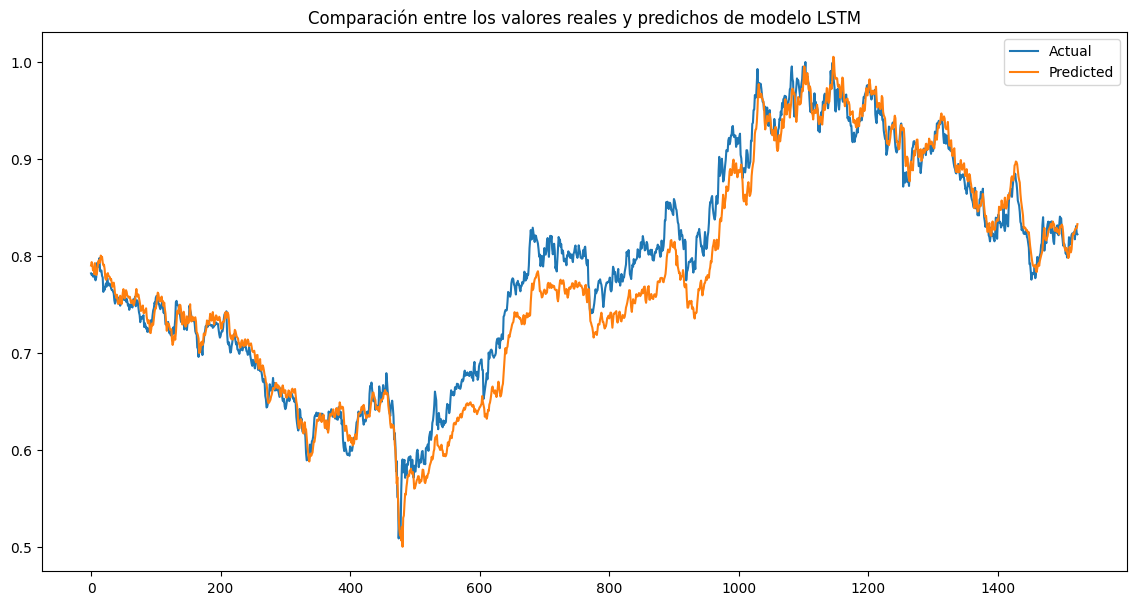

In [203]:
import matplotlib.pyplot as plt
# Predicciones en el conjunto de prueba
y_pred_test_lstm = model_lstm .predict(X_test).reshape(-1)

# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_lstm, label='Predicted')
plt.title('Comparación entre los valores reales y predichos de modelo LSTM')
plt.legend()
plt.show()

## 3.6 Cross Validation LSTM

In [208]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fijar semillas para reproducibilidad
np.random.seed(0)
tf.random.set_seed(0)

# Asegúrate de que X e y estén definidos antes de este punto y no cambien.
# Por ejemplo:
# X, y = some_preprocessed_data_function()

# Guarda una copia de X e y para verificar si cambian
X_initial = X.copy()
y_initial = y.copy()

# Creando el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando listas para almacenar las métricas
losses, maes, mses, r2s = [], [], [], []
histories = []

# Entrenamiento y evaluación del modelo utilizando validación cruzada
for train_index, test_index in tscv.split(X):
    # Verifica que X e y no cambien
    assert np.array_equal(X, X_initial), "X ha cambiado durante la ejecución"
    assert np.array_equal(y, y_initial), "y ha cambiado durante la ejecución"

    # Dividiendo X en conjuntos de entrenamiento y prueba usando los índices generados
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    # Dividiendo y en conjuntos de entrenamiento y prueba usando los mismos índices
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Define el modelo LSTM
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])

    # Compila el modelo
    model_lstm.compile(optimizer='adam', loss='mse')

    # Entrena el modelo y guarda el historial
    history = model_lstm.fit(X_train_cv, y_train_cv, epochs=20, verbose=1, validation_data=(X_test_cv, y_test_cv))  # Puedes ajustar el número de épocas según sea necesario
    histories.append(history)

    # Evalúa el modelo en el conjunto de prueba
    loss = model_lstm.evaluate(X_test_cv, y_test_cv, verbose=0)
    y_pred_cv = model_lstm.predict(X_test_cv).reshape(-1)
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    mse = mean_squared_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    # Guardar las métricas del fold actual
    losses.append(loss)
    maes.append(mae)
    mses.append(mse)
    r2s.append(r2)

# Calcular las métricas promedio
loss_avg = np.mean(losses)
mae_avg = np.mean(maes)
mse_avg = np.mean(mses)
r2_avg = np.mean(r2s)

print(f'Average Loss: {loss_avg}')
print(f'Average MAE: {mae_avg}')
print(f'Average MSE: {mse_avg}')
print(f'Average R2: {r2_avg}')


Epoch 1/20
40/40 [==============================] - 4s 28ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 2/20
40/40 [==============================] - 1s 24ms/step - loss: 6.6710e-04 - val_loss: 0.0020
Epoch 3/20
40/40 [==============================] - 1s 25ms/step - loss: 2.4892e-04 - val_loss: 9.9552e-04
Epoch 4/20
40/40 [==============================] - 1s 34ms/step - loss: 1.5232e-04 - val_loss: 8.2582e-04
Epoch 5/20
40/40 [==============================] - 2s 41ms/step - loss: 1.4131e-04 - val_loss: 8.3272e-04
Epoch 6/20
40/40 [==============================] - 2s 44ms/step - loss: 1.3149e-04 - val_loss: 5.2713e-04
Epoch 7/20
40/40 [==============================] - 2s 39ms/step - loss: 9.2109e-05 - val_loss: 4.2791e-04
Epoch 8/20
40/40 [==============================] - 1s 25ms/step - loss: 8.8317e-05 - val_loss: 3.8794e-04
Epoch 9/20
40/40 [==============================] - 1s 26ms/step - loss: 9.8356e-05 - val_loss: 3.9530e-04
Epoch 10/20
40/40 [==============================

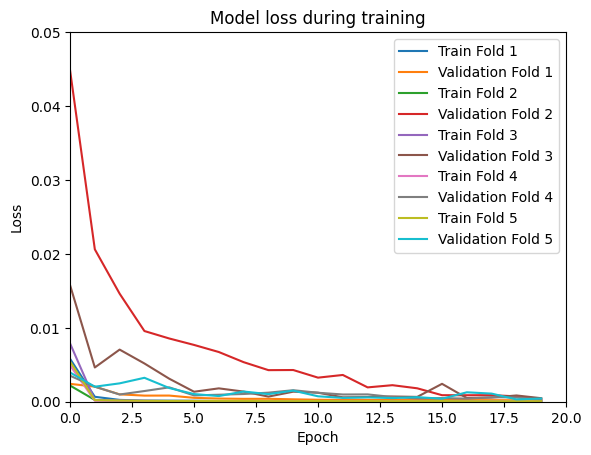

In [211]:
# Graficar el historial de entrenamiento
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Fold {i+1}')

plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 0.05)  # Ajustar los límites del eje Y
plt.xlim(0, 20)  # Ajustar los límites del eje X
plt.legend(loc='upper right')
plt.show()

# 4 Ajuste de hiperparámetros y Cross Validation

In [ ]:
from tensorflow.keras.layers import Dropout

# Define el modelo LSTM
model_lstm_opt  = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
])

# Compila el modelo
model_lstm_opt .compile(optimizer='adam', loss='mse')

# Entrena el modelo
model_lstm_opt.fit(X_train, y_train, epochs=10, verbose=1)


Epoch 1/10
191/191 [==============================] - 4s 13ms/step - loss: 0.0068
Epoch 2/10
191/191 [==============================] - 4s 20ms/step - loss: 0.0021
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0017
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.0014
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0013
Epoch 6/10
191/191 [==============================] - 2s 13ms/step - loss: 0.0012
Epoch 7/10
191/191 [==============================] - 4s 20ms/step - loss: 0.0010
Epoch 8/10
191/191 [==============================] - 3s 14ms/step - loss: 9.5892e-04
Epoch 9/10
191/191 [==============================] - 2s 13ms/step - loss: 8.5116e-04
Epoch 10/10
191/191 [==============================] - 2s 13ms/step - loss: 8.9716e-04


In [ ]:
# Predicciones en el conjunto de entrenamiento
y_pred_train = model_lstm_opt.predict(X_train).reshape(-1)

# Métricas en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Métricas de entrenamiento:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("R2:", r2_train)

# Predicciones en el conjunto de prueba
y_pred_test = model_lstm_opt.predict(X_test).reshape(-1)

# Métricas en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Métricas de prueba:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R2:", r2_test)


191/191 [==============================] - 1s 6ms/step
Métricas de entrenamiento:
MSE: 0.00010867952900282906
MAE: 0.007952559554005569
R2: 0.9984129512105013
48/48 [==============================] - 0s 5ms/step
Métricas de prueba:
MSE: 0.0035385806721524166
MAE: 0.04253981641949922
R2: 0.7136366854362249


48/48 [==============================] - 0s 5ms/step


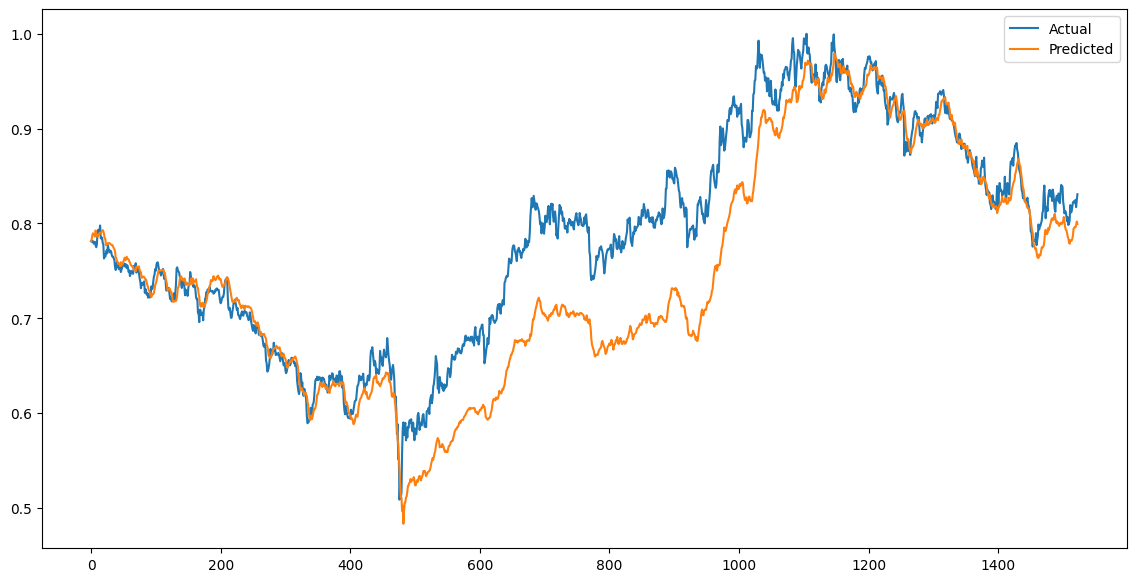

In [ ]:
import matplotlib.pyplot as plt
# 30 pasos 50 neuronas
# Predicciones en el conjunto de prueba
y_pred_test_lstm_opt = model_lstm_opt.predict(X_test).reshape(-1)

# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_lstm_opt, label='Predicted')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Define el número de splits para TimeSeriesSplit
n_splits = 5  # Por ejemplo, utiliza 5 splits para validación cruzada

# Inicializa TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Entrenamiento y evaluación del modelo utilizando validación cruzada
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    # Define el modelo LSTM con Dropout
    model_lstm_reg = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train_cv.shape[1], X_train_cv.shape[2])),
        Dense(1)
    ])

    # Compila el modelo
    model_lstm_reg.compile(optimizer= 'adam', loss='mse')

    # Entrena el modelo
    model_lstm_reg.fit(X_train_cv, y_train_cv, epochs=20, verbose=1)

    # Evalúa el modelo en el conjunto de prueba
    loss = model_lstm_reg.evaluate(X_test_cv, y_test_cv)
    print("Loss en conjunto de prueba:", loss)

Epoch 1/20
32/32 [==============================] - 2s 14ms/step - loss: 0.0061
Epoch 2/20
32/32 [==============================] - 0s 14ms/step - loss: 5.9552e-04
Epoch 3/20
32/32 [==============================] - 0s 14ms/step - loss: 4.0011e-04
Epoch 4/20
32/32 [==============================] - 0s 14ms/step - loss: 2.6452e-04
Epoch 5/20
32/32 [==============================] - 0s 13ms/step - loss: 2.0300e-04
Epoch 6/20
32/32 [==============================] - 1s 21ms/step - loss: 1.5731e-04
Epoch 7/20
32/32 [==============================] - 1s 22ms/step - loss: 1.1888e-04
Epoch 8/20
32/32 [==============================] - 1s 21ms/step - loss: 9.3717e-05
Epoch 9/20
32/32 [==============================] - 1s 22ms/step - loss: 7.9685e-05
Epoch 10/20
32/32 [==============================] - 1s 22ms/step - loss: 7.7640e-05
Epoch 11/20
32/32 [==============================] - 1s 23ms/step - loss: 6.7956e-05
Epoch 12/20
32/32 [==============================] - 1s 19ms/step - loss: 6.16

KeyboardInterrupt: 

In [ ]:
# Predicciones en el conjunto de entrenamiento
y_pred_train_lstm = model_lstm_reg.predict(X_train).reshape(-1)

# Calcular métricas de evaluación para el conjunto de entrenamiento
mse_train_lstm = mean_squared_error(y_train, y_pred_train_lstm)
mae_train_lstm = mean_absolute_error(y_train, y_pred_train_lstm)
r2_train_lstm = r2_score(y_train, y_pred_train_lstm)

# Imprimir métricas para el conjunto de entrenamiento
print("LSTM (Entrenamiento):")
print("MSE:", mse_train_lstm)
print("MAE:", mae_train_lstm)
print("R2:", r2_train_lstm)

# Predicciones en el conjunto de prueba
y_pred_test_lstm = model_lstm_reg.predict(X_test).reshape(-1)

# Calcular métricas de evaluación para el conjunto de prueba
mse_test_lstm = mean_squared_error(y_test, y_pred_test_lstm)
mae_test_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
r2_test_lstm = r2_score(y_test, y_pred_test_lstm)

# Imprimir métricas para el conjunto de prueba
print("\nLSTM (Prueba):")
print("MSE:", mse_test_lstm)
print("MAE:", mae_test_lstm)
print("R2:", r2_test_lstm)

191/191 [==============================] - 1s 5ms/step
LSTM (Entrenamiento):
MSE: 0.00018245403660371924
MAE: 0.01023149351163426
R2: 0.9973356209712362
48/48 [==============================] - 0s 5ms/step

LSTM (Prueba):
MSE: 0.0038123658467686386
MAE: 0.05268315476676156
R2: 0.6914803359431856


48/48 [==============================] - 0s 7ms/step


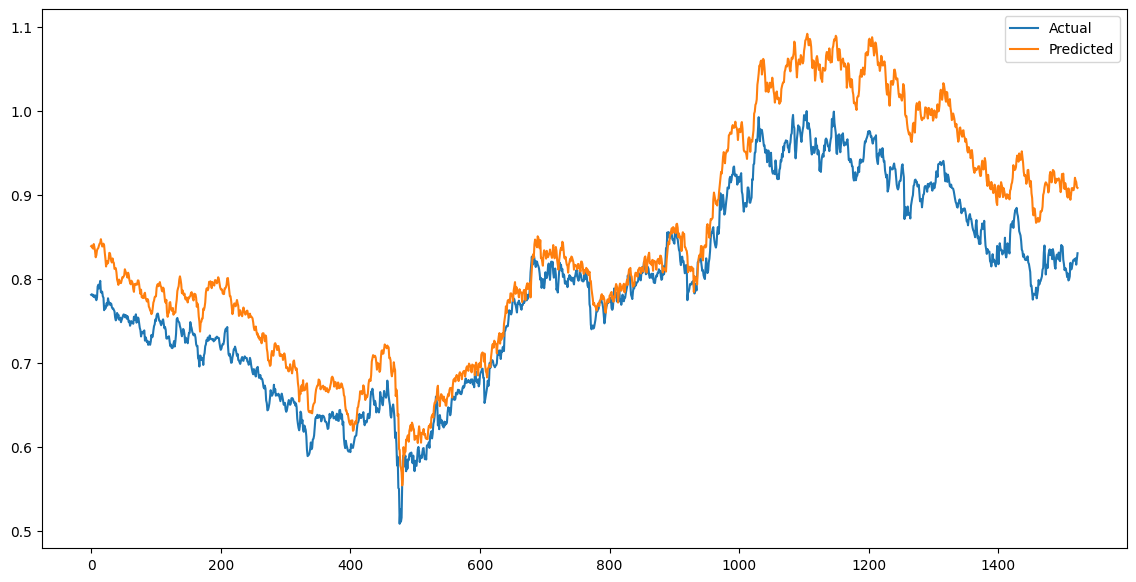

In [ ]:
import matplotlib.pyplot as plt
# 365 pasos 50 neuronas
# Predicciones en el conjunto de prueba
y_pred_test_lstm_reg = model_lstm_reg.predict(X_test).reshape(-1)

# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_test_lstm_reg, label='Predicted')
plt.legend()
plt.show()


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error
# from xgboost import XGBRegressor

# # Definir el espacio de búsqueda de hiperparámetros
# param_grid = {
#     'n_estimators': [500],
#     'learning_rate': [0.01, 0.1],
#     'gamma': [0, 0.6],
#     'reg_alpha': [0, 1],
#     'reg_lambda': [0, 0.01],
#     'subsample': [0.5, 0.9],
#     'colsample_bytree': [0.5],
#     'max_depth': [3, 9, 11],
#     'objective': ['reg:squarederror']
# }

# # Crear el modelo XGBRegressor
# model = XGBRegressor()

# # Realizar la búsqueda de hiperparámetros con validación cruzada y early stopping
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], eval_metric='rmse', verbose=True)

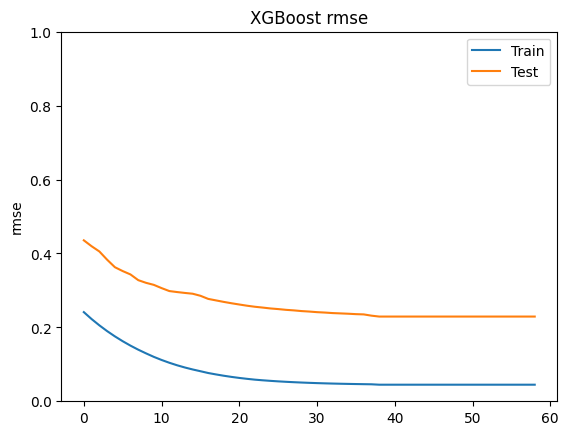

In [ ]:
from matplotlib import pyplot # Data visualization
results = model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.set_ylim([0, 1])
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse')
pyplot.title('XGBoost rmse')
pyplot.show()

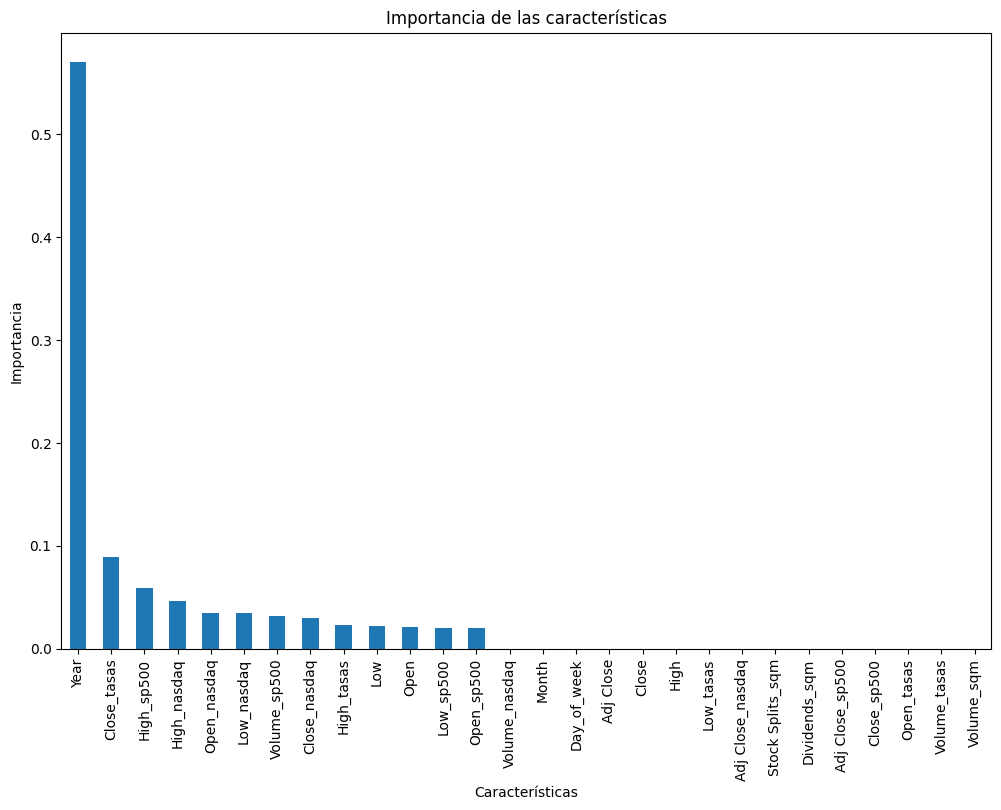

In [ ]:
# Crear el gráfico de barras para las características importantes
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)
plt.figure(figsize=(12, 8))
feature_importance_sorted.plot(kind='bar')
plt.title('Importancia de las características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.show()


In [ ]:
# 6. Red Neuronal
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])
model_nn.compile(optimizer='adam', loss='mse')
model_nn.fit(X_train, y_train, epochs=100, verbose=0)  # Puedes ajustar el número de épocas según sea necesario

# Predicciones en el conjunto de entrenamiento
y_pred_train_nn = model_nn.predict(X_train).reshape(-1)

# Métricas en el conjunto de entrenamiento
mse_train_nn = mean_squared_error(y_train, y_pred_train_nn)
mae_train_nn = mean_absolute_error(y_train, y_pred_train_nn)
r2_train_nn = r2_score(y_train, y_pred_train_nn)

# Imprimir métricas de la Red Neuronal en entrenamiento
print("Red Neuronal (Entrenamiento):")
print("MSE:", mse_train_nn)
print("MAE:", mae_train_nn)
print("R2:", r2_train_nn)

# Predicciones en el conjunto de prueba
y_pred_test_nn = model_nn.predict(X_test).reshape(-1)

# Métricas en el conjunto de prueba
mse_test_nn = mean_squared_error(y_test, y_pred_test_nn)
mae_test_nn = mean_absolute_error(y_test, y_pred_test_nn)
r2_test_nn = r2_score(y_test, y_pred_test_nn)

# Imprimir métricas de la Red Neuronal en prueba
print("Red Neuronal (Prueba):")
print("MSE:", mse_test_nn)
print("MAE:", mae_test_nn)
print("R2:", r2_test_nn)

192/192 [==============================] - 0s 1ms/step
Red Neuronal (Entrenamiento):
MSE: 1.0180709698908178e-05
MAE: 0.00280196921148148
R2: 0.9996206876076712
48/48 [==============================] - 0s 2ms/step
Red Neuronal (Prueba):
MSE: 1.0574852002738186e-05
MAE: 0.0027559488456243043
R2: 0.9984317429922116
